In [1]:
import ngmix
import fitsio
import proplot as pplt
import numpy as np
import piff
import galsim
import yaml

In [2]:
%matplotlib inline

In [3]:
TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]

with open(
    "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
    "%s_%s_pizza_cutter_info.yaml" % (TNAMES[0], BANDS[0])
) as fp:
    yml = yaml.safe_load(fp.read())

In [65]:
import scipy.optimize

def _get_star_stamp_pos(s, img, wgt, bbox):
    xint = int(np.floor(s.x - 1 + 0.5))
    yint = int(np.floor(s.y - 1 + 0.5))
    bbox_2 = (bbox - 1)//2

    return dict(
        img=img[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1].copy(),
        wgt=wgt[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1].copy(),
        xstart=xint-bbox_2,
        ystart=yint-bbox_2,
        dim=bbox,
        x=s.x - 1,
        y=s.y - 1,
    )


def get_star_obs(piff_mod, s, img, wgt, piff_prop, star_dim):

    if piff_prop:
        kwargs = {
            piff_prop: s.data.properties[piff_prop]
        }
    else:
        kwargs = {}
    sres = _get_star_stamp_pos(s, img, wgt, star_dim)
    sres.update(**kwargs)

    xv = sres["x"]+1
    yv = sres["y"]+1
    wcs = list(piff_mod.wcs.values())[0].local(
        image_pos=galsim.PositionD(x=xv, y=yv)
    ).jacobian()
    img = galsim.ImageD(sres["dim"], sres["dim"], wcs=wcs)
    cen = (
        sres["x"] - sres["xstart"] + 1,
        sres["y"] - sres["ystart"] + 1,
    )
    _img = sres.pop("img")
    _wgt = sres.pop("wgt")
    nrm = _img.sum()
    nrm2 = nrm*nrm
    _img /= nrm
    _wgt *= nrm2
    
    star_obs = ngmix.Observation(
        image=_img,
        weight=_wgt,
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    sres["local_wcs"] = wcs
    star_obs.update_meta_data(sres)
    
    if star_obs.get_s2n() > 100:
        nse = np.sqrt(np.sum(star_obs.image**2)) / 100
        star_obs.weight = np.ones_like(star_obs.weight) / nse**2

    return star_obs


def _make_galsim_model(*, img, dilation, g1, g2, scale, dim):
    img = img.reshape((dim, dim))
    return galsim.InterpolatedImage(
        galsim.ImageD(img), scale=scale, x_interpolant="lanczos3",
    ).dilate(
        dilation
    ).shear(
        eta1=g1, eta2=g2
    )
    

def _draw_galsim_model(*, mod, offset_x, offset_y, local_wcs, dim):
    return mod.drawImage(
        nx=dim, ny=dim, 
        wcs=local_wcs, 
        offset=galsim.PositionD(x=offset_x, y=offset_y),
        method="no_pixel",
    ).array


def _predict_star(
    *, xy_params, dilation_params, g1_params, g2_params, 
    star_xy, star_colxy, offset_x, offset_y, local_wcs,
    star_dim, model_dim, model_scale,
):
    _pp = xy_params.reshape((model_dim*model_dim, star_xy.shape[0]))
    img = np.dot(_pp, star_xy)
    dilation = 1.0 + np.dot(dilation_params, star_colxy)
    g1 = np.dot(g1_params, star_colxy)
    g2 = np.dot(g2_params, star_colxy)
    mod = _make_galsim_model(
        img=img, 
        dilation=dilation, 
        g1=g1, 
        g2=g2,
        scale=model_scale,
        dim=model_dim,
    )
    img = _draw_galsim_model(
        mod=mod, 
        offset_x=offset_x,
        offset_y=offset_y, 
        local_wcs=local_wcs, 
        dim=star_dim,
    )
        
    return img


def _build_star_xy_colxy(*, x, y, col, colcen, colscale, xcen=1024, ycen=2048, xyscale=2048):
    xs = (x-xcen)/xyscale
    ys = (y-ycen)/xyscale
    cols = (col-colcen)/colscale
    
    return (
        np.array([
            1, 
            xs, 
            ys, 
            xs*ys, 
            xs**2, 
            ys**2,
        ]), 
        np.array([
            1,
            cols, 
            xs*cols, 
            ys*cols, 
            cols*cols,
            xs*xs*cols,
            ys*ys*cols,
            xs*ys*cols,
        ])
    )


def _init_model_params(*, model_dim, rng, stars, model_scale, init_scale, poly_guess, dim_xy, dim_colxy):
    tot = model_dim*model_dim*dim_xy + 3*dim_colxy
    nse = rng.normal(size=tot, scale=init_scale)
    nn = model_dim**2
    nse[0:nn*dim_xy] += poly_guess
    return nse


def _extract_model_params(params, fit_data):
    nxy = fit_data["model_dim"]**2 * fit_data["dim_xy"]
    dd = fit_data["dim_colxy"]
    xy_params = params[0:nxy]
    dilation_params = params[nxy:nxy+dd]
    g1_params = params[nxy+dd:nxy+dd*2]
    g2_params = params[nxy+dd*2:nxy+dd*3]
    
    return nxy, xy_params, dilation_params, g1_params, g2_params
    

def _compute_model_resid(params, fit_data):
    nxy, xy_params, dilation_params, g1_params, g2_params = _extract_model_params(
        params, fit_data,
    )
    # star_params = params[nxy+12:]
    
    n_resids_per_star = fit_data["star_dim"]**2
    n_resids = fit_data["n_stars"] * n_resids_per_star
    resids = np.zeros(n_resids) + np.nan
    rloc = 0
    for sind, sobs in enumerate(fit_data["stars"]):
        xy, colxy = _build_star_xy_colxy(
            x=sobs.meta["x"], 
            y=sobs.meta["y"], 
            col=sobs.meta["col"], 
            colcen=fit_data["colcen"], 
            colscale=fit_data["colscale"],
        )
        
        simg = _predict_star(
            xy_params=xy_params, 
            dilation_params=dilation_params, 
            g1_params=g1_params, 
            g2_params=g2_params, 
            star_xy=xy, 
            star_colxy=colxy, 
            offset_x=sobs.meta["cen_offset_x"], 
            offset_y=sobs.meta["cen_offset_y"], 
            local_wcs=sobs.meta["local_wcs"],
            star_dim=fit_data["star_dim"], 
            model_dim=fit_data["model_dim"], 
            model_scale=fit_data["model_scale"],
        )
        simg = simg.ravel()
        resids[rloc:rloc+simg.shape[0]] = (sobs.image.ravel() - simg) * sobs.meta["sqrt_wgt_ravel"]
#         resids[rloc+simg.shape[0]+0] = star_params[2*sind+0]/fit_data["offset_width"]
#         resids[rloc+simg.shape[0]+1] = star_params[2*sind+1]/fit_data["offset_width"]
        rloc += n_resids_per_star
            
    n_data = len(fit_data["stars"]) * fit_data["star_dim"]**2
    dof = n_data - len(params)
    
    if fit_data["itr"] % 100 == 0 and fit_data["verbose"]:
        n_data = len(fit_data["stars"]) * fit_data["star_dim"]**2
        print("itr:", fit_data["itr"])
        print("    chi2/dof:", np.sum(resids**2)/(n_data - len(params)))
        print("    params:", params.min(), params.max())
        print("    resids:", resids.min(), resids.max())
        if "last_params" in fit_data:
            print("    diff params:", np.max(np.abs(fit_data["last_params"] - params)))
    fit_data["itr"] = fit_data["itr"] + 1
    fit_data["last_params"] = params.copy()
    
        
    return resids/np.sqrt(dof)
    

def _build_fit_data(
    *, star_dim, model_dim, model_scale,
    stars, colname, colcen, colscale, init_scale,
):
    fit_data = dict(
        star_dim=star_dim,
        model_dim=model_dim,
        stars=stars,
        colcen=colcen,
        colscale=colscale,
        model_scale=model_scale,
        n_stars=len(stars),
        colname=colname,
        init_scale=init_scale,
        verbose=False,
    )
    for star in stars:
        star.meta["sqrt_wgt_ravel"] = np.sqrt(np.ravel(star.weight))
        star.meta["cen_offset_x"] = star.meta["x"] - np.floor(star.meta["x"] + 0.5)
        star.meta["cen_offset_y"] = star.meta["y"] - np.floor(star.meta["y"] + 0.5)
        star.meta["col"] = star.meta[colname]
    fit_data["stars"] = stars

    dd, cdd = _build_star_xy_colxy(
        x=10, y=10, col=1, colcen=0, colscale=1
    )
    fit_data["dim_xy"] = dd.shape[0]
    fit_data["dim_colxy"] = cdd.shape[0]

    images = np.array([
        galsim.InterpolatedImage(
            galsim.ImageD(s.image), 
            wcs=s.meta["local_wcs"], 
            offset=(s.meta["cen_offset_x"], s.meta["cen_offset_y"]),
            flux=1,
        ).drawImage(nx=model_dim, ny=model_dim, scale=model_scale, method="no_pixel").array.ravel()
        for s in stars
    ])
    
    coeffs = np.array([
        _build_star_xy_colxy(
            x=s.meta["x"], y=s.meta["y"], col=s.meta["col"], 
            colcen=colcen, colscale=colscale,
        )[0]
        for s in stars
    ])
    A = np.linalg.lstsq(coeffs, images, rcond=None)[0]
    fit_data["poly_guess"] = A.T.ravel()
    
    return fit_data


class MattsColorModel(object):
    """TODO
    """
    def __init__(
        self, 
        *,
        piff_model, image, weight, 
        colname, colcen, colscale,
        init_scale=0.01,
        star_dim=17, model_dim=17,
        model_scale=0.3,
        seed=None,
    ):
        self.image = image
        self.weight = weight
        self.piff = piff_model
        stars = [
            get_star_obs(self.piff, s, self.image, self.weight, colname, star_dim)
            for s in self.piff.stars
        ]

        self.fit_data = _build_fit_data(
            star_dim=star_dim, 
            model_dim=model_dim, 
            stars=stars, 
            colname=colname, 
            colcen=colcen, 
            colscale=colscale,
            model_scale=model_scale,
            init_scale=init_scale,
        )
        self.stars = self.fit_data["stars"]

        self.rng = np.random.RandomState(seed=seed)
        self.wcs = {0: None}
        
    def fit(self, **kwargs):
        try:
            x0 = self.get_init_params()
            self.fit_data["itr"] = 0
            self.fit_data["verbose"] = kwargs.get("verbose", False)
            if "last_params" in self.fit_data:
                self.fit_data.pop("last_params")
            self.fit_res = scipy.optimize.least_squares(
                _compute_model_resid, 
                x0, 
                args=(self.fit_data,), 
                **kwargs,
            )
        finally:
            self.fit_data["verbose"] = False
    
    def get_init_params(self, init_scale=None):
        return _init_model_params(
                model_dim=self.fit_data["model_dim"], 
                rng=self.rng, 
                stars=self.fit_data["stars"], 
                model_scale=self.fit_data["model_scale"],
                init_scale=init_scale or self.fit_data["init_scale"],
                poly_guess=self.fit_data["poly_guess"],
                dim_xy=self.fit_data["dim_xy"],
                dim_colxy=self.fit_data["dim_colxy"],
            )
    
    def get_dilation_eta1eta2(self, x, y, params=None, **kwargs):
        if params is None:
            if not hasattr(self, "fit_res"):
                raise RuntimeError("call fit!")
            params = self.fit_res.x
        
        if self.fit_data["colname"] in kwargs:
            col = kwargs[self.fit_data["colname"]]
        else:
            col = self.fit_data["colcen"]

        star_xy, star_colxy = _build_star_xy_colxy(
            x=x, 
            y=y, 
            col=col, 
            colcen=self.fit_data["colcen"], 
            colscale=self.fit_data["colscale"]
        )

        _, _, dilation_params, g1_params, g2_params = _extract_model_params(
            params, self.fit_data
        )
        
        dilation = 1.0 + np.dot(dilation_params, star_colxy)
        g1 = np.dot(g1_params, star_colxy)
        g2 = np.dot(g2_params, star_colxy)
        return dilation, g1, g2
    
    def draw(self, x, y, offset=None, params=None, **kwargs):
        if self.fit_data["colname"] in kwargs:
            col = kwargs[self.fit_data["colname"]]
        else:
            col = self.fit_data["colcen"]
        
        if params is None:
            if not hasattr(self, "fit_res"):
                raise RuntimeError("call fit!")
            params = self.fit_res.x
        
        x -= 1
        y -= 1
        wcs = list(self.piff.wcs.values())[0].local(
            image_pos=galsim.PositionD(x=x+1, y=y+1)
        ).jacobian()

        xy, colxy = _build_star_xy_colxy(
            x=x, y=y, col=col, colcen=self.fit_data["colcen"], colscale=self.fit_data["colscale"]
        )
        
        _, xy_params, dilation_params, g1_params, g2_params = _extract_model_params(
            params, self.fit_data
        )
        
        if offset is None:
            offset = (
                x - np.floor(x+0.5),
                y - np.floor(y+0.5),
            )
        
        return galsim.ImageD(
            _predict_star(
                xy_params=xy_params, 
                dilation_params=dilation_params, 
                g1_params=g1_params, 
                g2_params=g2_params, 
                star_xy=xy, 
                star_colxy=colxy, 
                offset_x=offset[0], 
                offset_y=offset[1], 
                local_wcs=wcs,
                star_dim=self.fit_data["star_dim"], 
                model_dim=self.fit_data["model_dim"], 
                model_scale=self.fit_data["model_scale"],
            ),
            wcs=wcs,
        )

In [71]:
sind = 0

src = yml["src_info"][sind]
piff_mod = piff.read(src["piff_path"])

img = (
    fitsio.read(src["image_path"], ext=src["image_ext"])
    - fitsio.read(src["bkg_path"], ext=src["bkg_ext"])
)
wgt = fitsio.read(src["weight_path"], ext=src["weight_ext"])

print("piff chi2/dof:", piff_mod.chisq / piff_mod.dof)

piff chi2/dof: 0.4574772018212544


In [67]:
mmod = MattsColorModel(
    piff_model=piff_mod, 
    image=img, 
    weight=wgt, 
    colname="GI_COLOR", 
    colcen=1.6, 
    colscale=1.5,
    init_scale=1e-3,
)

In [69]:
mmod.fit(method="lm", verbose=2, diff_step=1e-3, xtol=1e-2, ftol=1e-1)

itr: 0
    chi2/dof: 1.3150355908582743
    params: -0.010005623326624876 0.03888277268173353
    resids: -5.870306582552905 5.816775085968936
itr: 100
    chi2/dof: 1.3150355899888713
    params: -0.010005623326624876 0.03888277268173353
    resids: -5.870306582552905 5.816775085968936
    diff params: 2.2835215405137433e-07
itr: 200
    chi2/dof: 1.3150330917171085
    params: -0.010005623326624876 0.03888277268173353
    resids: -5.870306582552905 5.816775085968936
    diff params: 8.867774385338699e-07
itr: 300
    chi2/dof: 1.315035345810096
    params: -0.010005623326624876 0.03888277268173353
    resids: -5.870306582552905 5.816775085968936
    diff params: 2.189212436536341e-06
itr: 400
    chi2/dof: 1.3150352428168102
    params: -0.010005623326624876 0.03888277268173353
    resids: -5.870306582552905 5.816775085968936
    diff params: 2.4992802820159032e-06
itr: 500
    chi2/dof: 1.315035546803744
    params: -0.010005623326624876 0.03888277268173353
    resids: -5.8703065825

itr: 4500
    chi2/dof: 0.6700249432952446
    params: -0.08648622532353442 0.08315577043574293
    resids: -3.9564245767955675 4.044758291240648
    diff params: 6.055454452393396e-06
itr: 4600
    chi2/dof: 0.6700249449926631
    params: -0.08648622532353442 0.08315577043574293
    resids: -3.9564245767955675 4.044758291240648
    diff params: 6.055454452393396e-06
itr: 4700
    chi2/dof: 0.6700249089474203
    params: -0.08648622532353442 0.08315577043574293
    resids: -3.9564245767955675 4.044758291240648
    diff params: 6.055454452393342e-06
itr: 4800
    chi2/dof: 0.6700249705137571
    params: -0.08648622532353442 0.08315577043574293
    resids: -3.9564245767955675 4.044758291240648
    diff params: 6.055454452393396e-06
itr: 4900
    chi2/dof: 0.6700251307884532
    params: -0.08648622532353442 0.08315577043574293
    resids: -3.9564245767955675 4.044758291240648
    diff params: 6.0554544523937215e-06
itr: 5000
    chi2/dof: 0.6700249301768204
    params: -0.0864862253235344

star: 0
    sums piff|me|img: 0.9827682441118792 0.9993605516106072 1.000000028667273
    piff chi2/dof: 0.06566989636214748
    me   chi2/dof: 0.07711816999332832
    color|dilation|g1|g2: 1.6329615318393988 0.9996358362854993 -0.007982752092615767 0.0017220632041094045
star: 1
    sums piff|me|img: 0.9831209220157403 0.9985636864421394 0.9999999859828677
    piff chi2/dof: 0.1220541871477593
    me   chi2/dof: 0.1307085910287246
    color|dilation|g1|g2: 2.2448226349698 0.9945496407877944 -0.006417359808439131 0.005491206076011489
star: 2
    sums piff|me|img: 0.9837053937978759 0.9982180707947919 0.9999999613428372
    piff chi2/dof: 0.124541573712245
    me   chi2/dof: 0.04086041213236498
    color|dilation|g1|g2: 0.7163089725254329 1.0066289601693952 -0.006369980341328976 0.001848592279246491
star: 3
    sums piff|me|img: 0.990006479722538 0.9959160630724 1.0000000263944457
    piff chi2/dof: 0.5247016707150477
    me   chi2/dof: 0.9286895859608482
    color|dilation|g1|g2: 2.8187

/Users/beckermr/miniconda3/envs/desy6/lib/python3.8/site-packages/proplot/ui.py:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  return plt.figure(FigureClass=pfigure.Figure, **kwargs)


    piff chi2/dof: 0.9930262683345281
    me   chi2/dof: 0.9395296208627824
    color|dilation|g1|g2: 1.40534129560367 1.0018466221220872 -0.00672742010956067 0.0017422612405337443
star: 21
    sums piff|me|img: 0.9837243174681235 1.0000166106292454 0.9999999937872417
    piff chi2/dof: 0.0594786839793363
    me   chi2/dof: 0.04055866226754793
    color|dilation|g1|g2: 0.7496862293887995 1.0098791627371289 0.00047885246687855257 0.010794595041444272
star: 22
    sums piff|me|img: 0.9782239559812012 0.9979539379251037 0.9999999412139005
    piff chi2/dof: 0.06865534558615788
    me   chi2/dof: 0.0359764480091518
    color|dilation|g1|g2: 0.8469601686257886 1.006675587902869 -0.0014270170954221667 0.003185717238447768
star: 23
    sums piff|me|img: 0.9791068137964236 0.9974693207502696 0.9999999402061803
    piff chi2/dof: 0.7161964762602305
    me   chi2/dof: 0.9402294880941217
    color|dilation|g1|g2: 0.8806900056663198 1.0089098476339016 -0.0007233480425483617 0.01448595437155198
sta

    piff chi2/dof: 1.6188347151660434
    me   chi2/dof: 1.0534250158318197
    color|dilation|g1|g2: 2.3315944474269097 0.9963722382629262 -0.0043693011633985715 0.010253848527584647
star: 52
    sums piff|me|img: 0.9955818712235444 1.0032937340247372 1.0000000668569555
    piff chi2/dof: 1.9840772601432797
    me   chi2/dof: 0.21368139755446497
    color|dilation|g1|g2: 1.5843611963520003 0.9999590659284141 -0.008074737755250772 0.0015392436331579475
star: 53
    sums piff|me|img: 0.9830436373346458 0.999363581329817 1.0000000339314283
    piff chi2/dof: 1.1687502646984835
    me   chi2/dof: 1.0806145268646183
    color|dilation|g1|g2: 1.811444268187581 0.9982165415420304 -0.007589827692894501 0.002601883230292475
star: 54
    sums piff|me|img: 0.981886026743934 0.9974538868241325 0.9999999901147021
    piff chi2/dof: 1.3619556185757997
    me   chi2/dof: 0.9409728425025236
    color|dilation|g1|g2: 3.145356780800808 0.987435020059329 0.0003438583053565858 0.018724424516741483
star: 

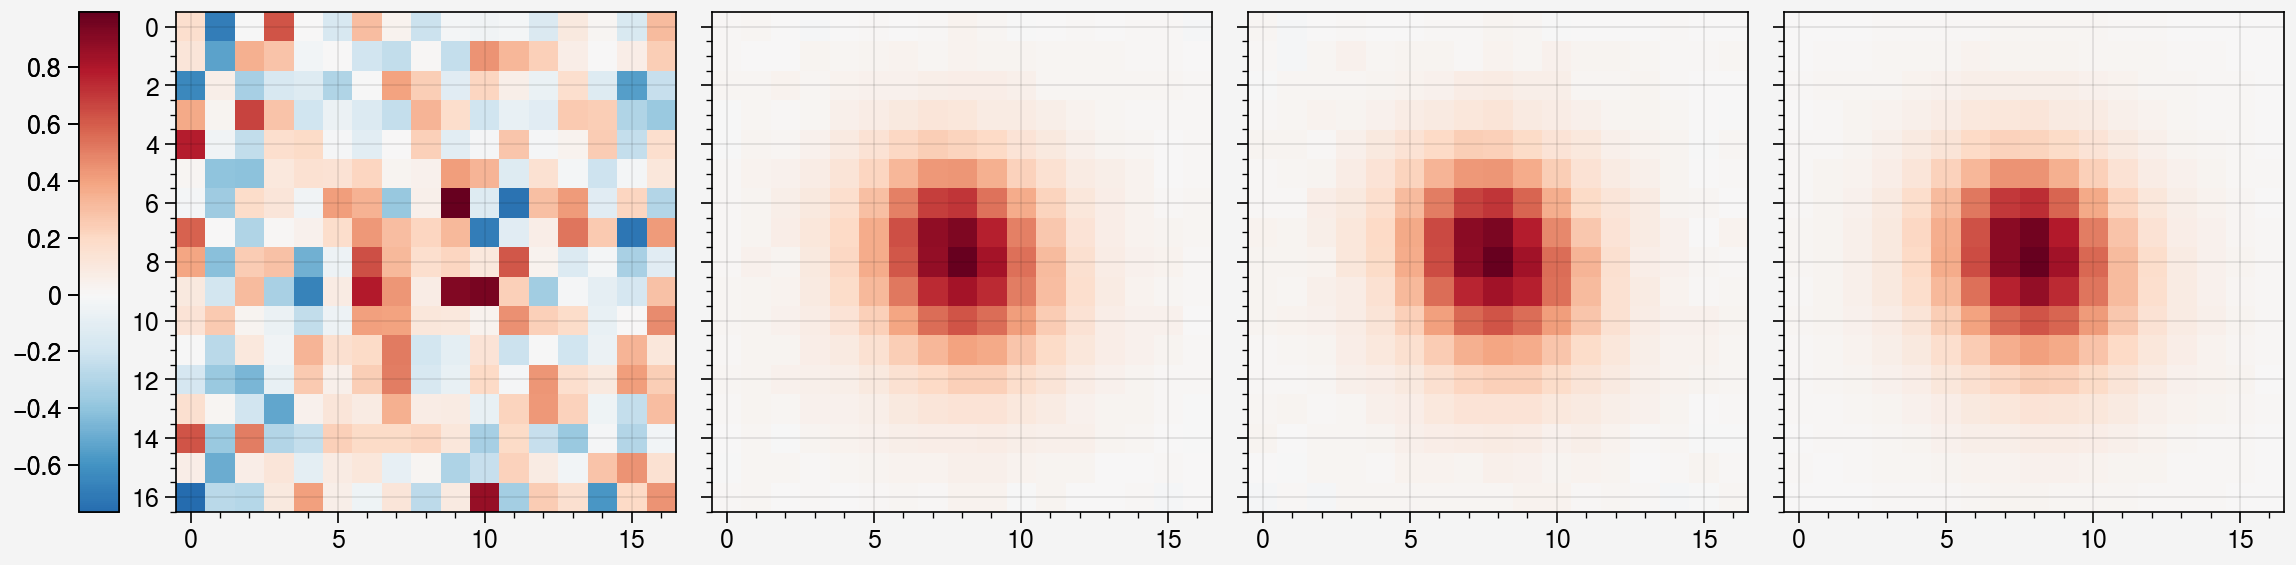

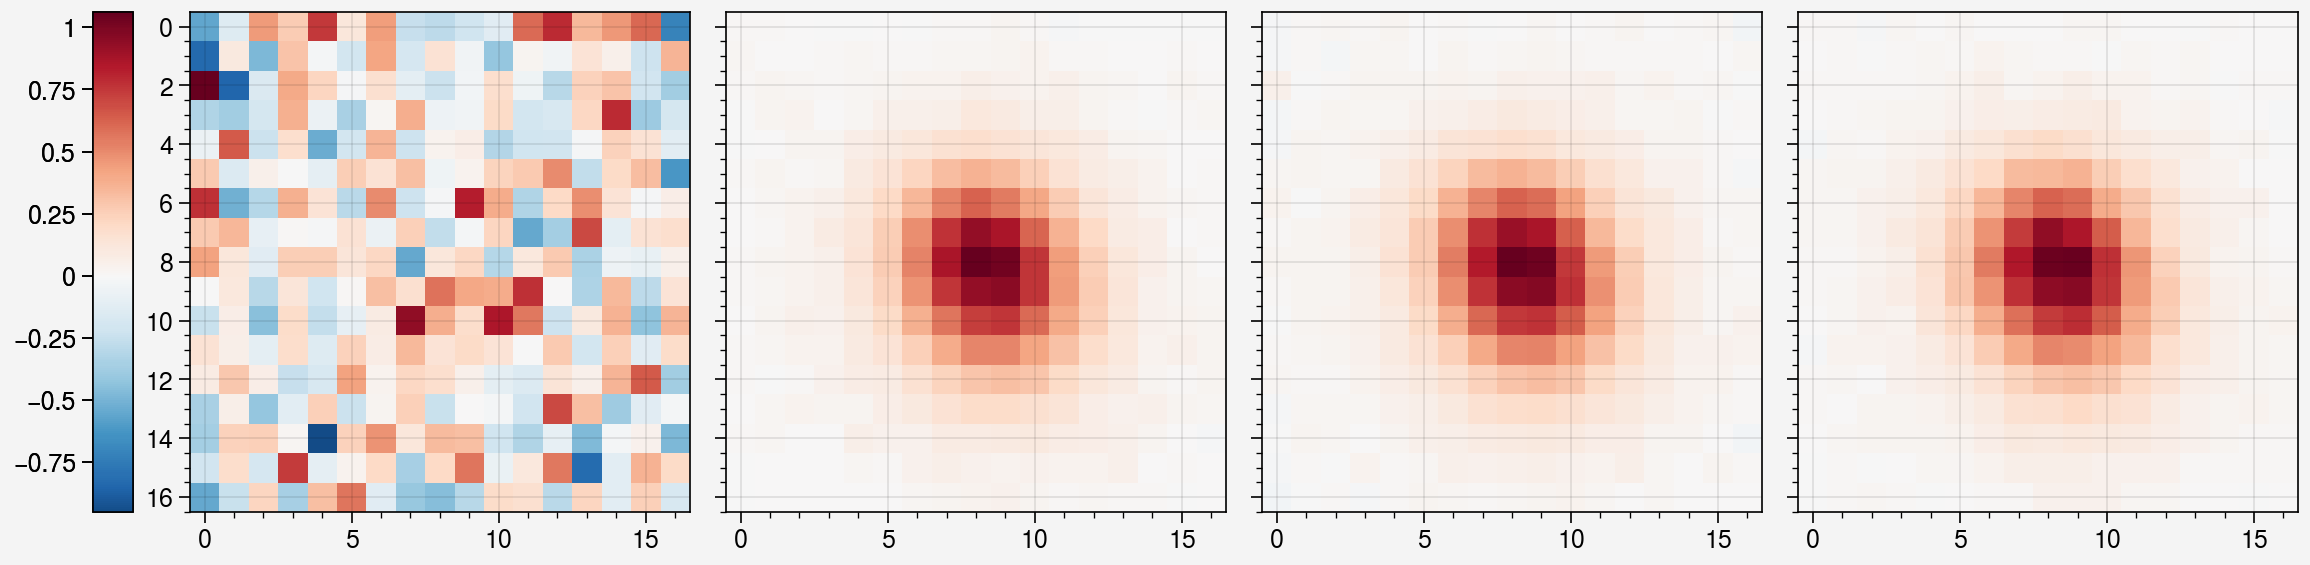

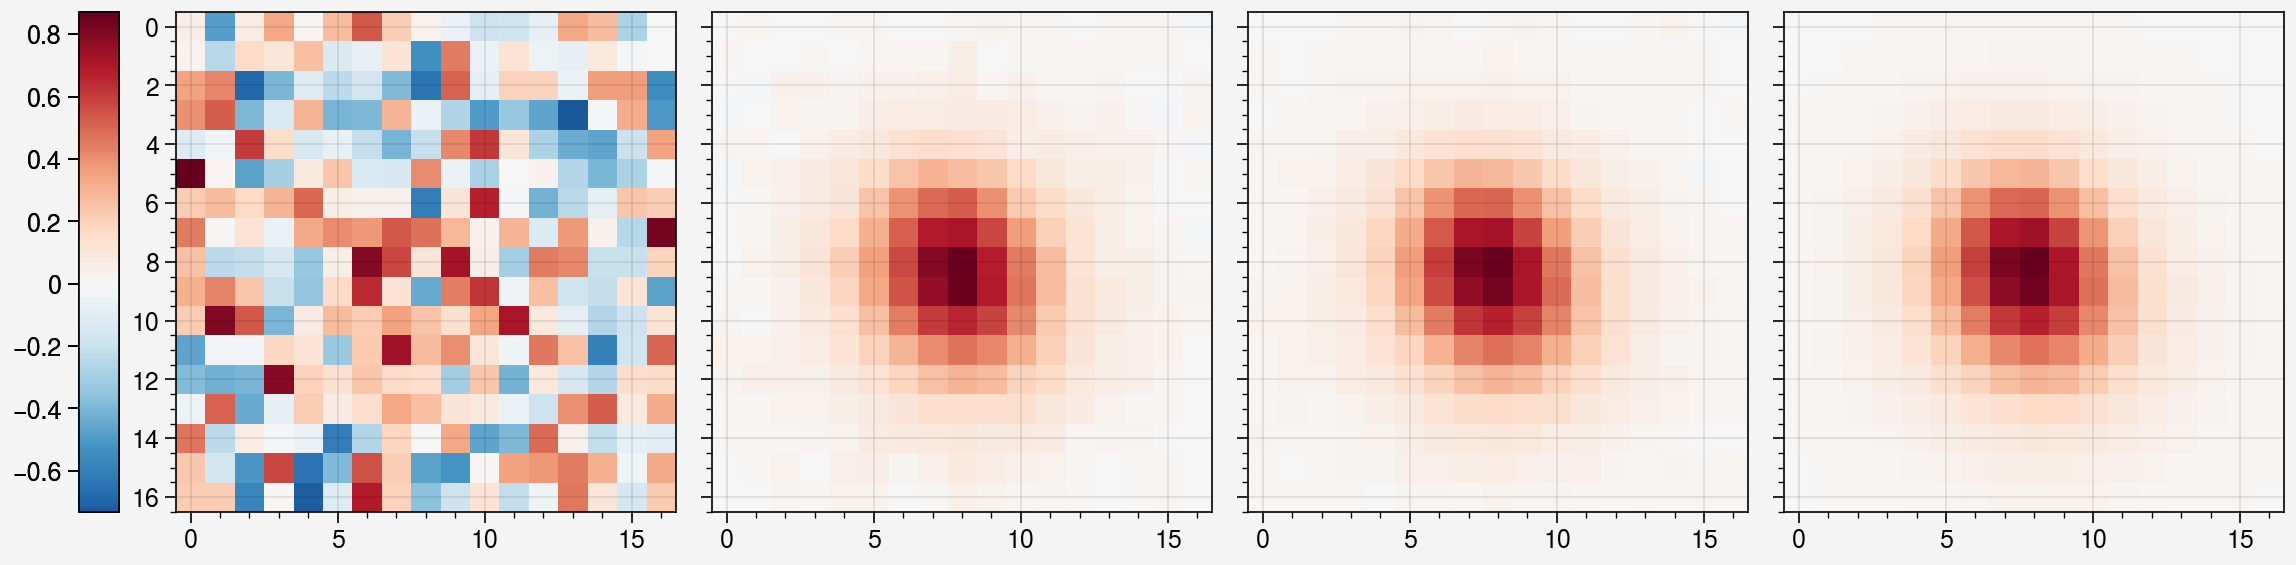

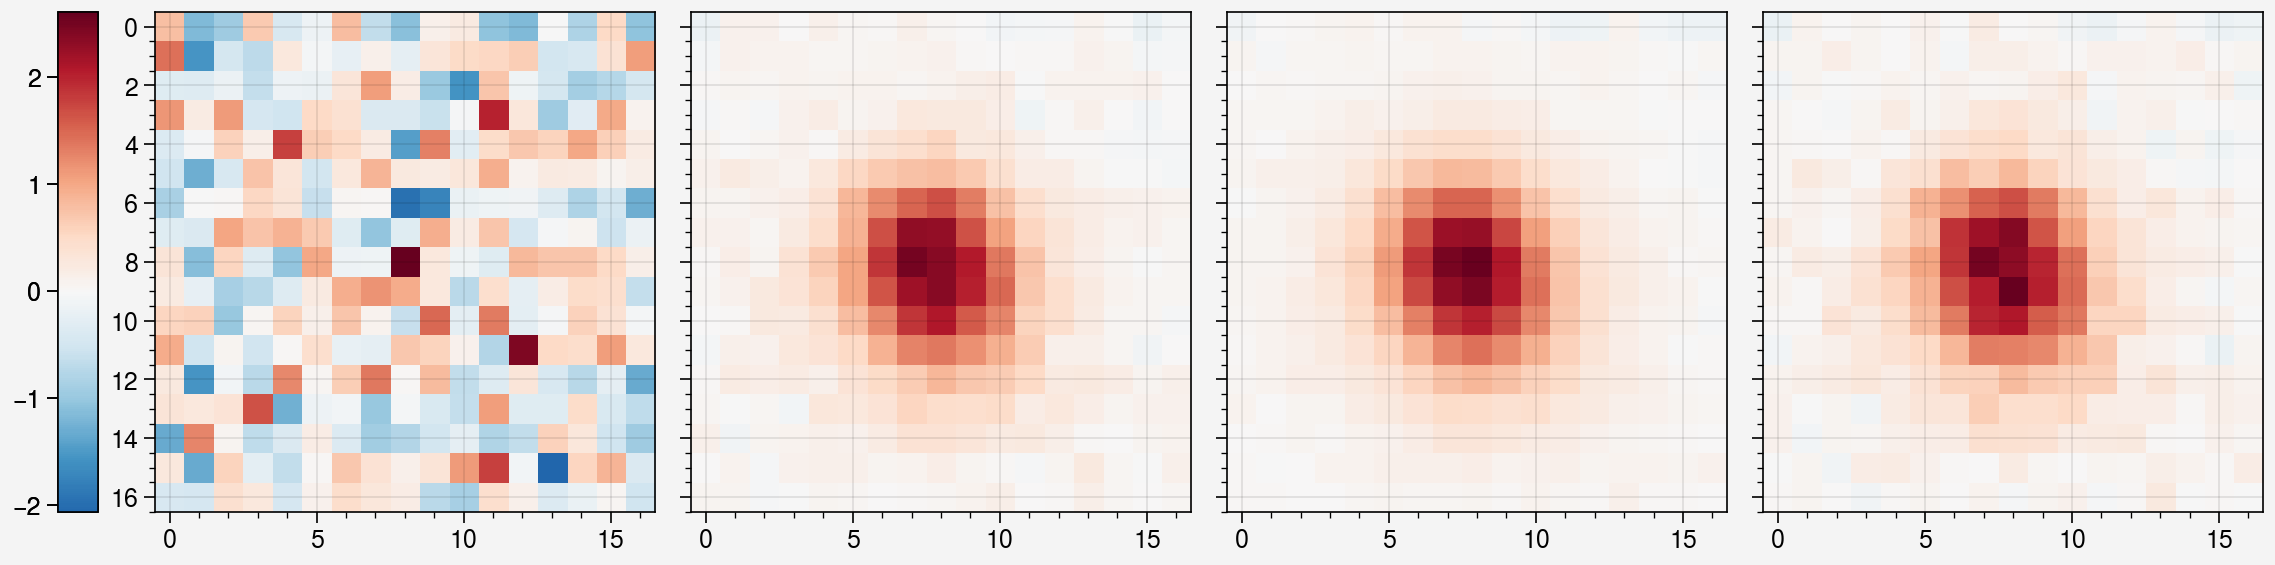

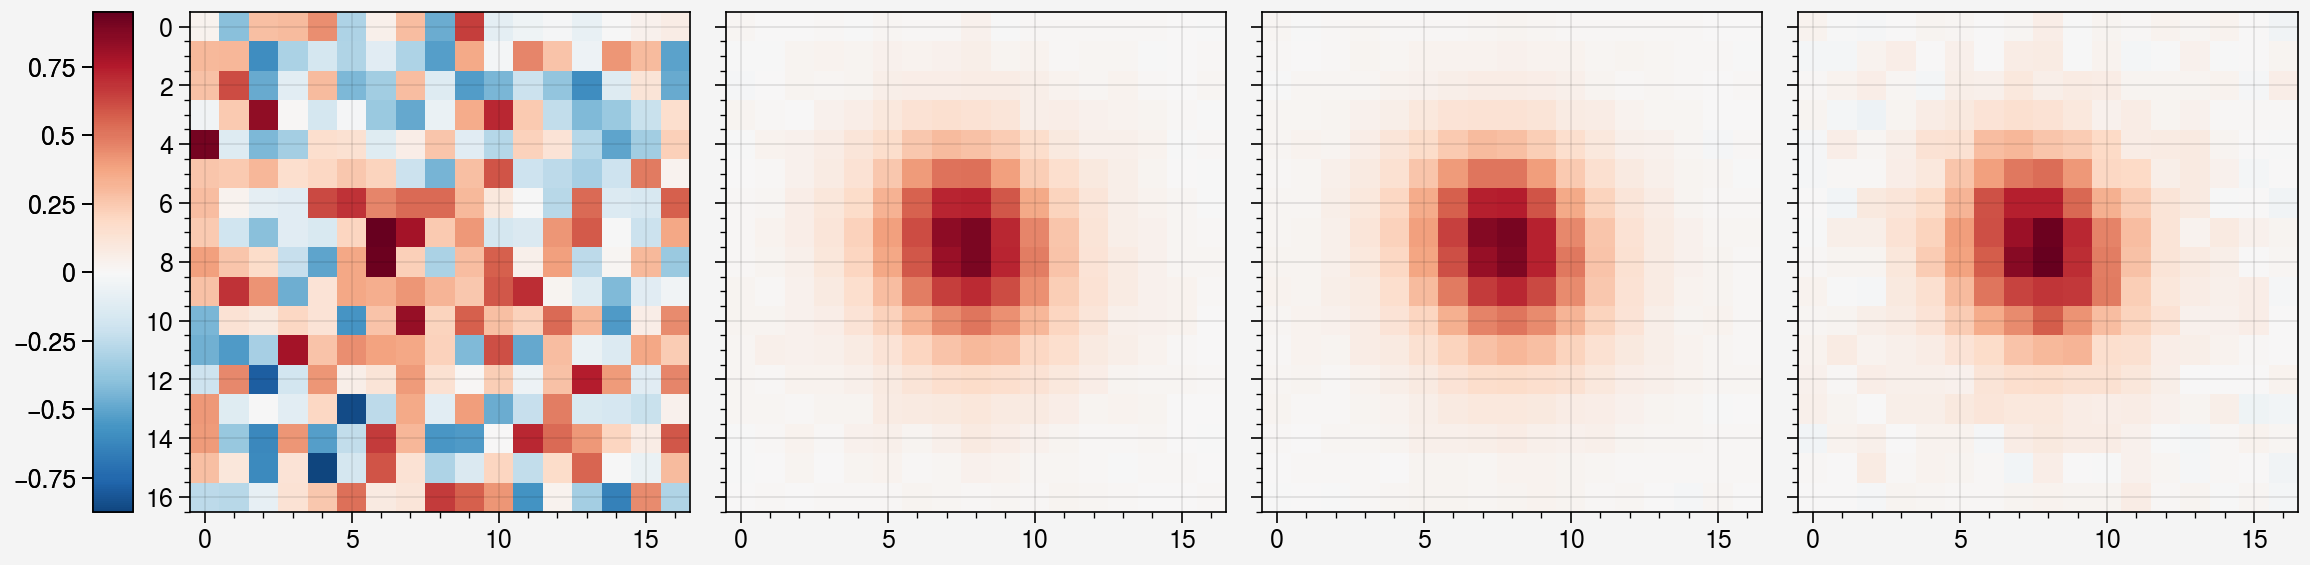

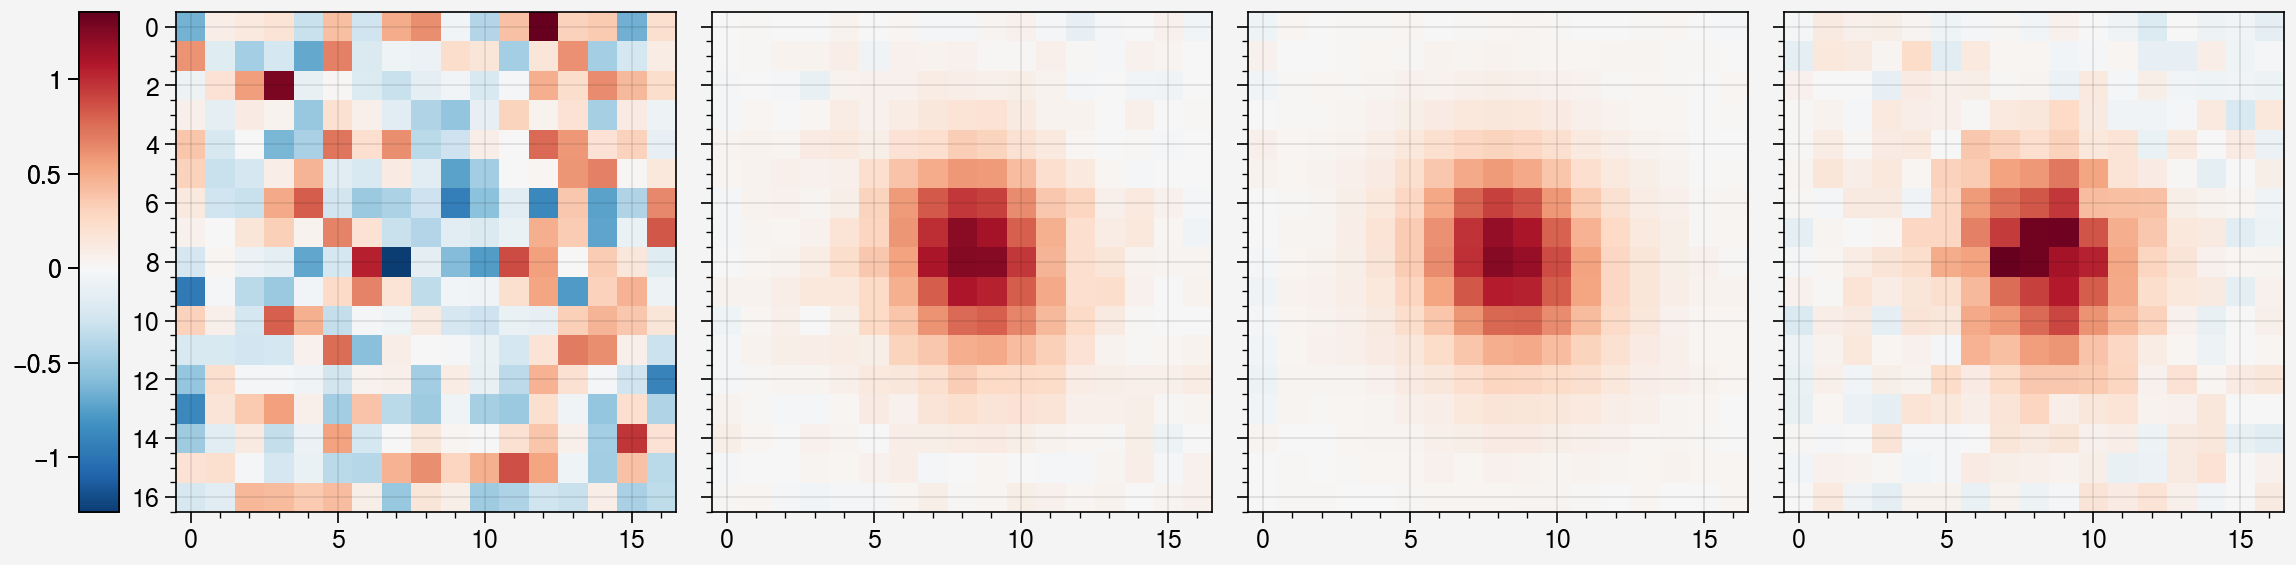

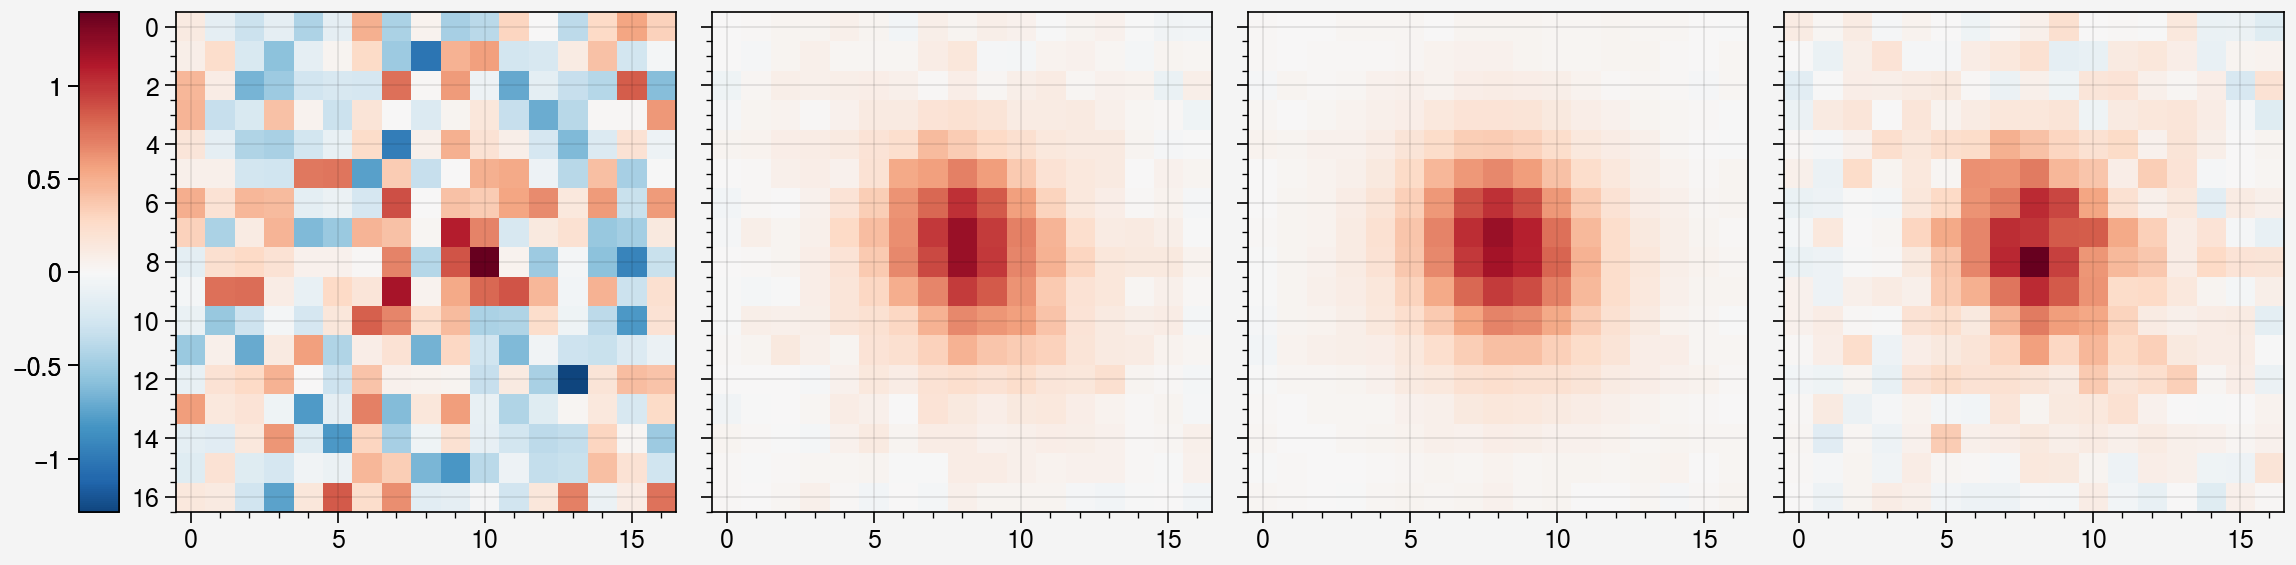

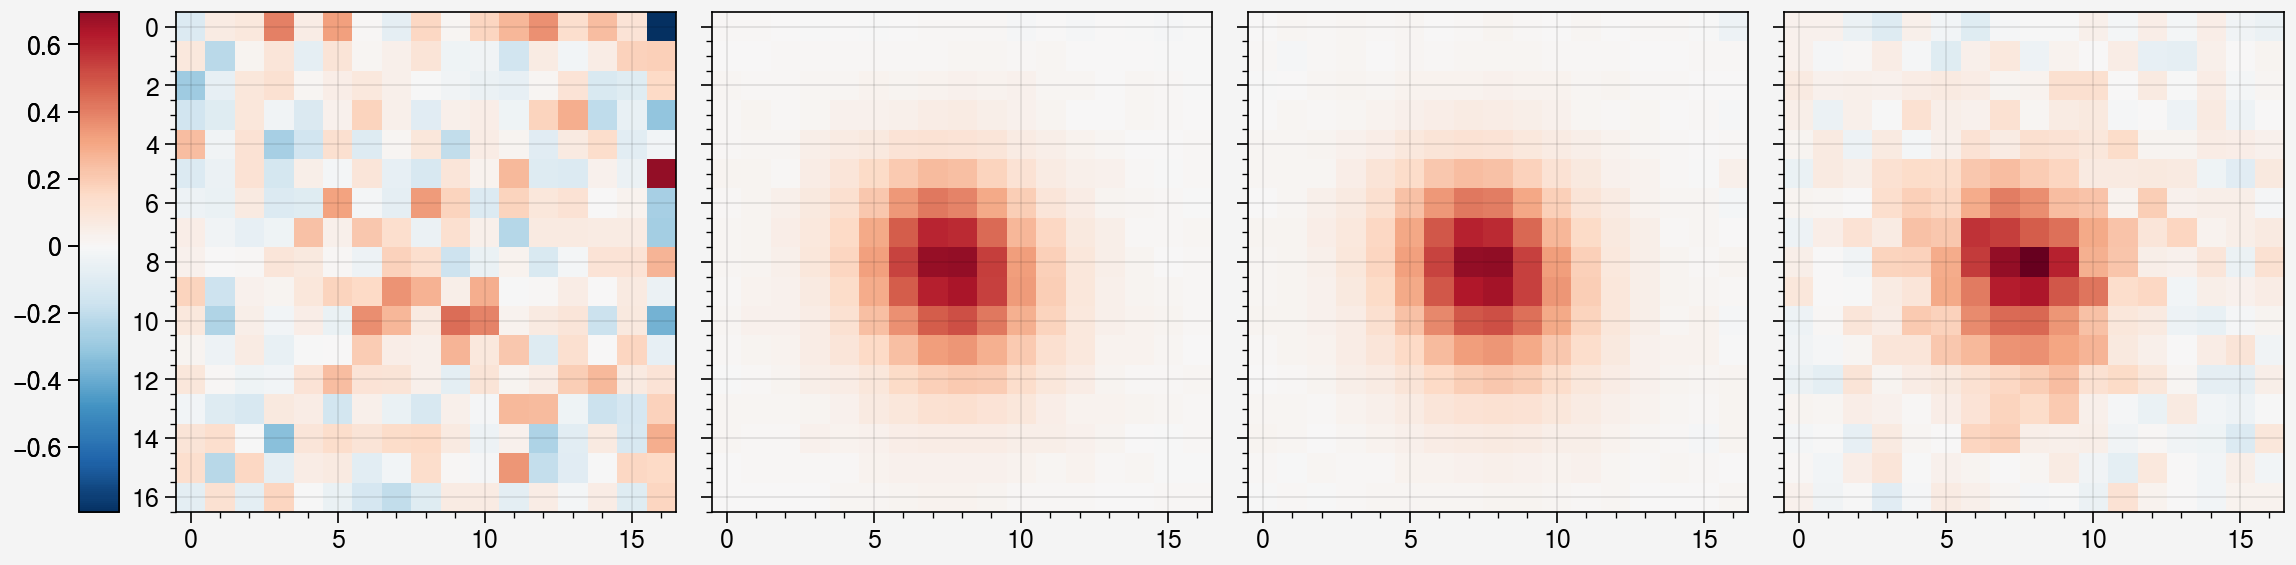

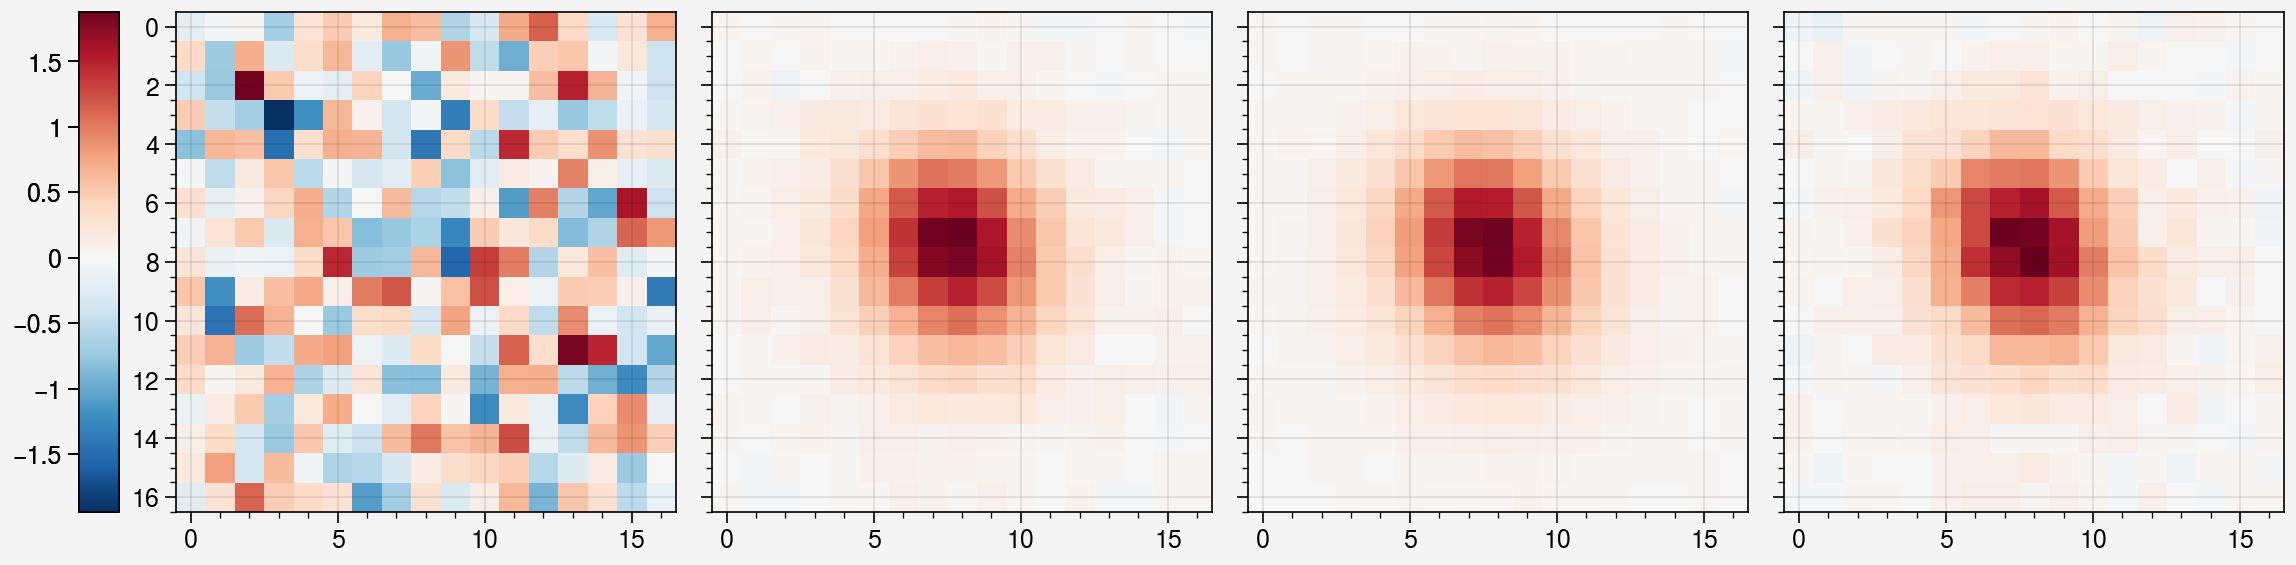

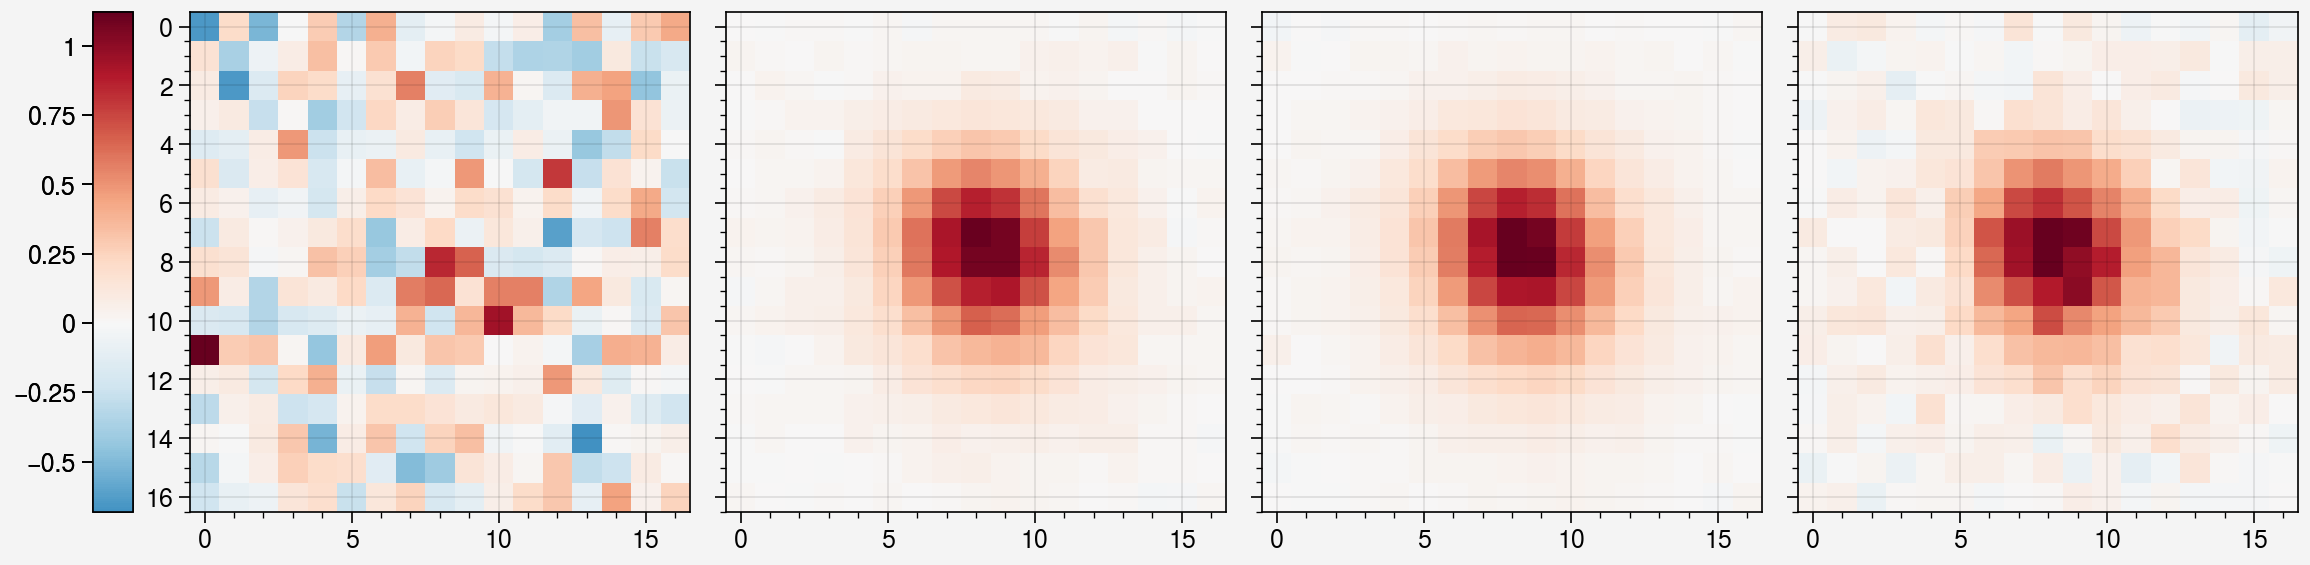

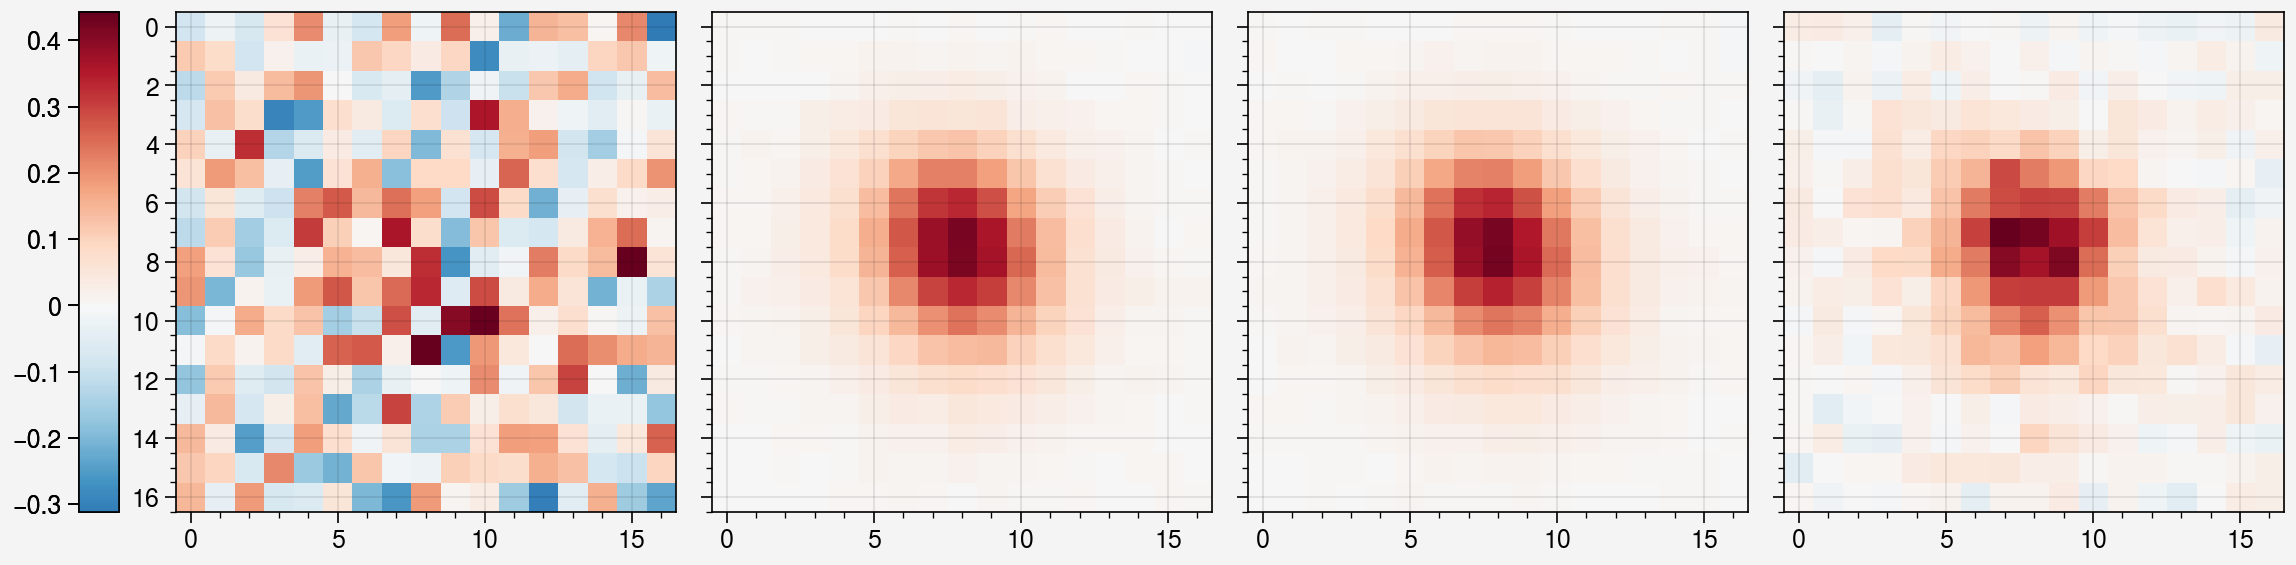

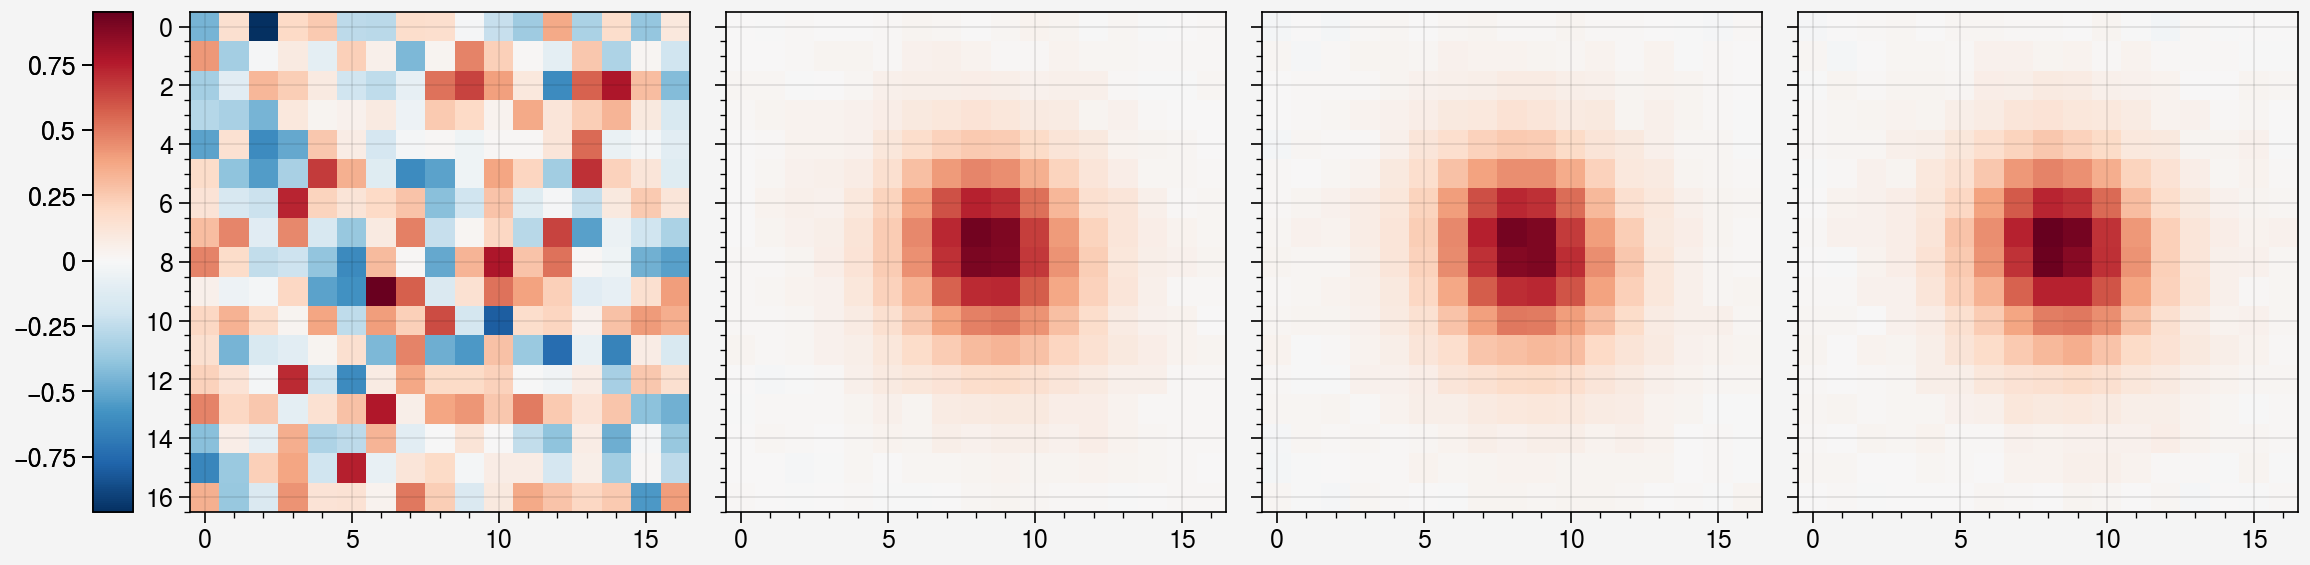

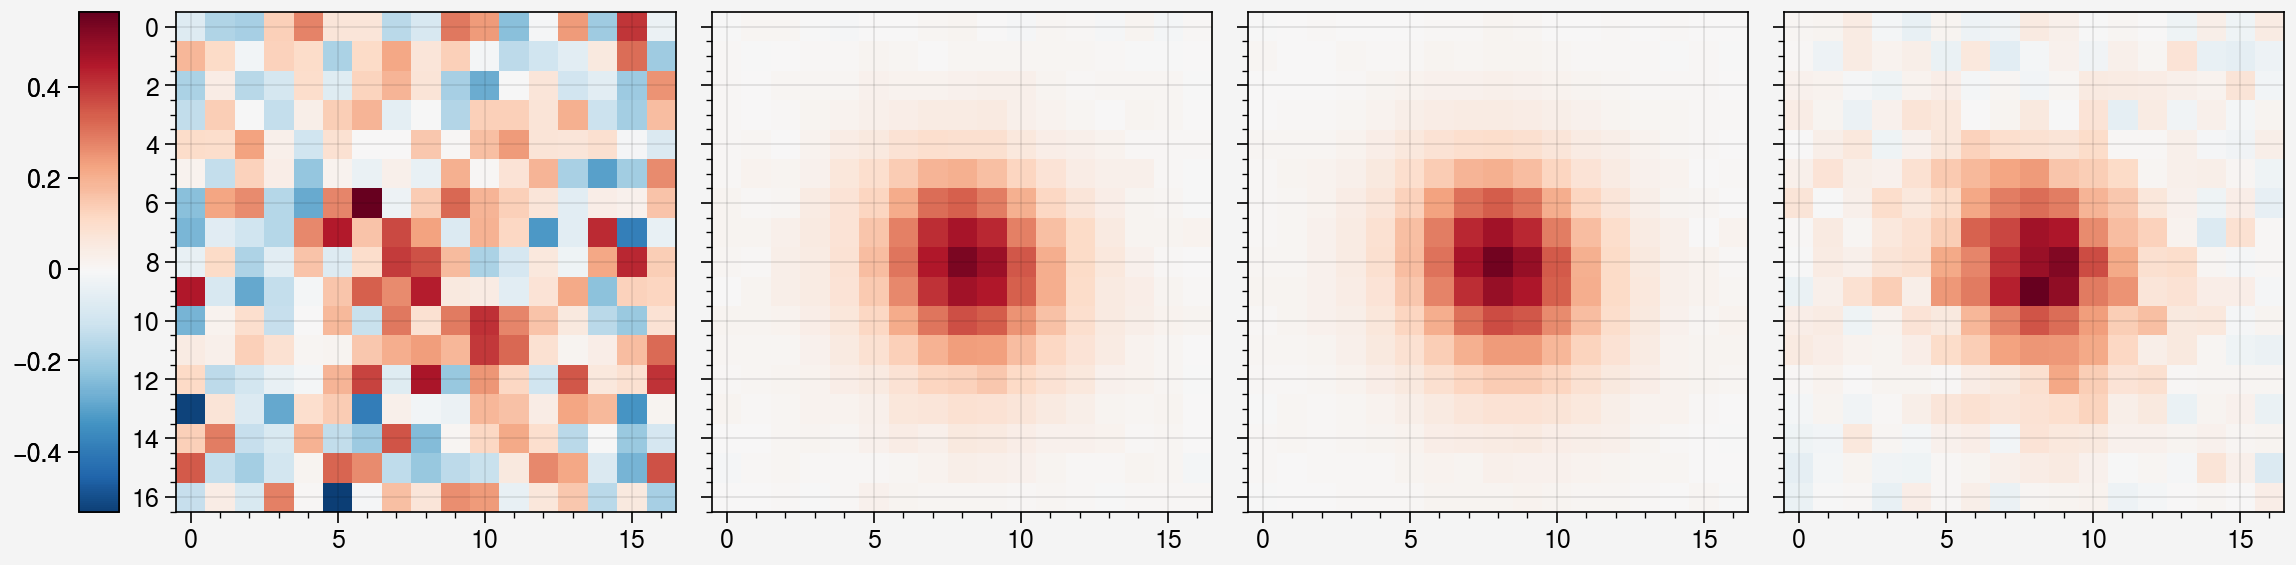

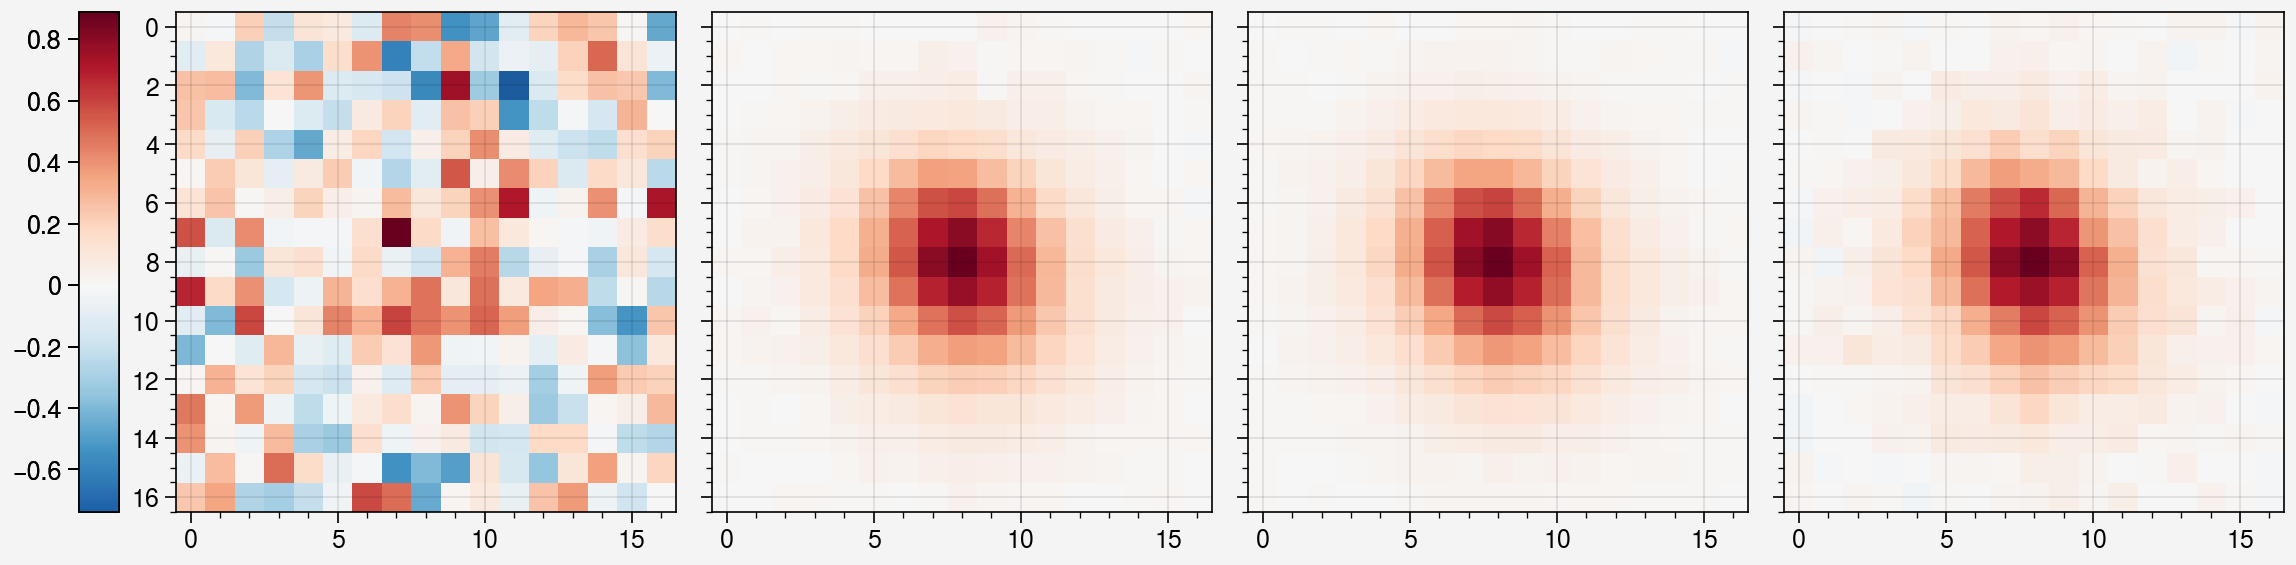

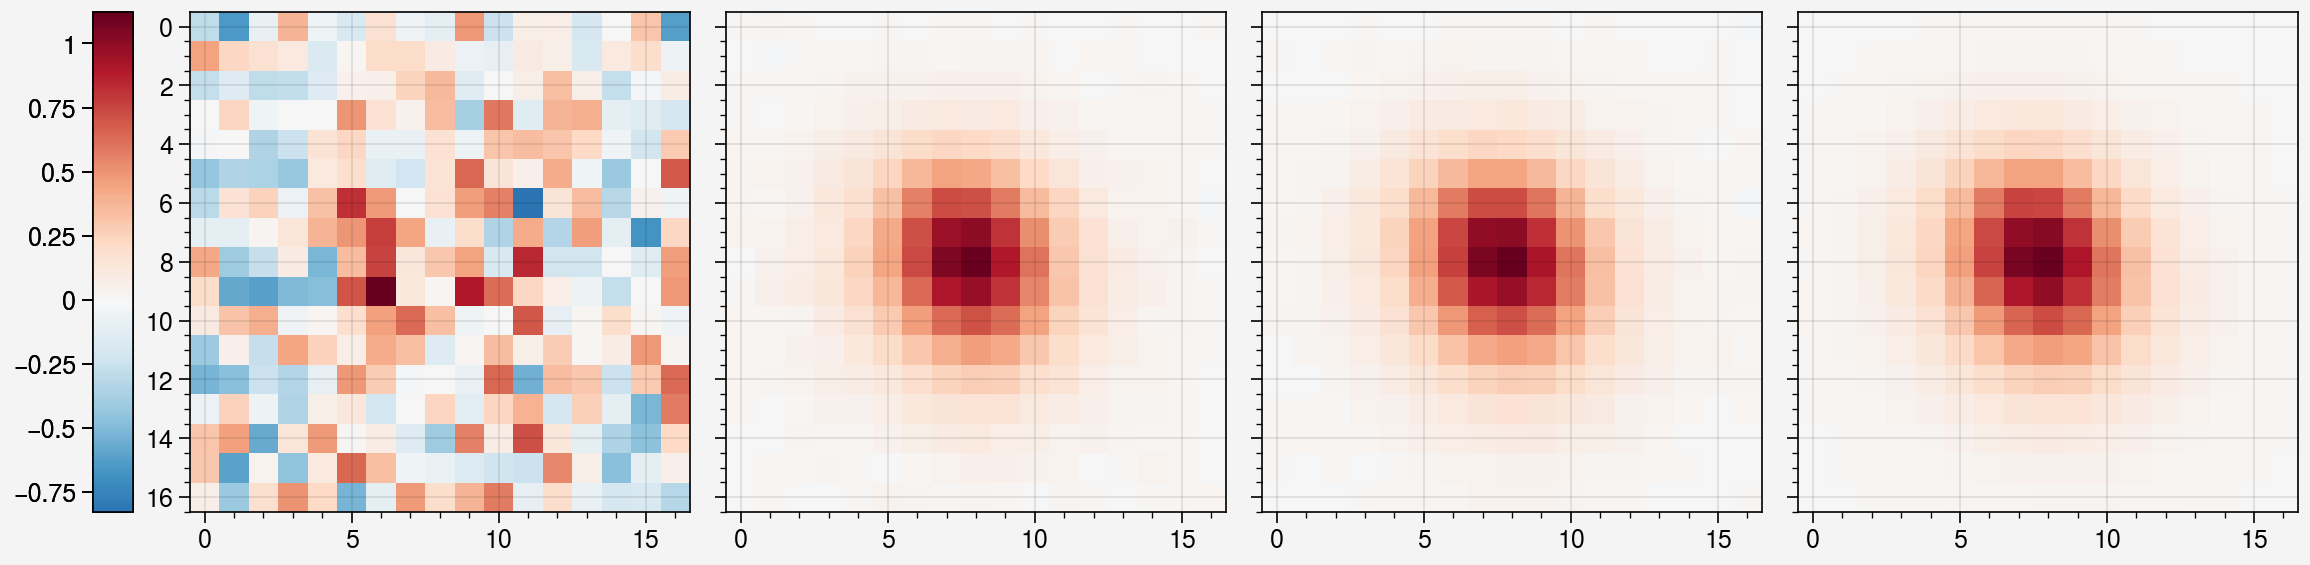

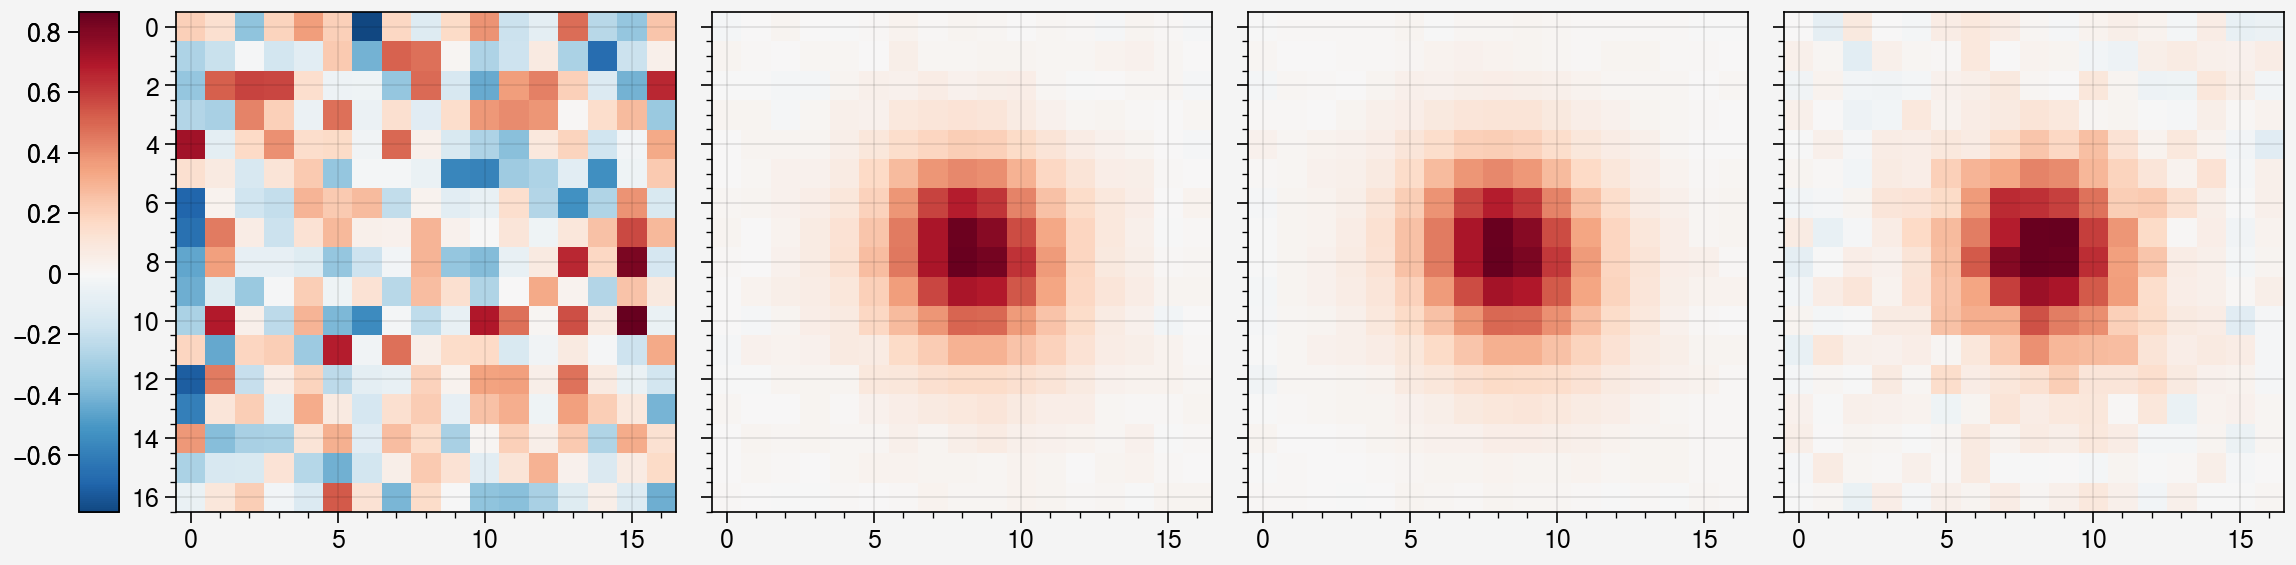

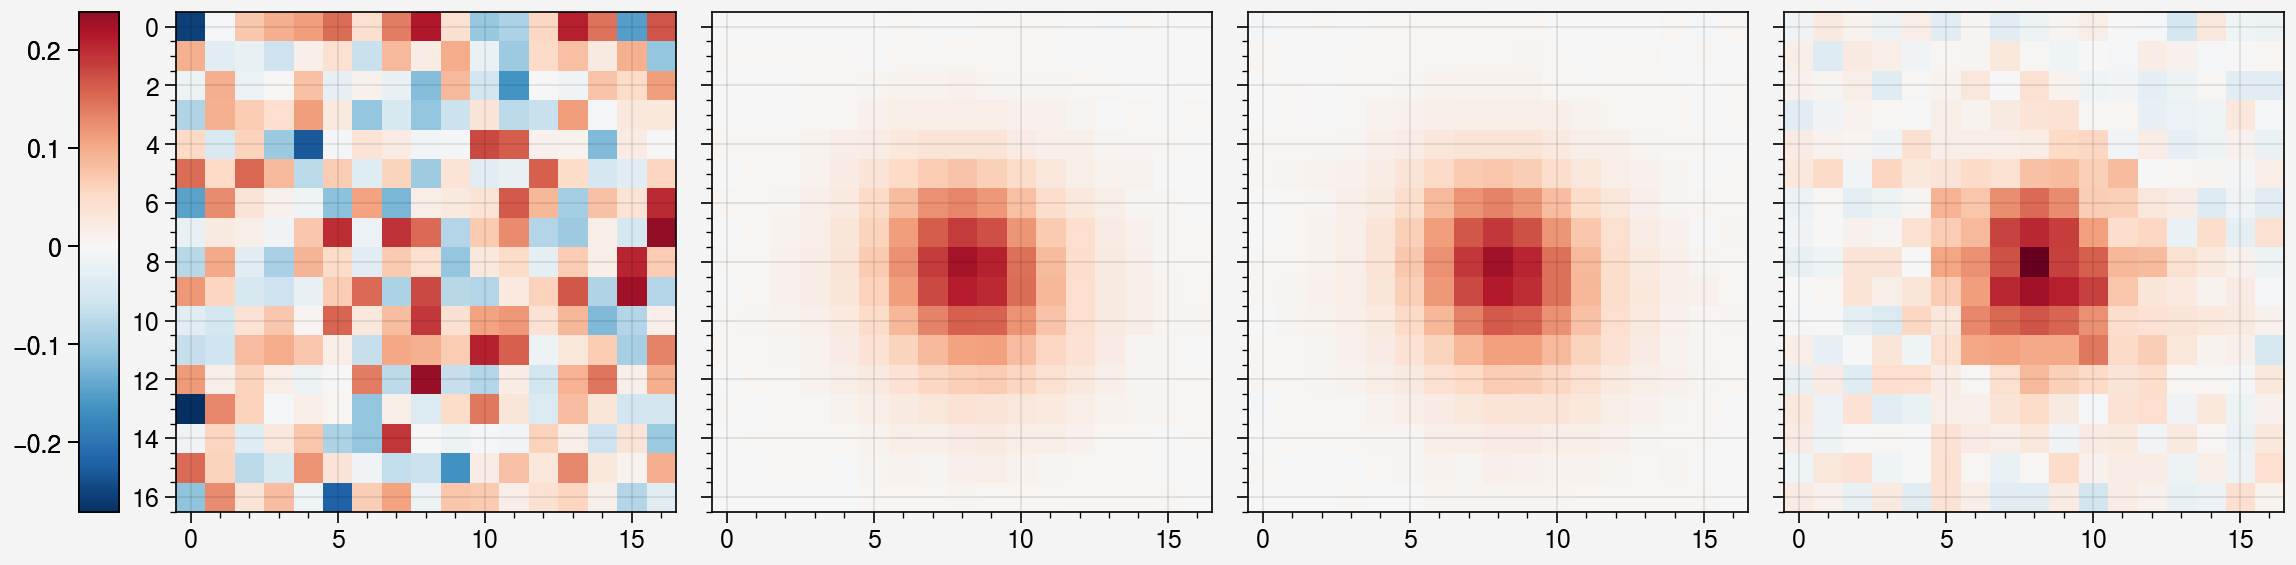

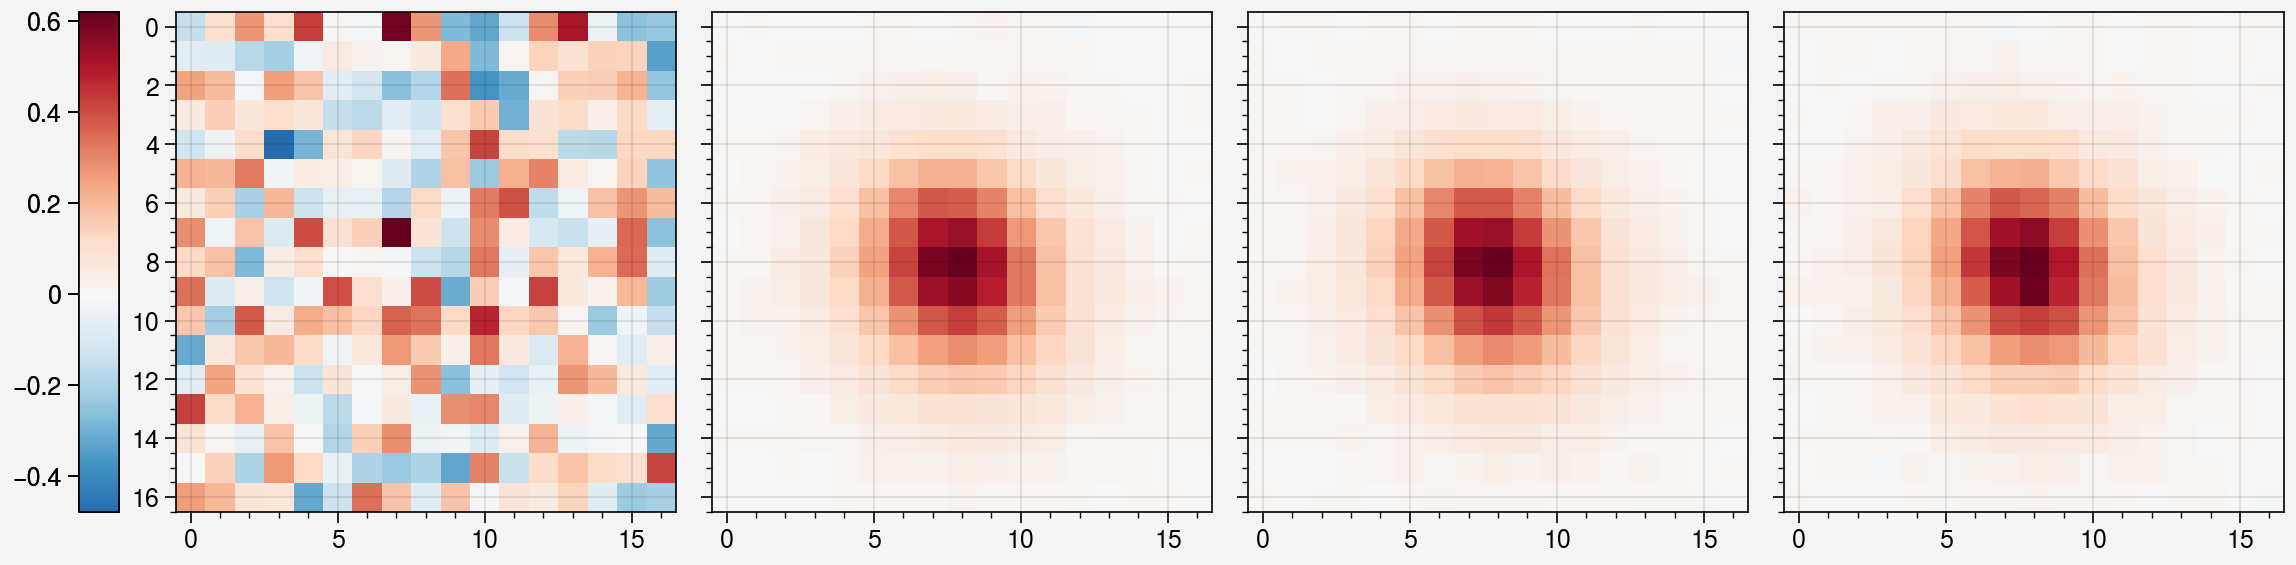

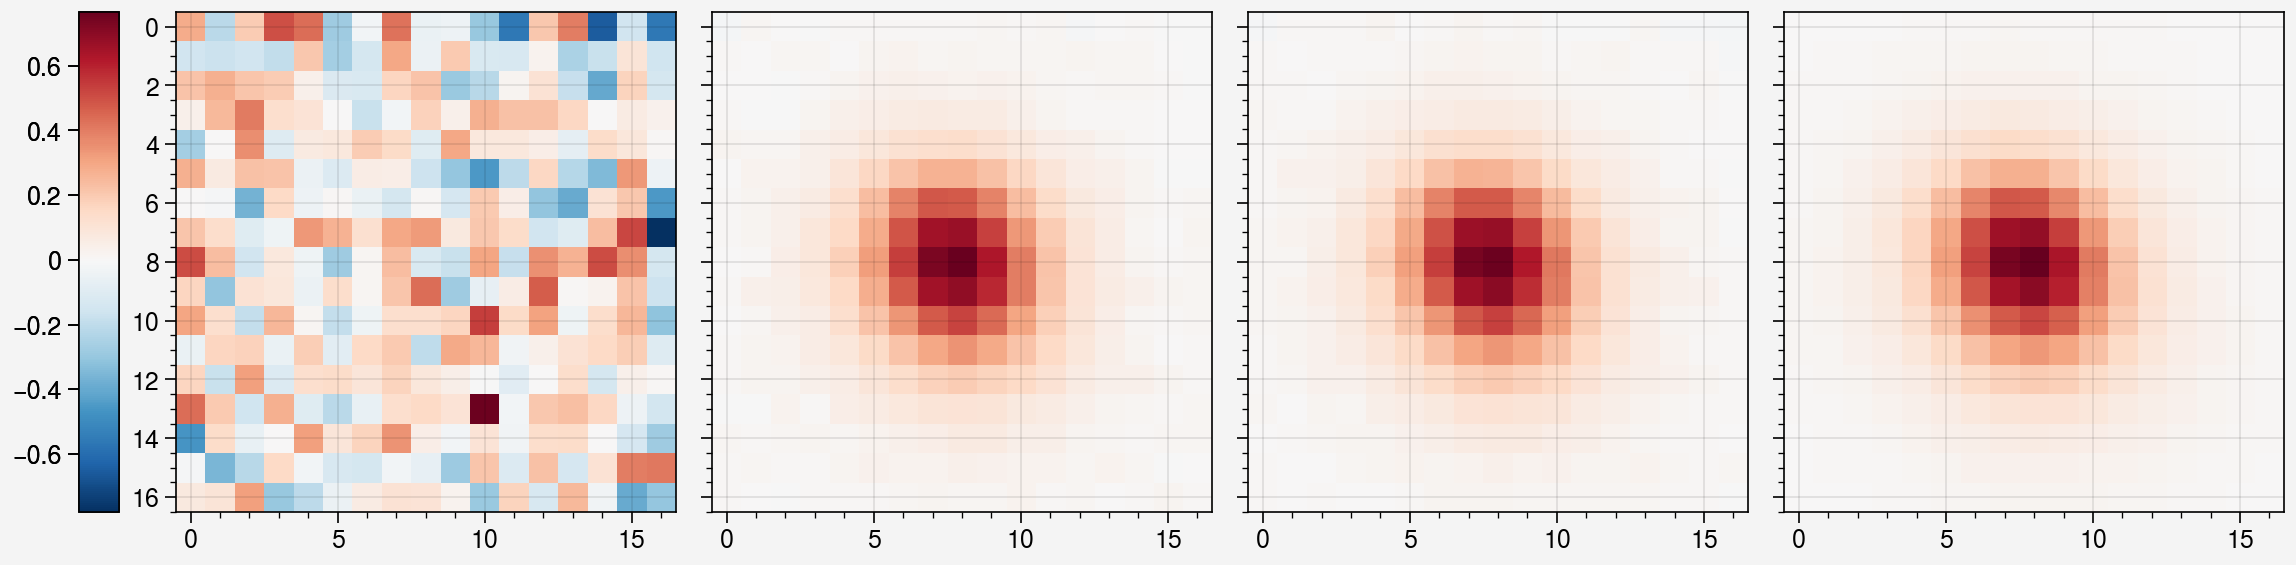

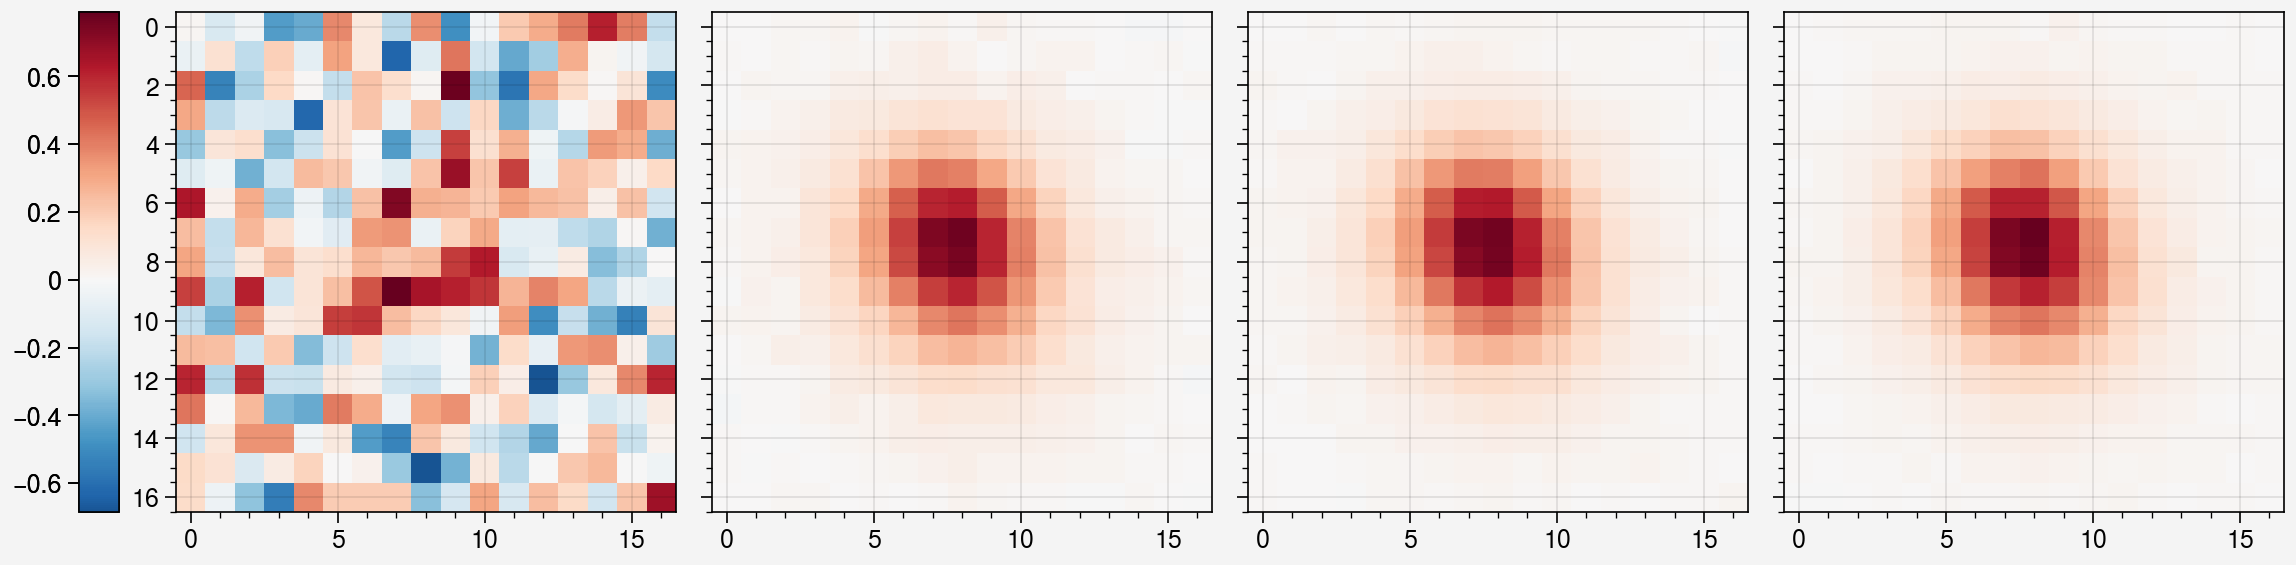

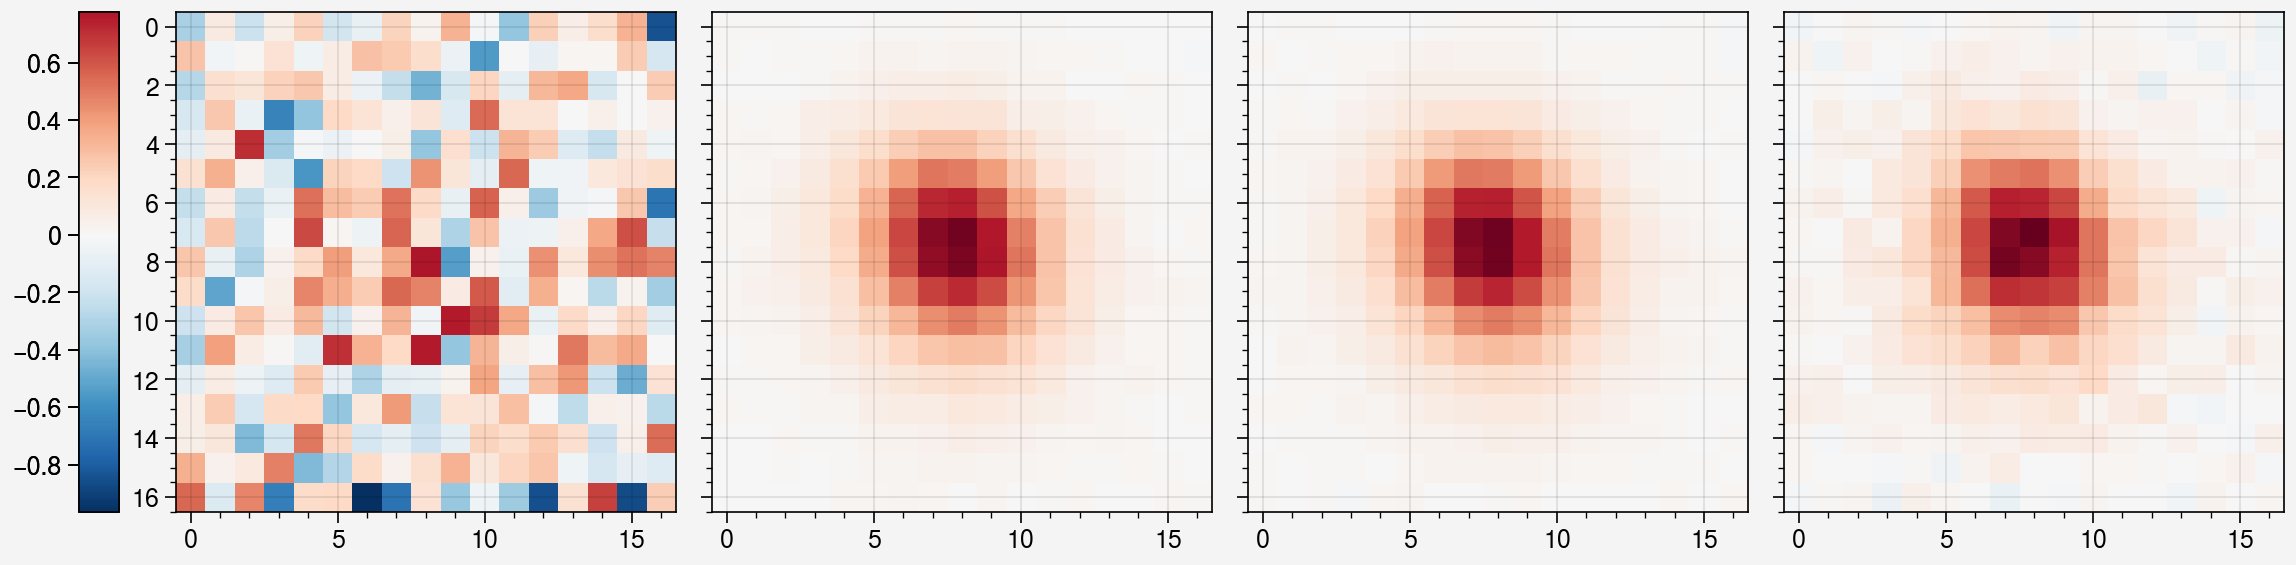

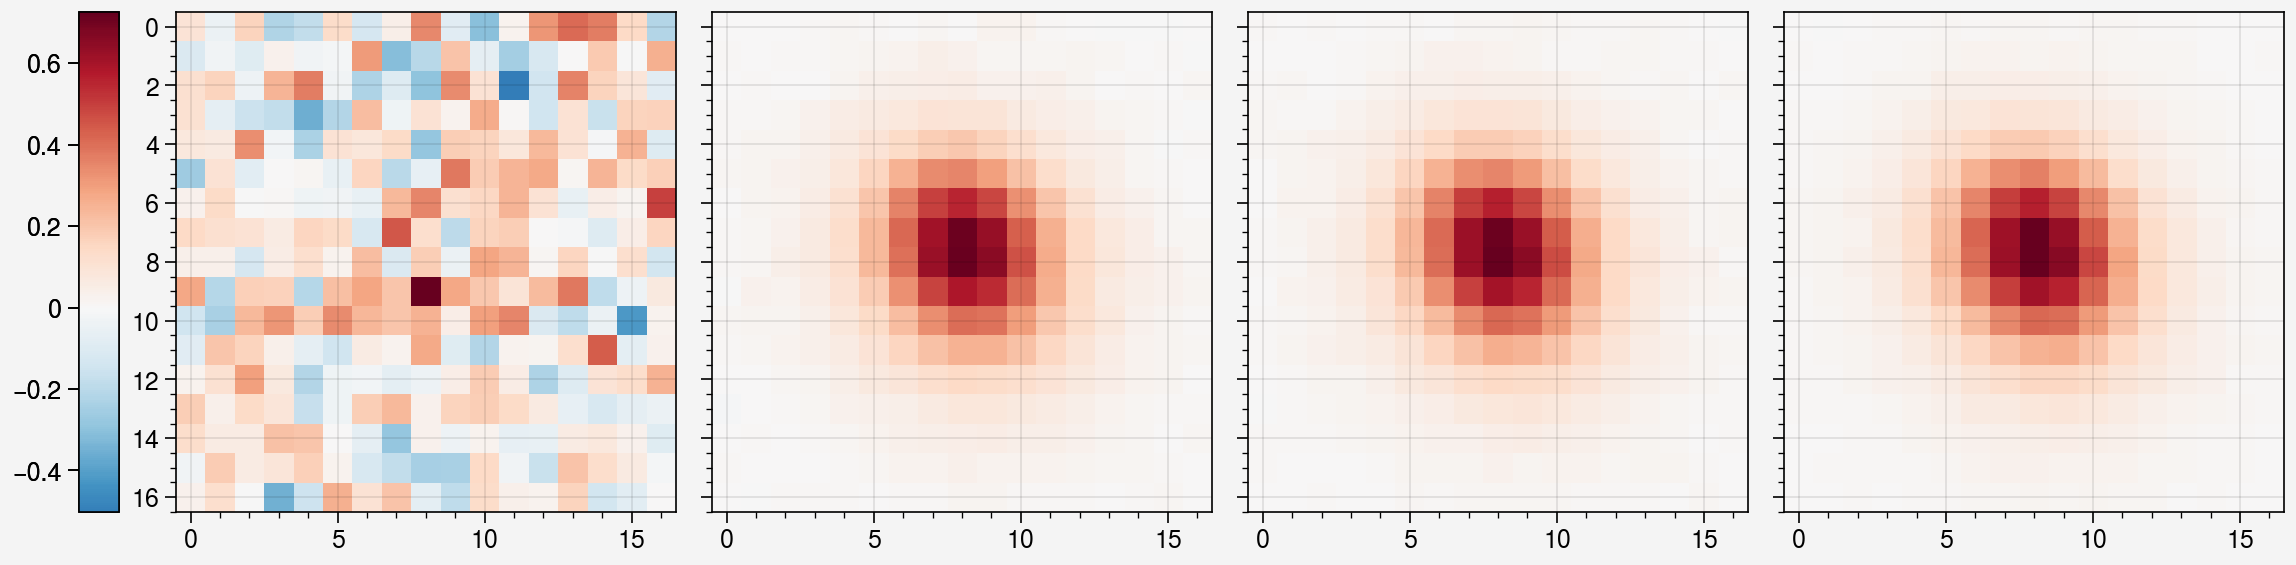

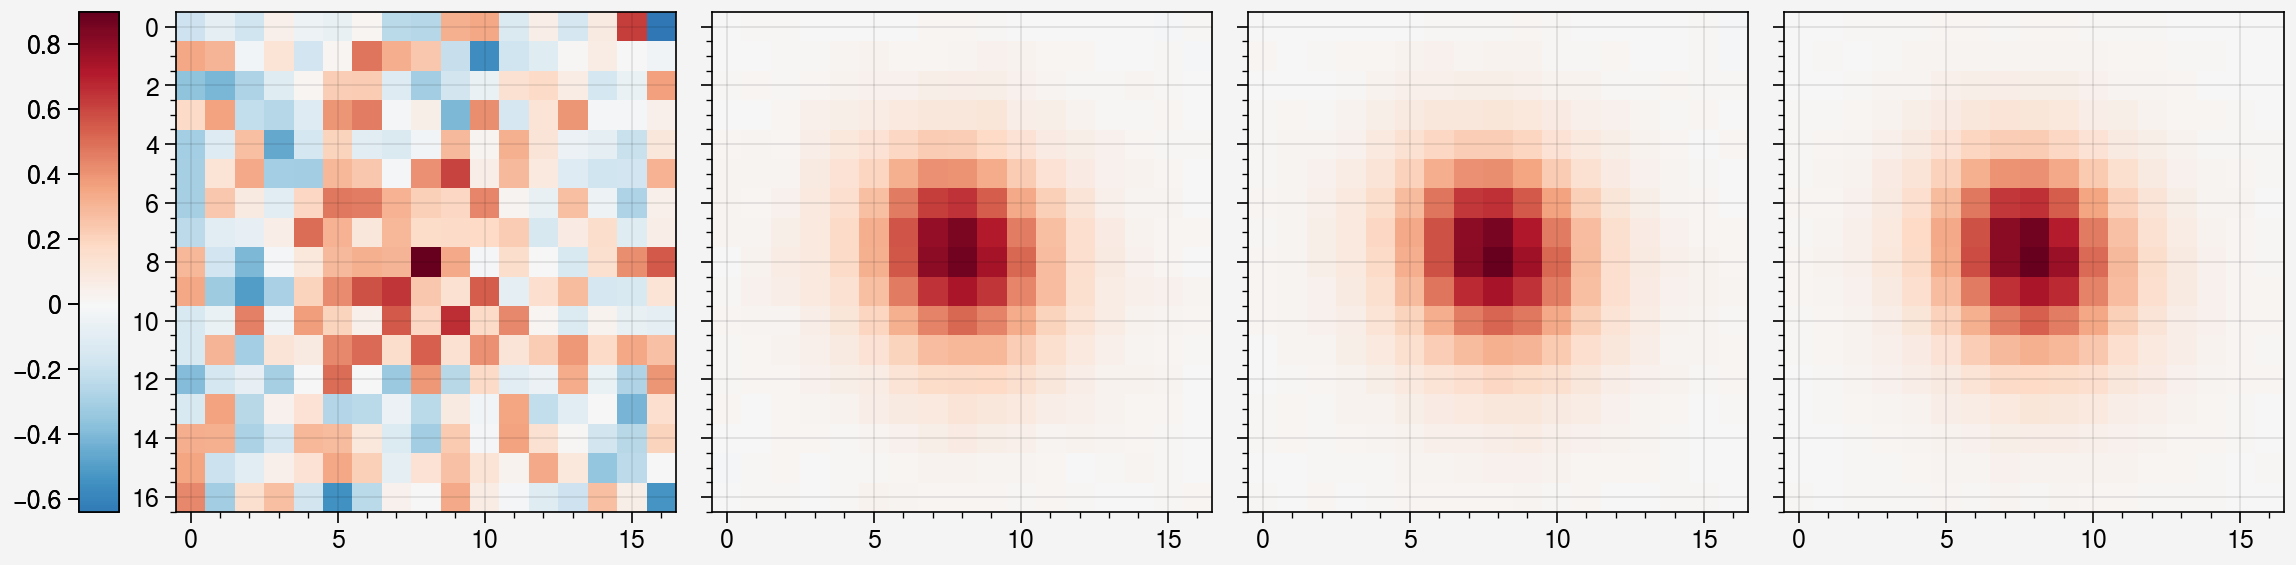

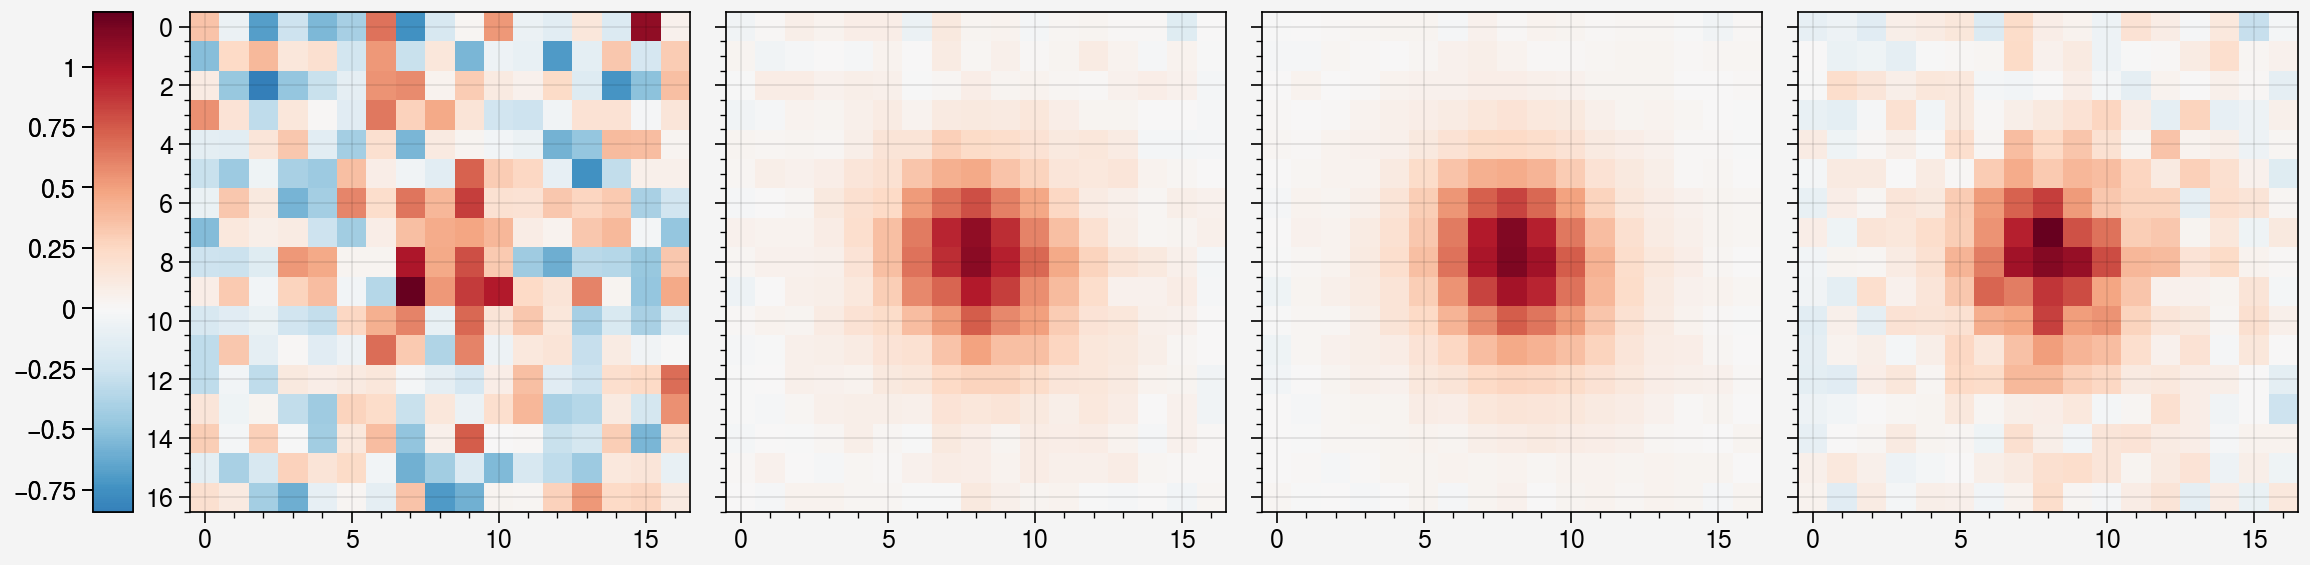

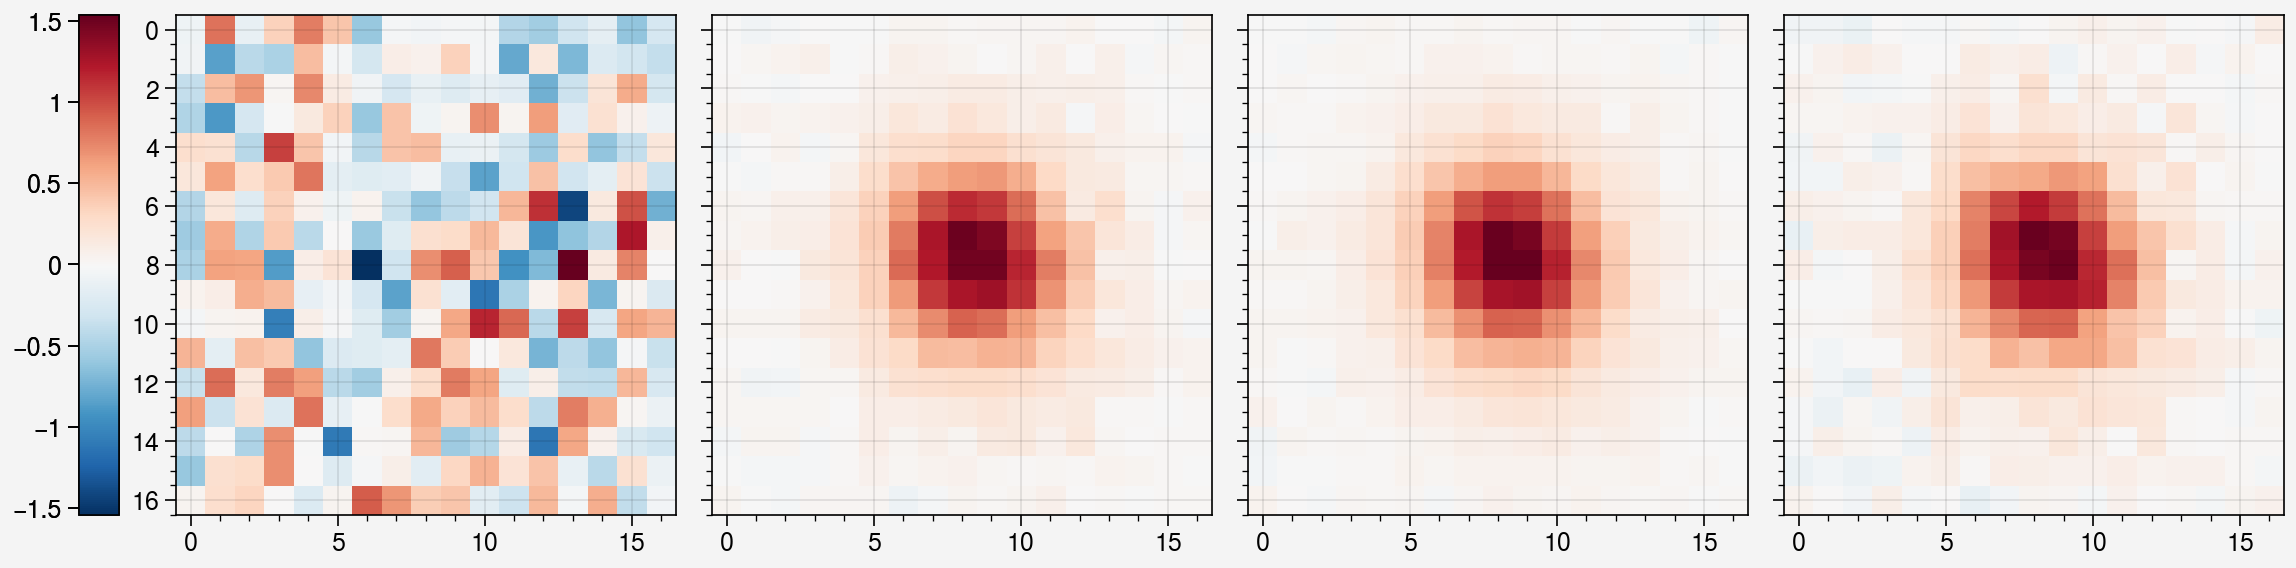

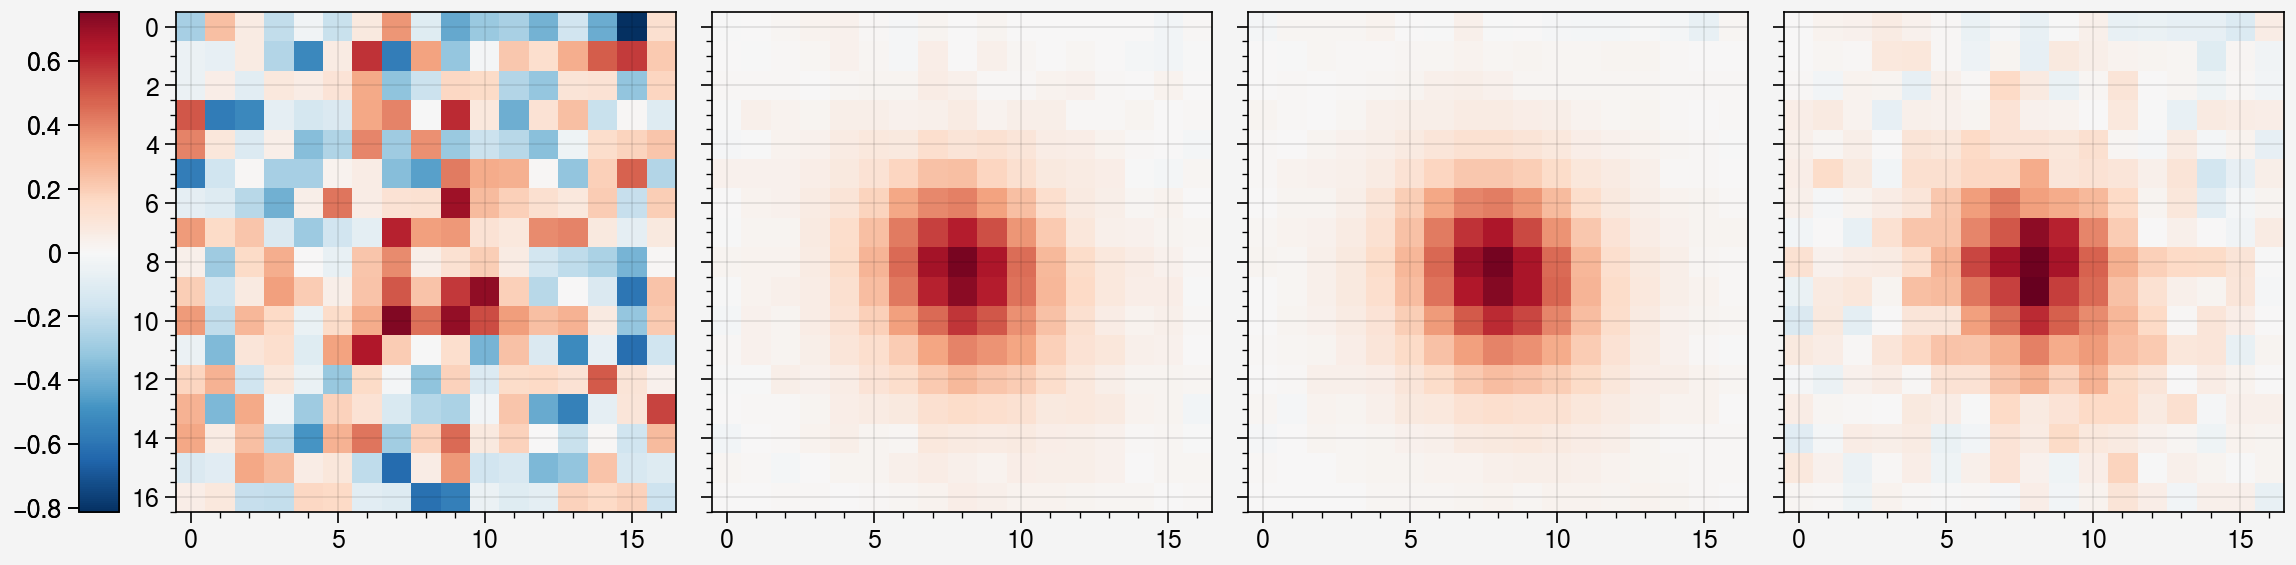

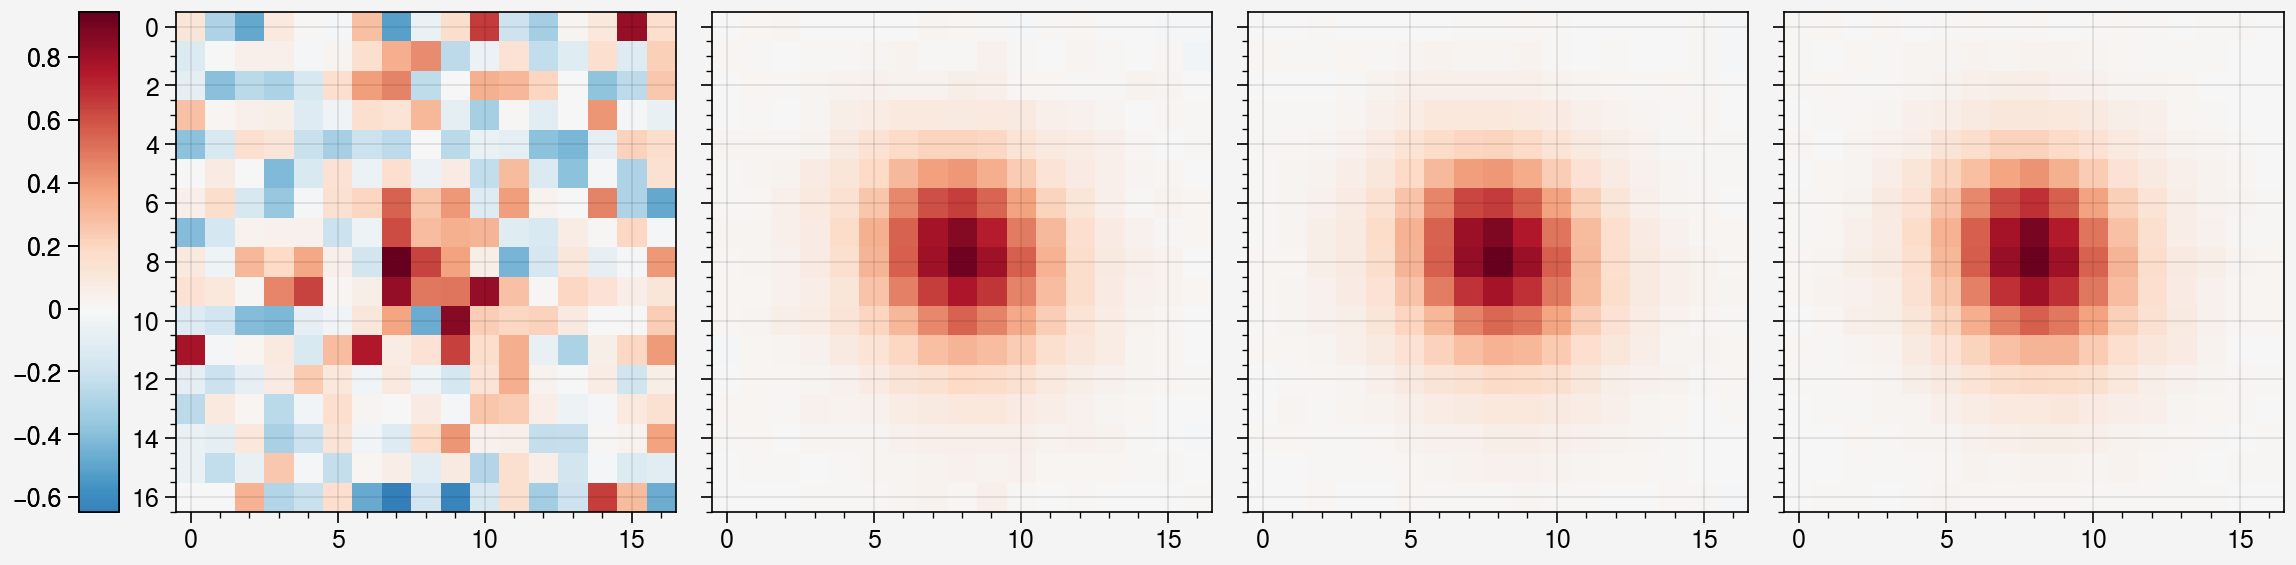

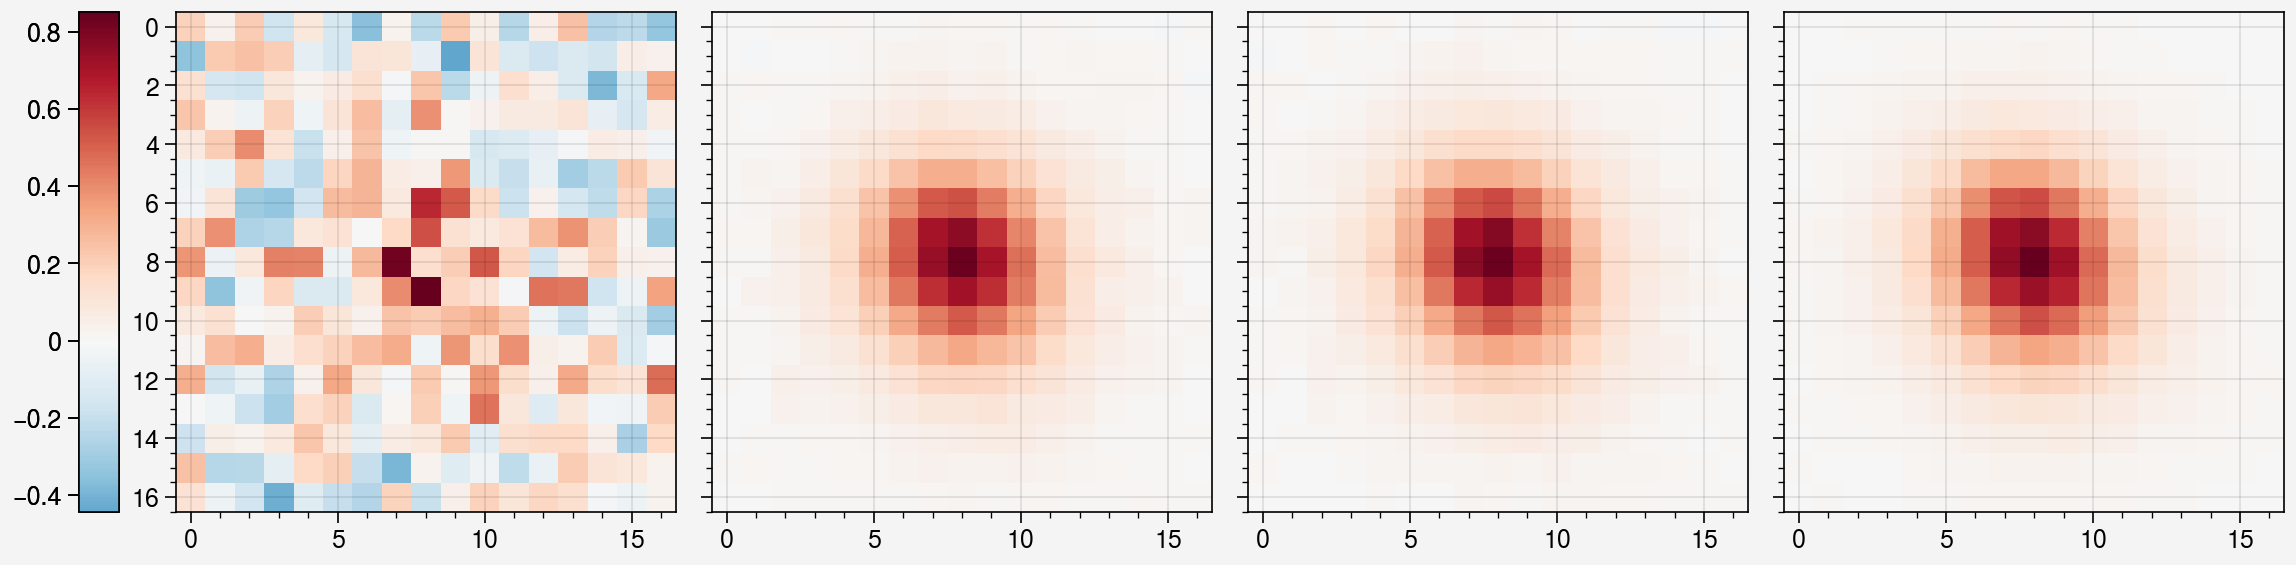

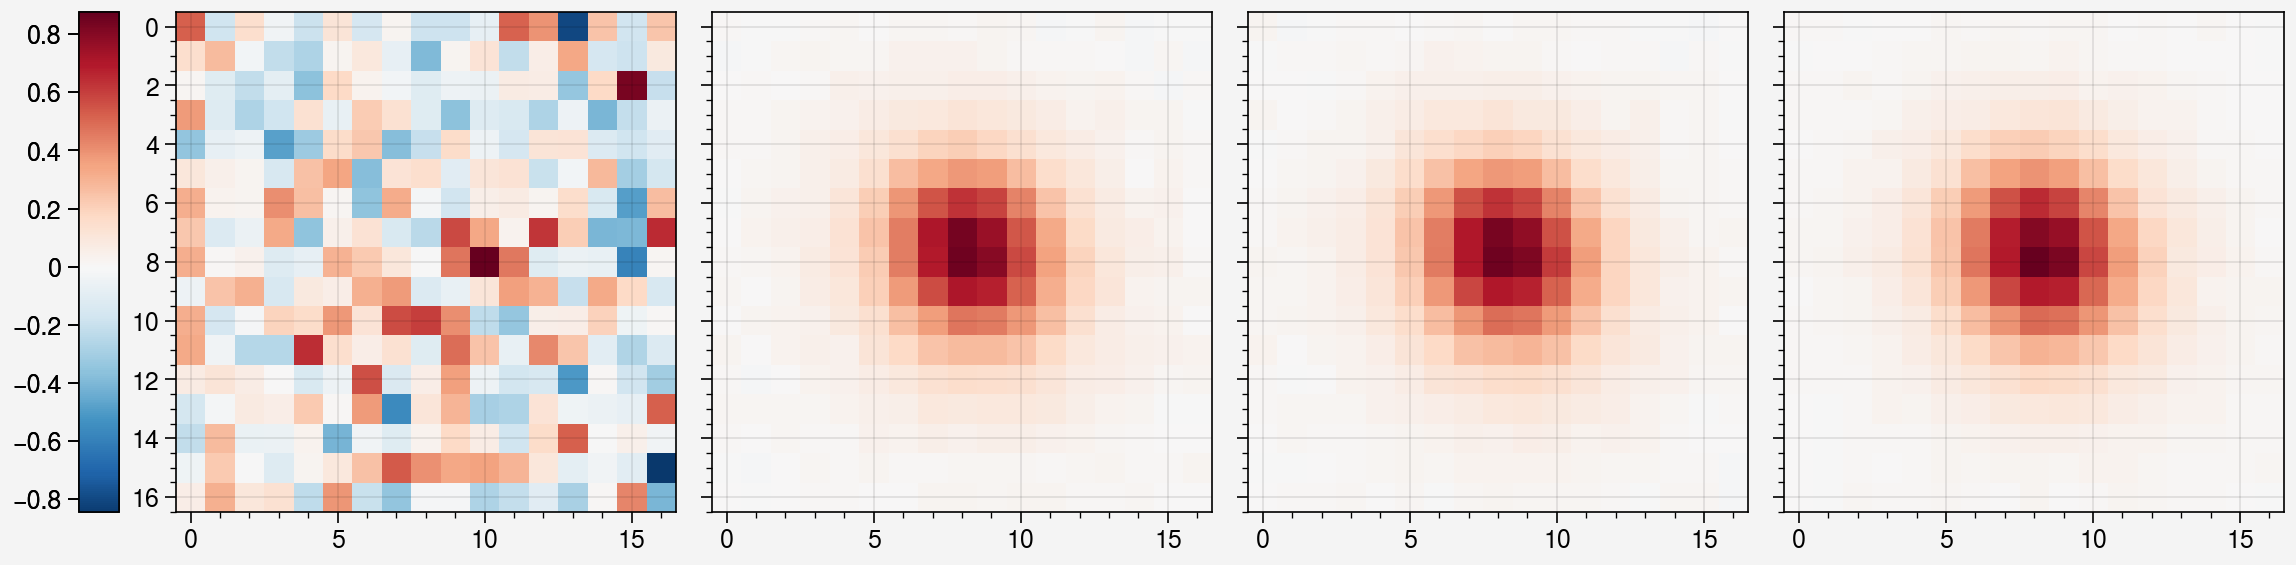

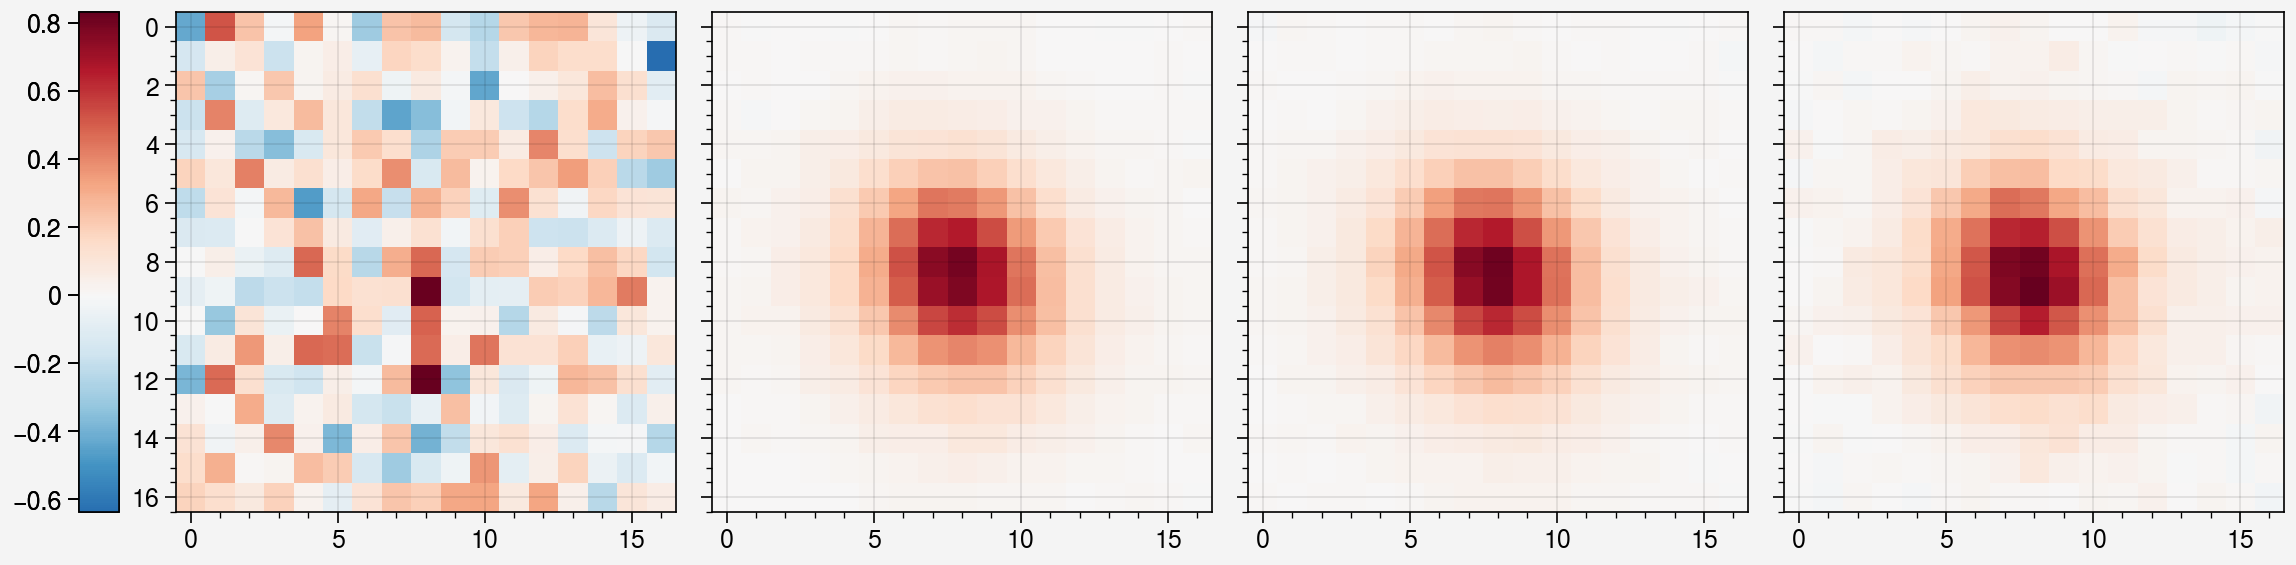

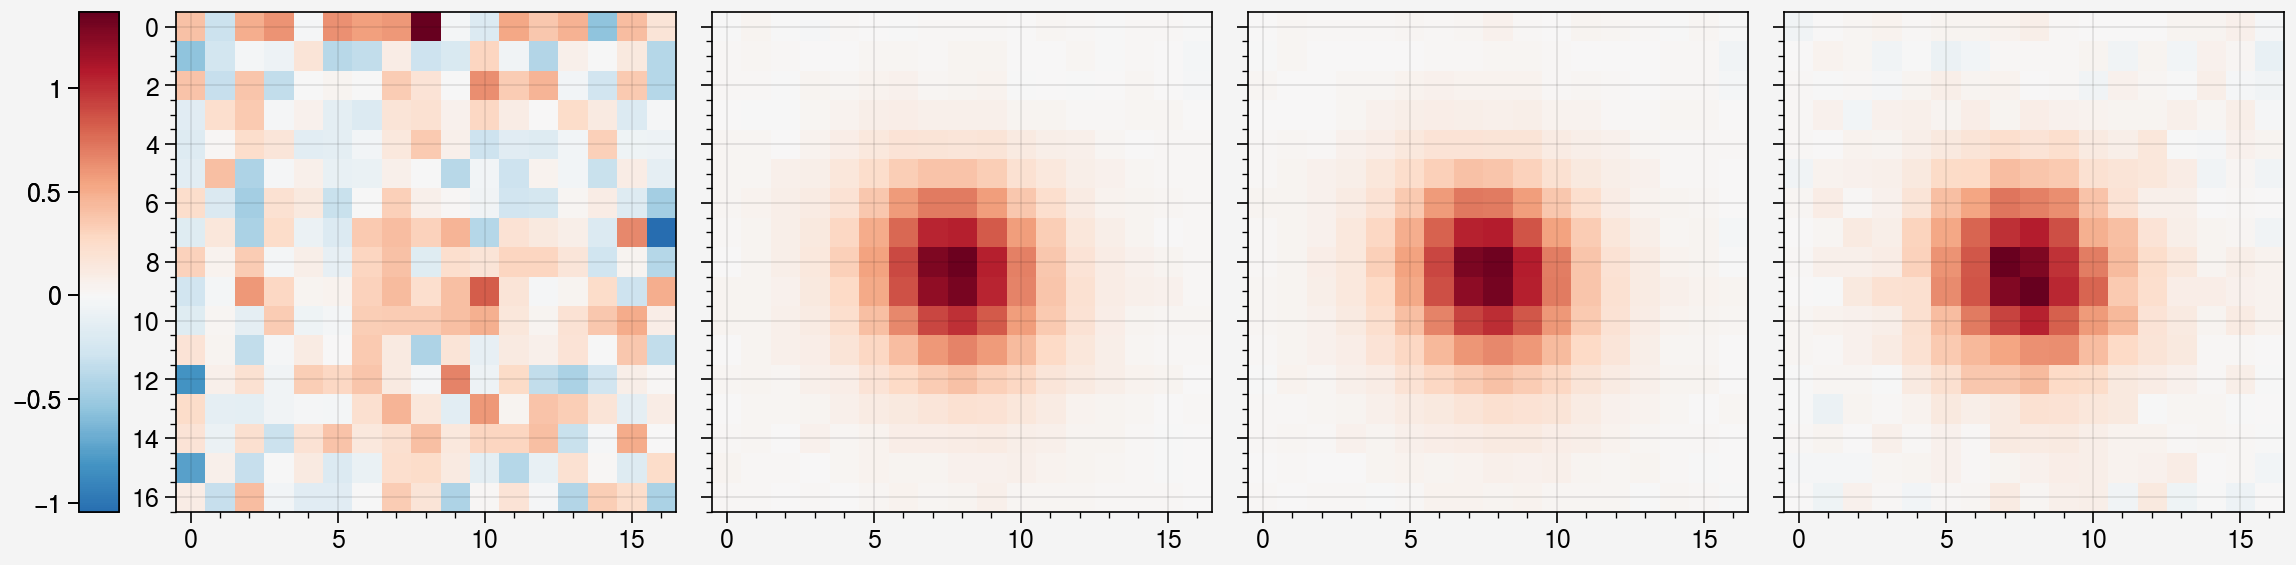

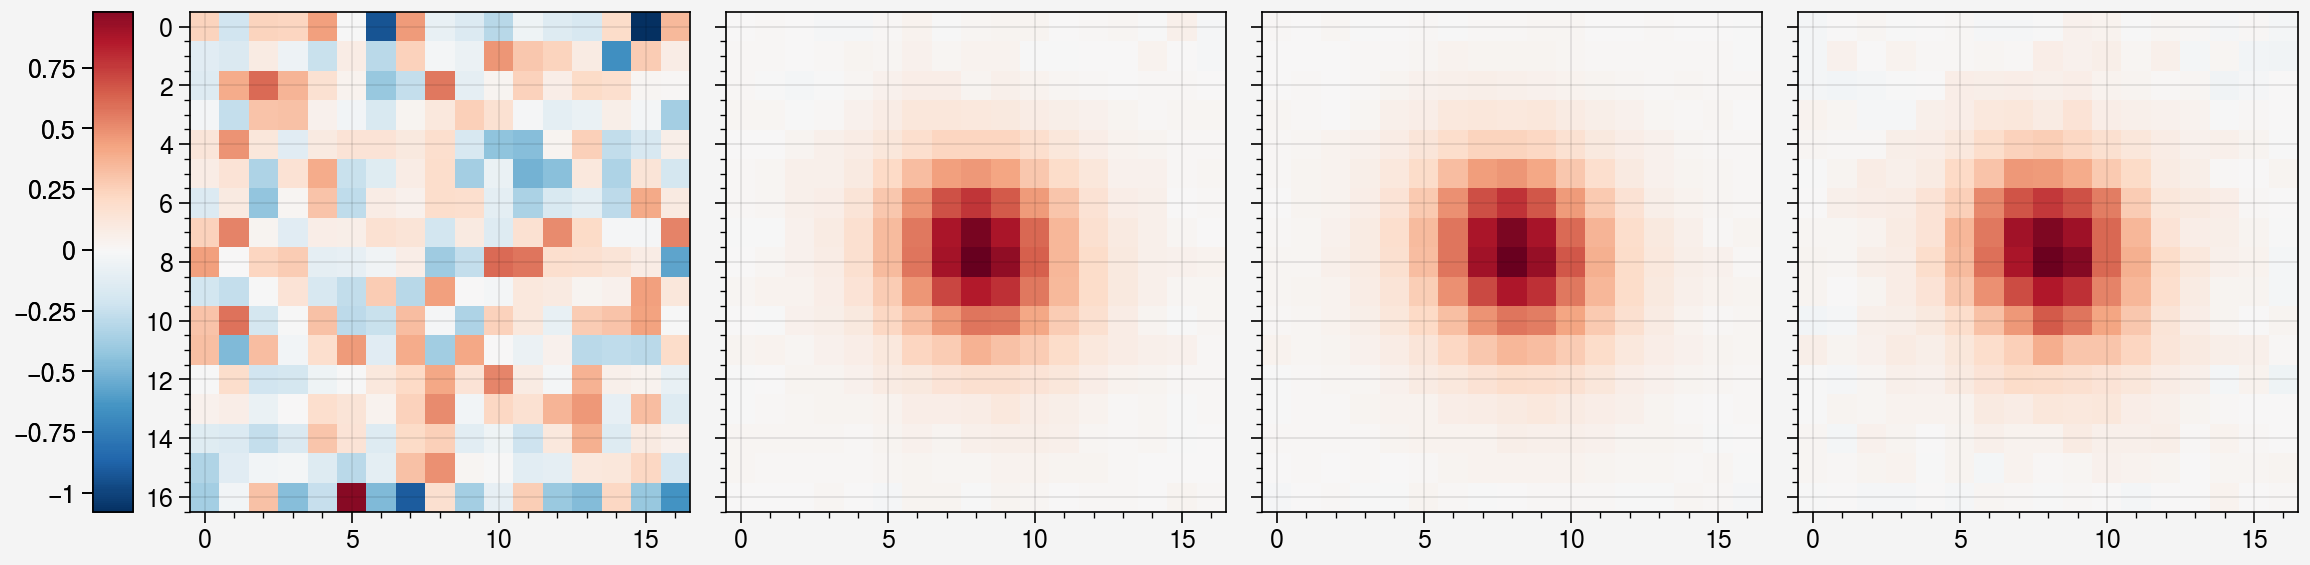

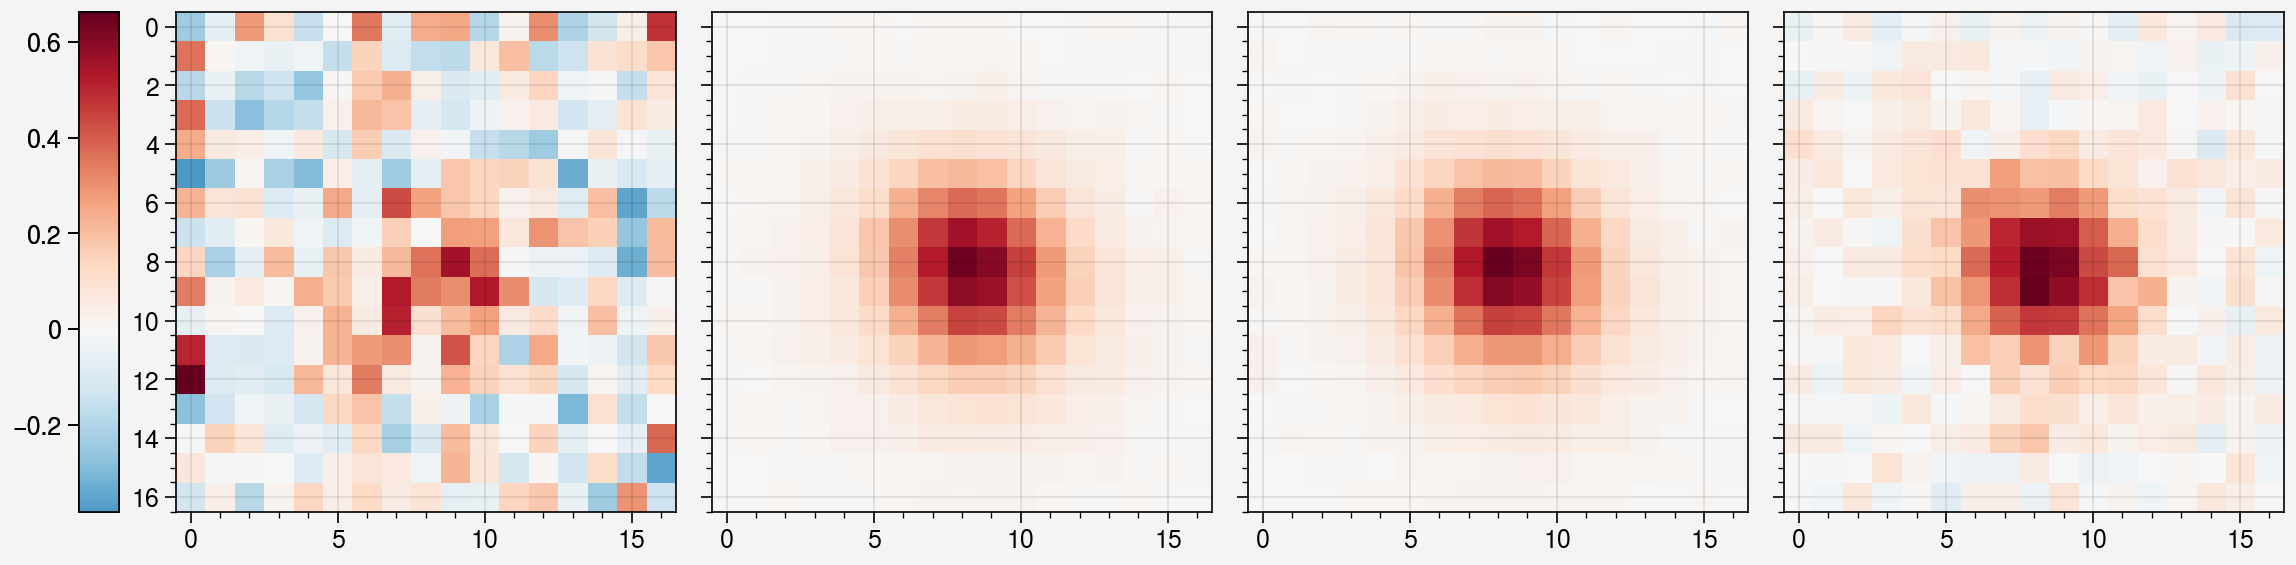

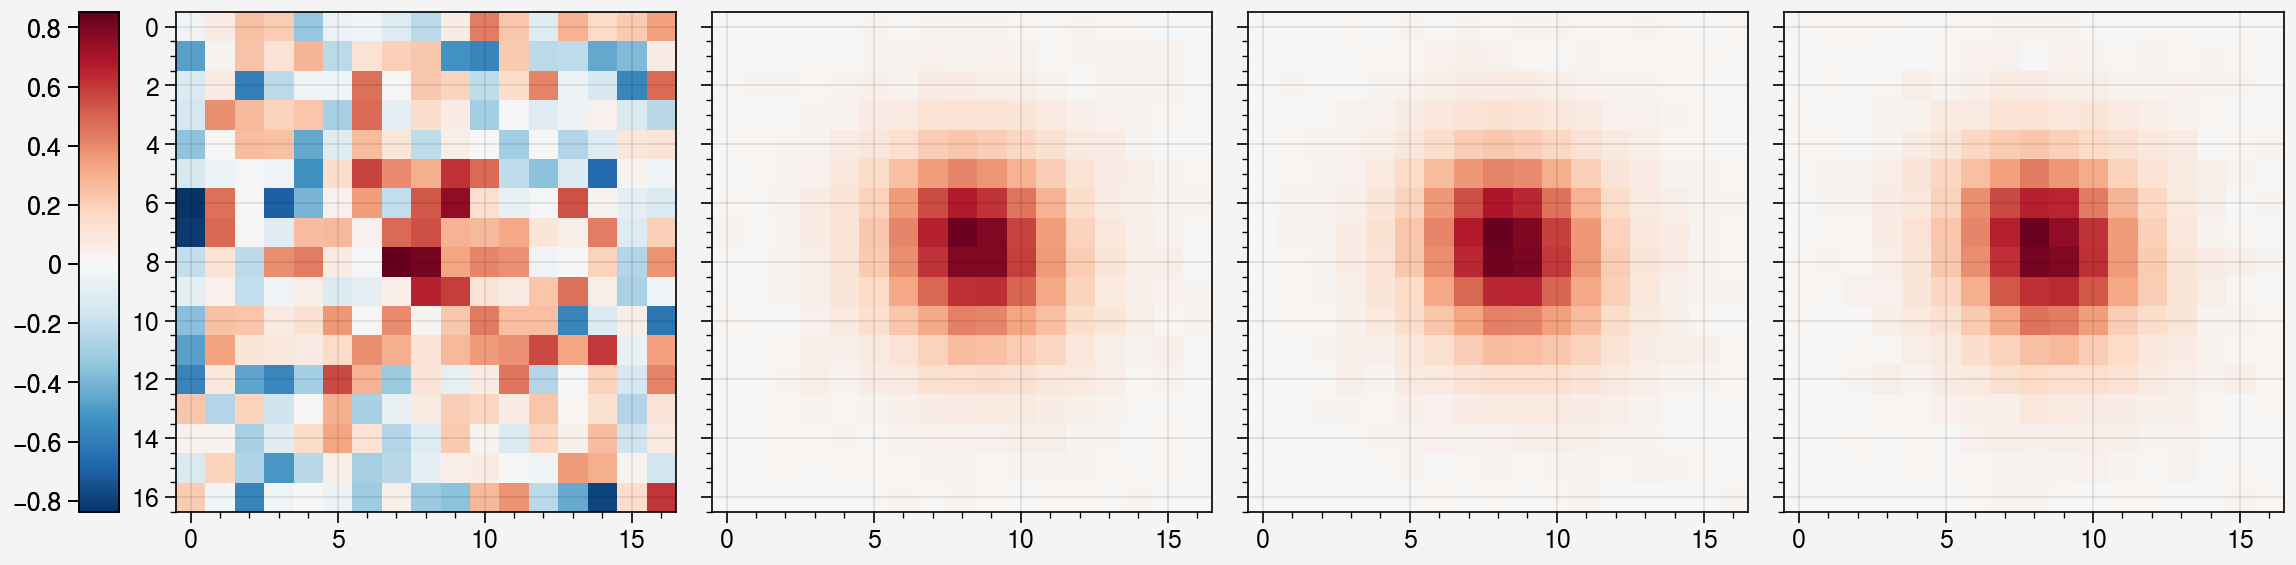

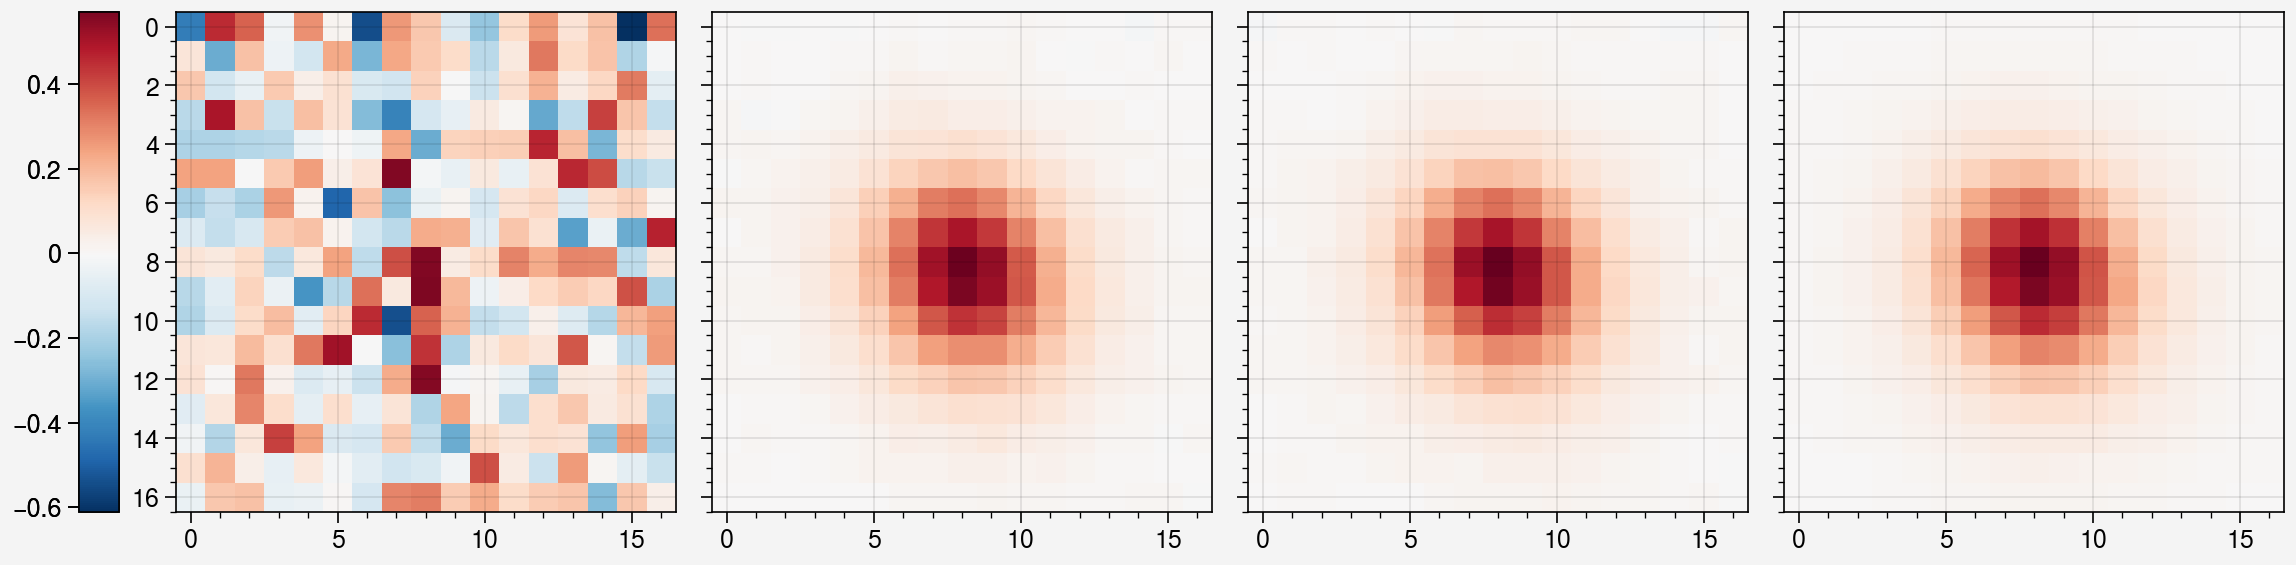

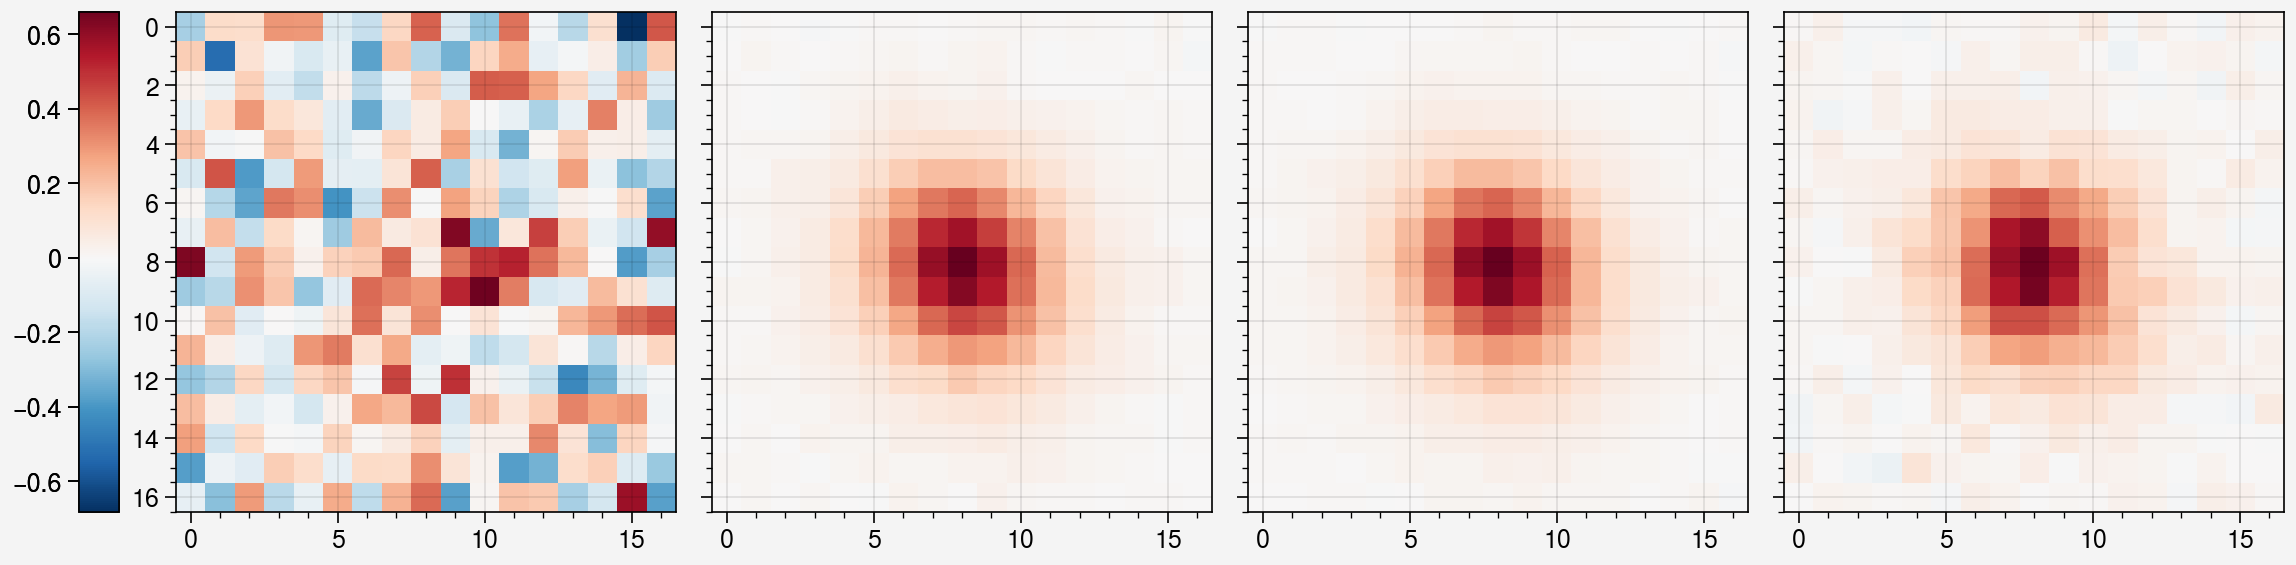

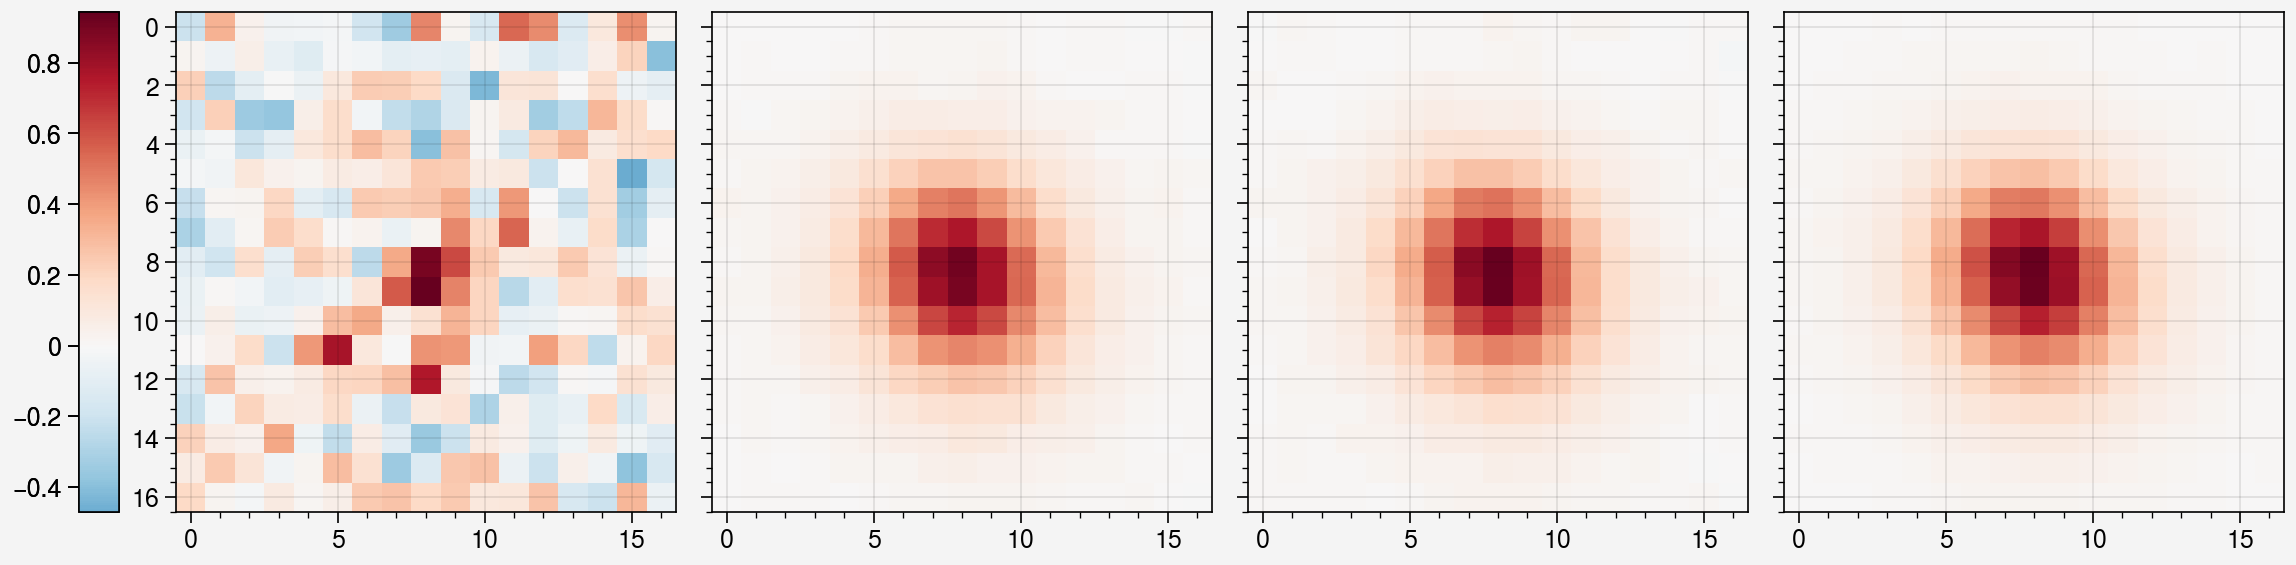

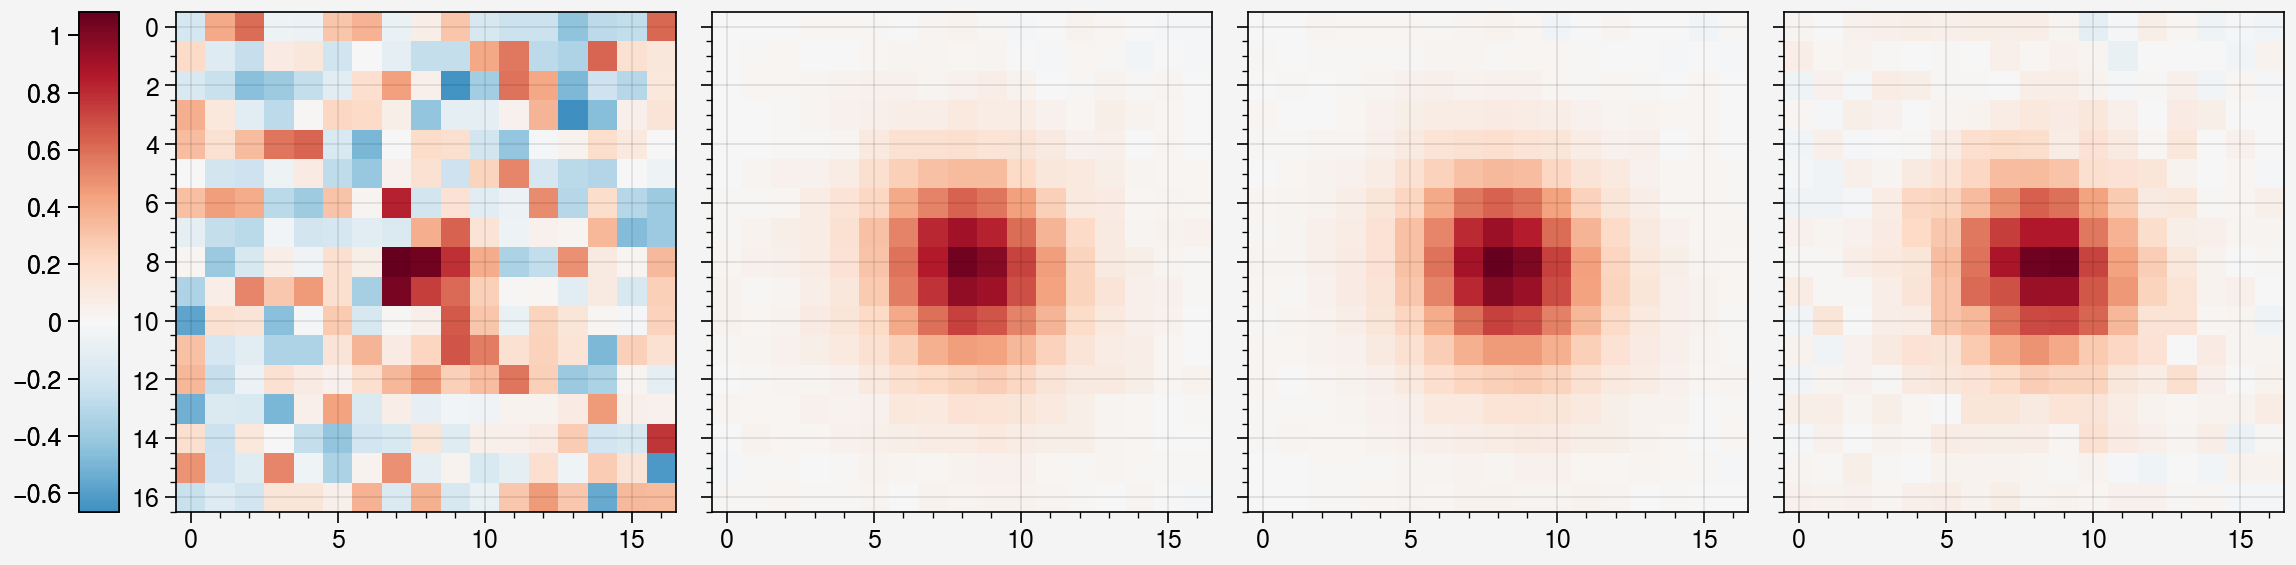

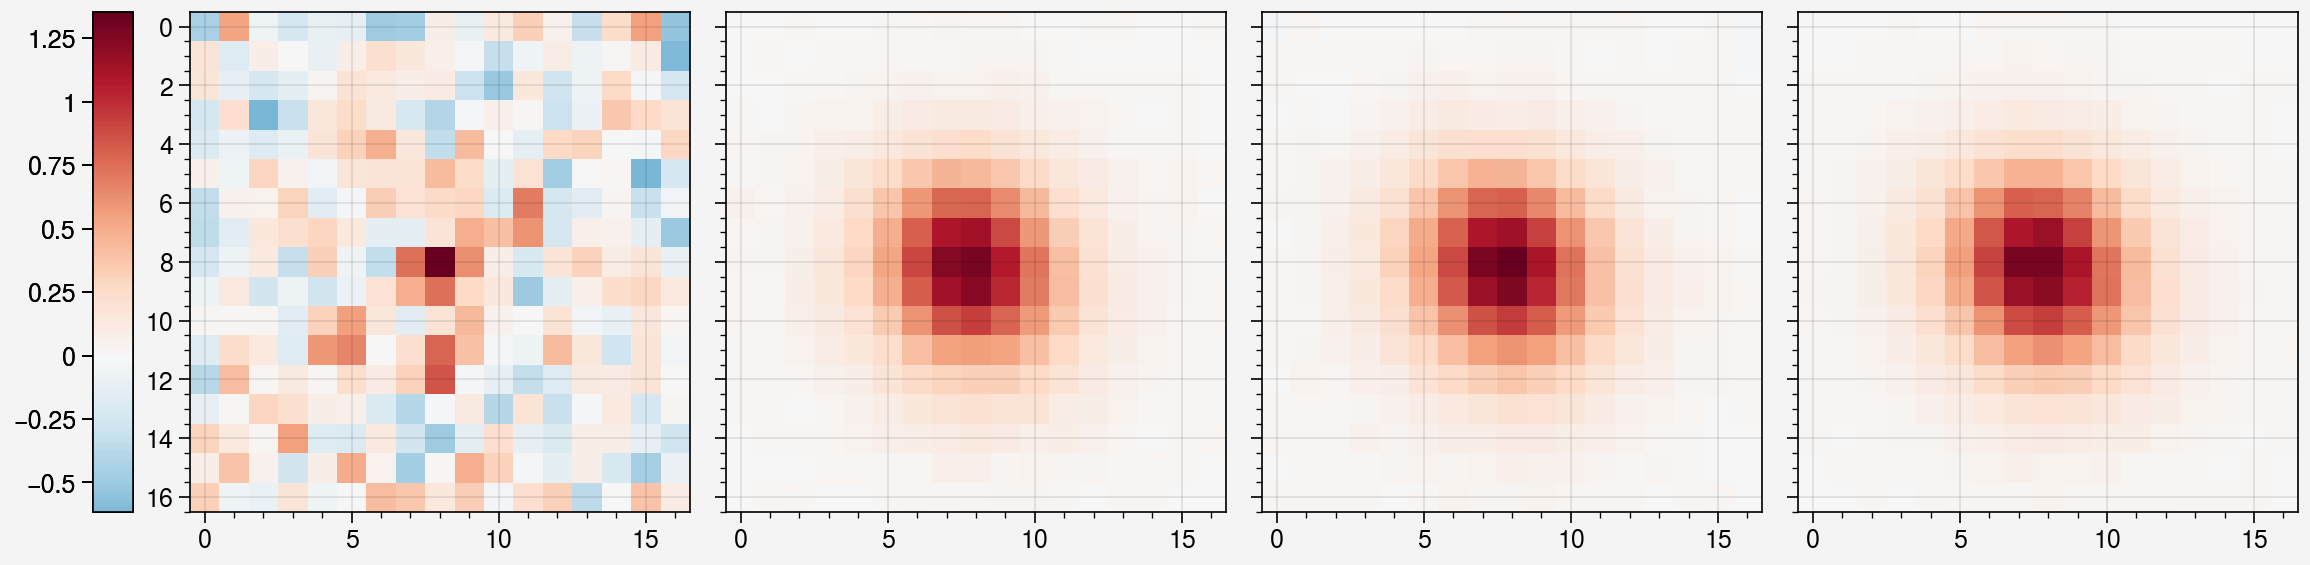

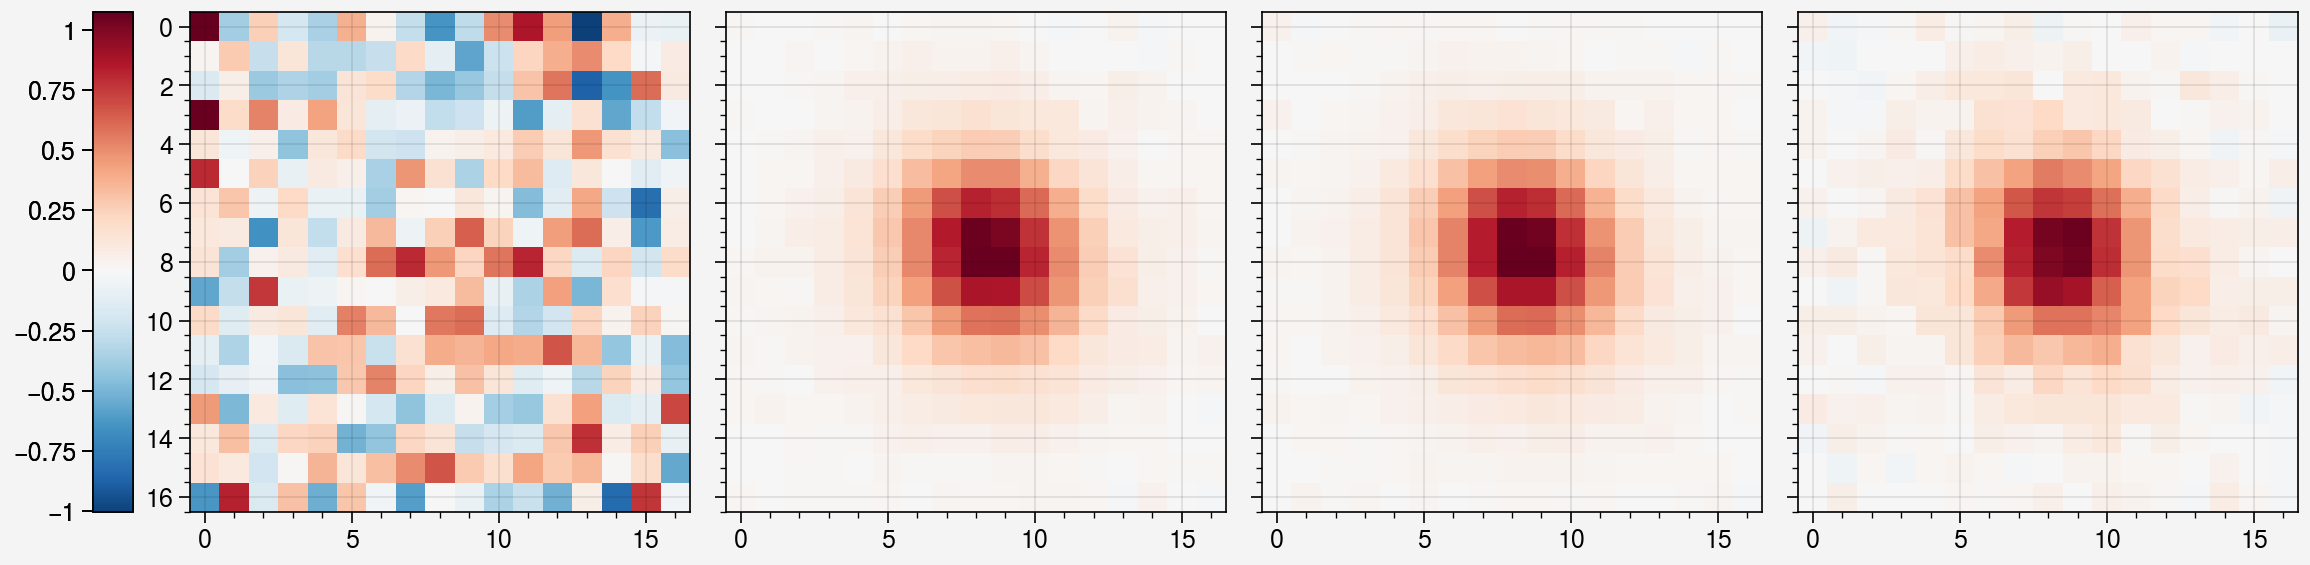

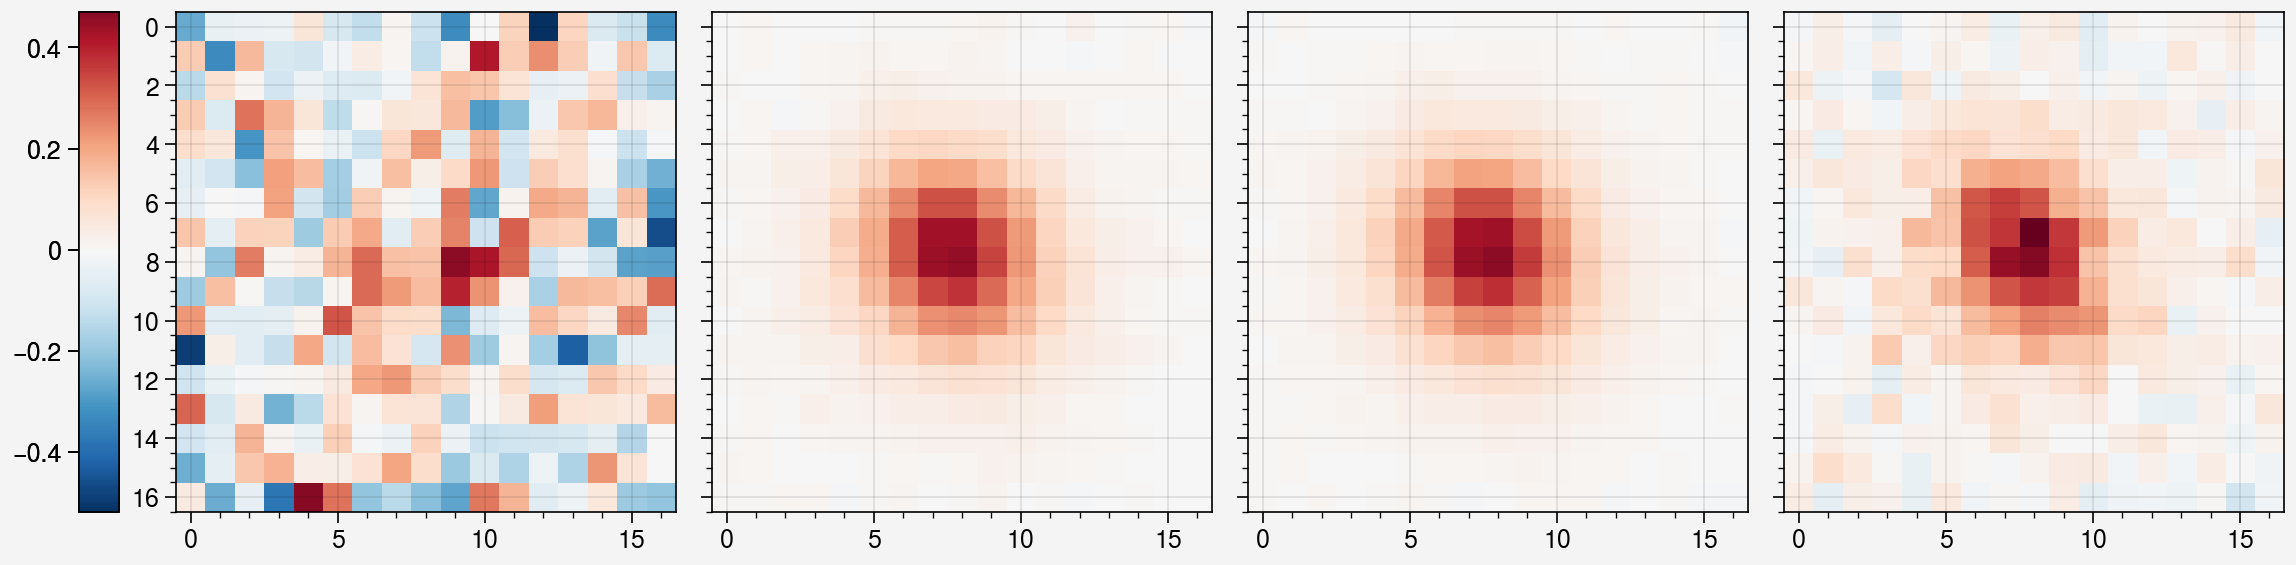

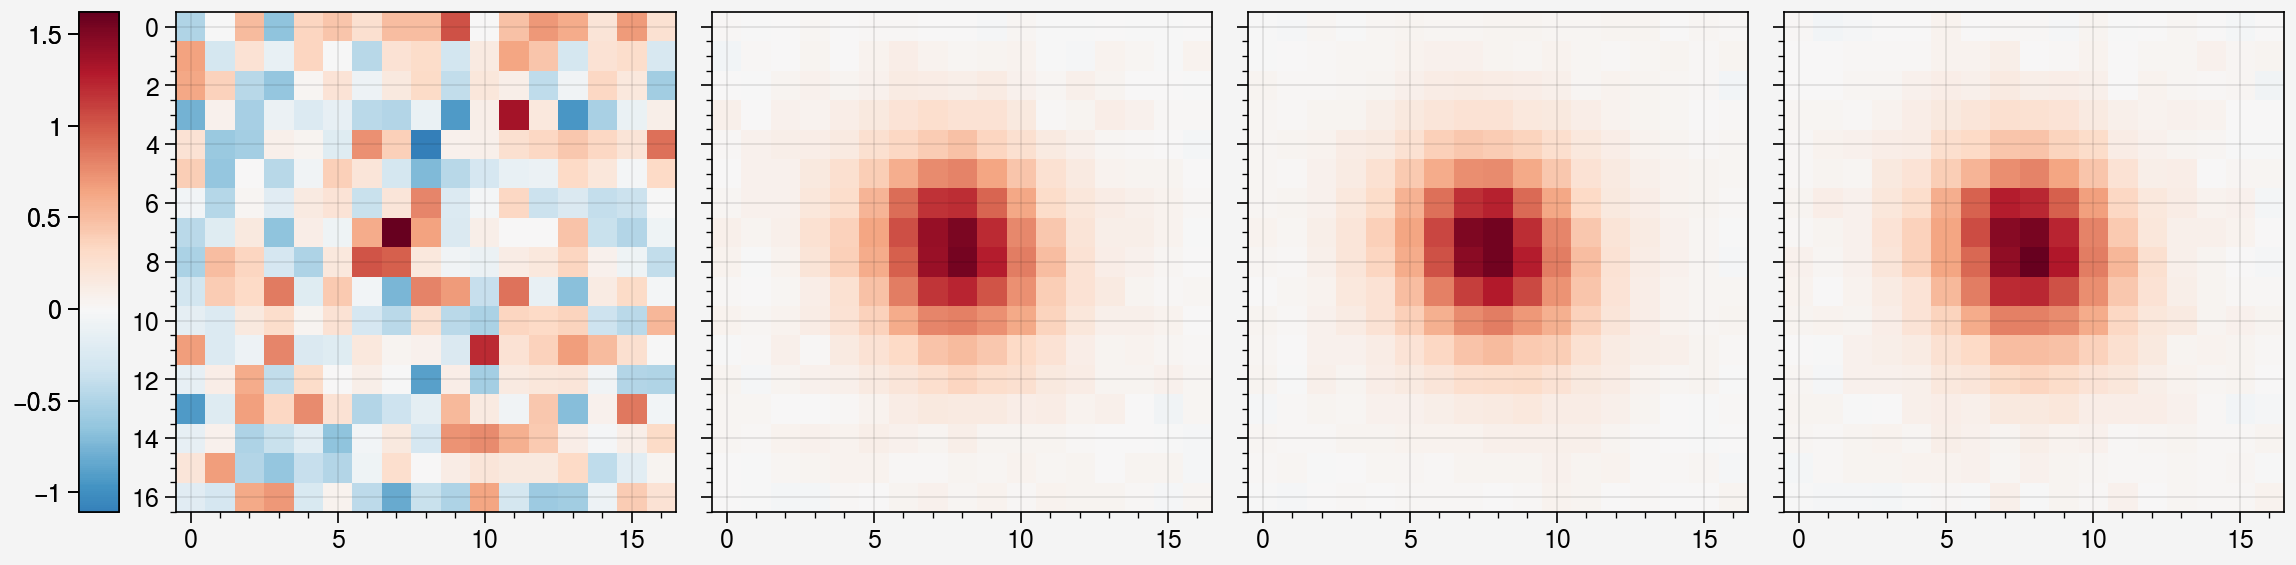

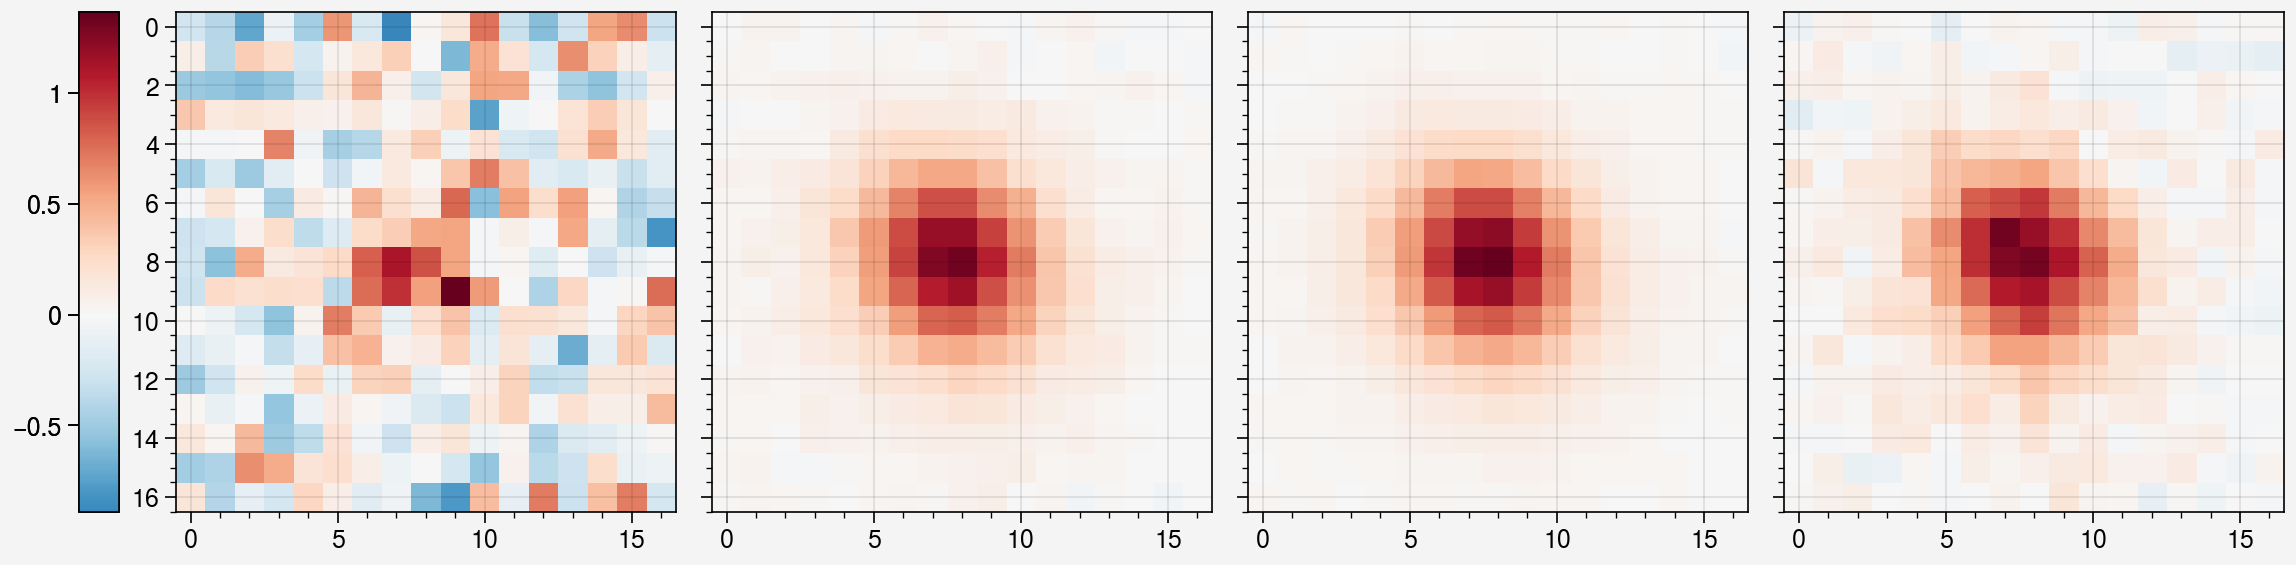

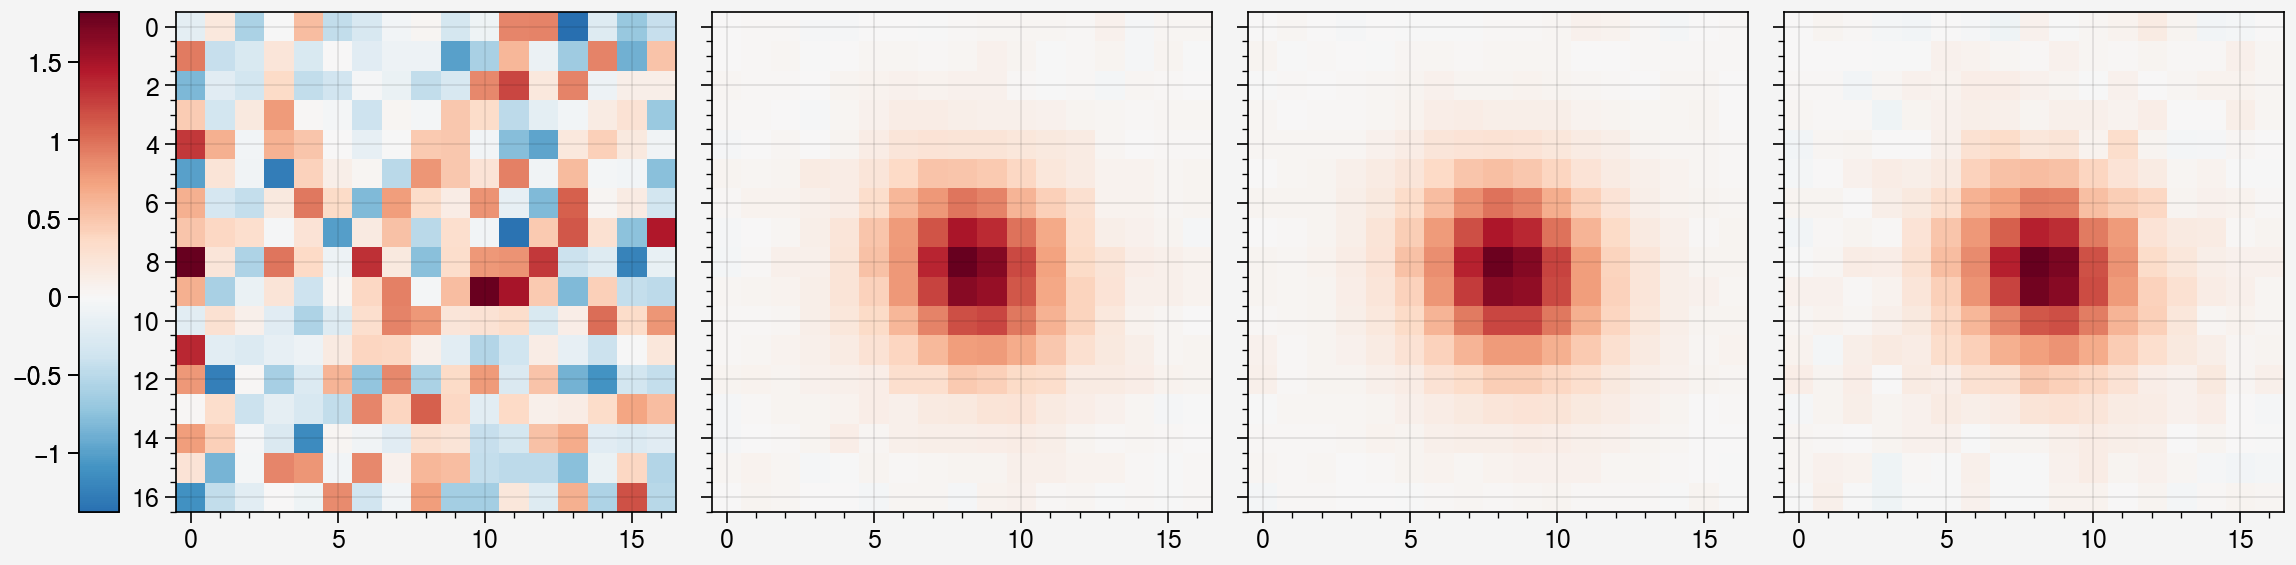

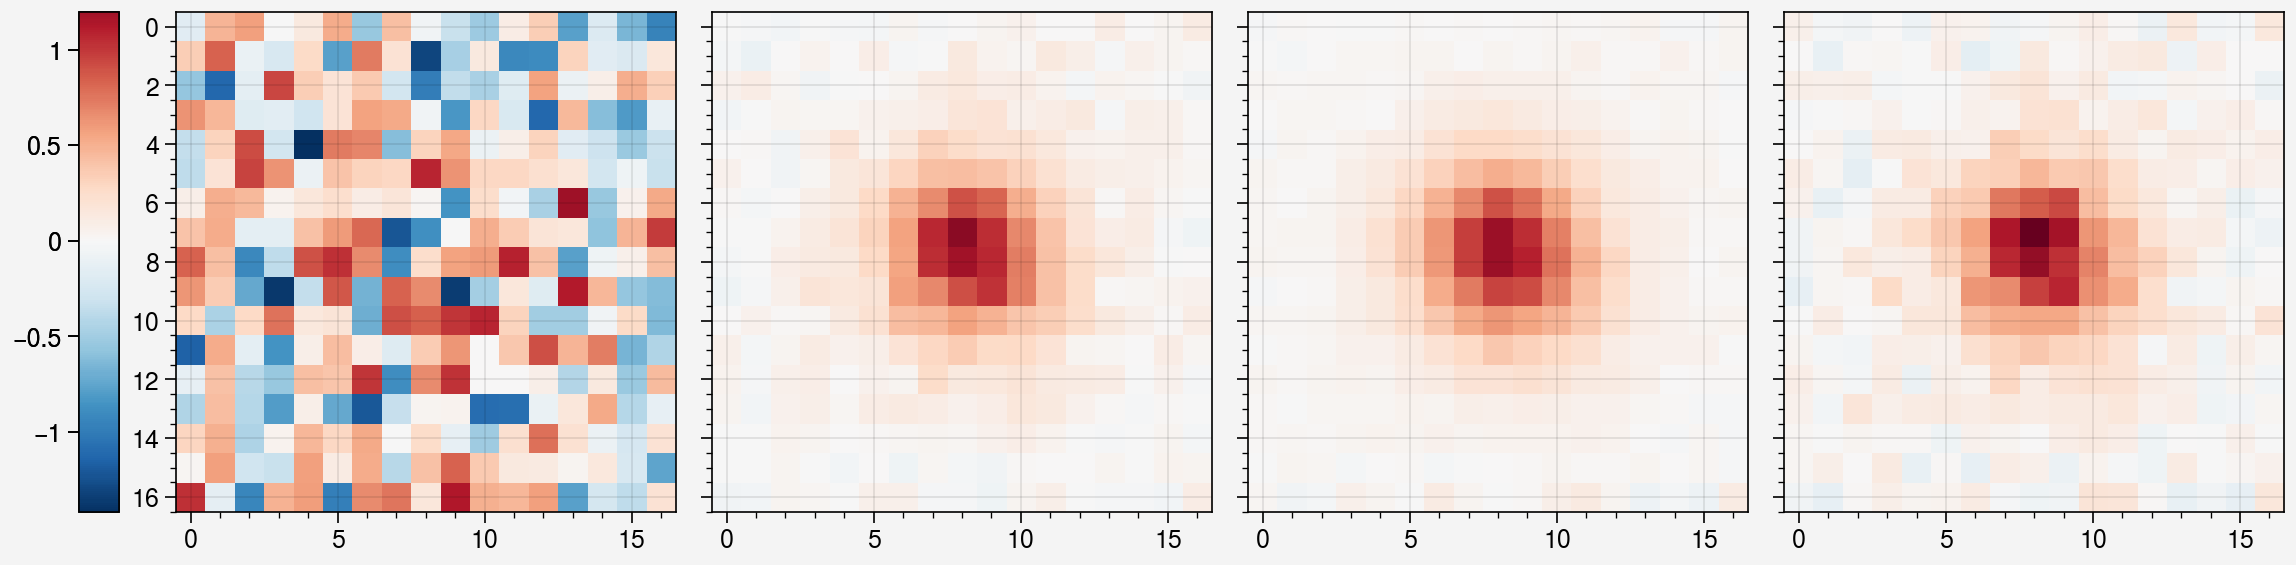

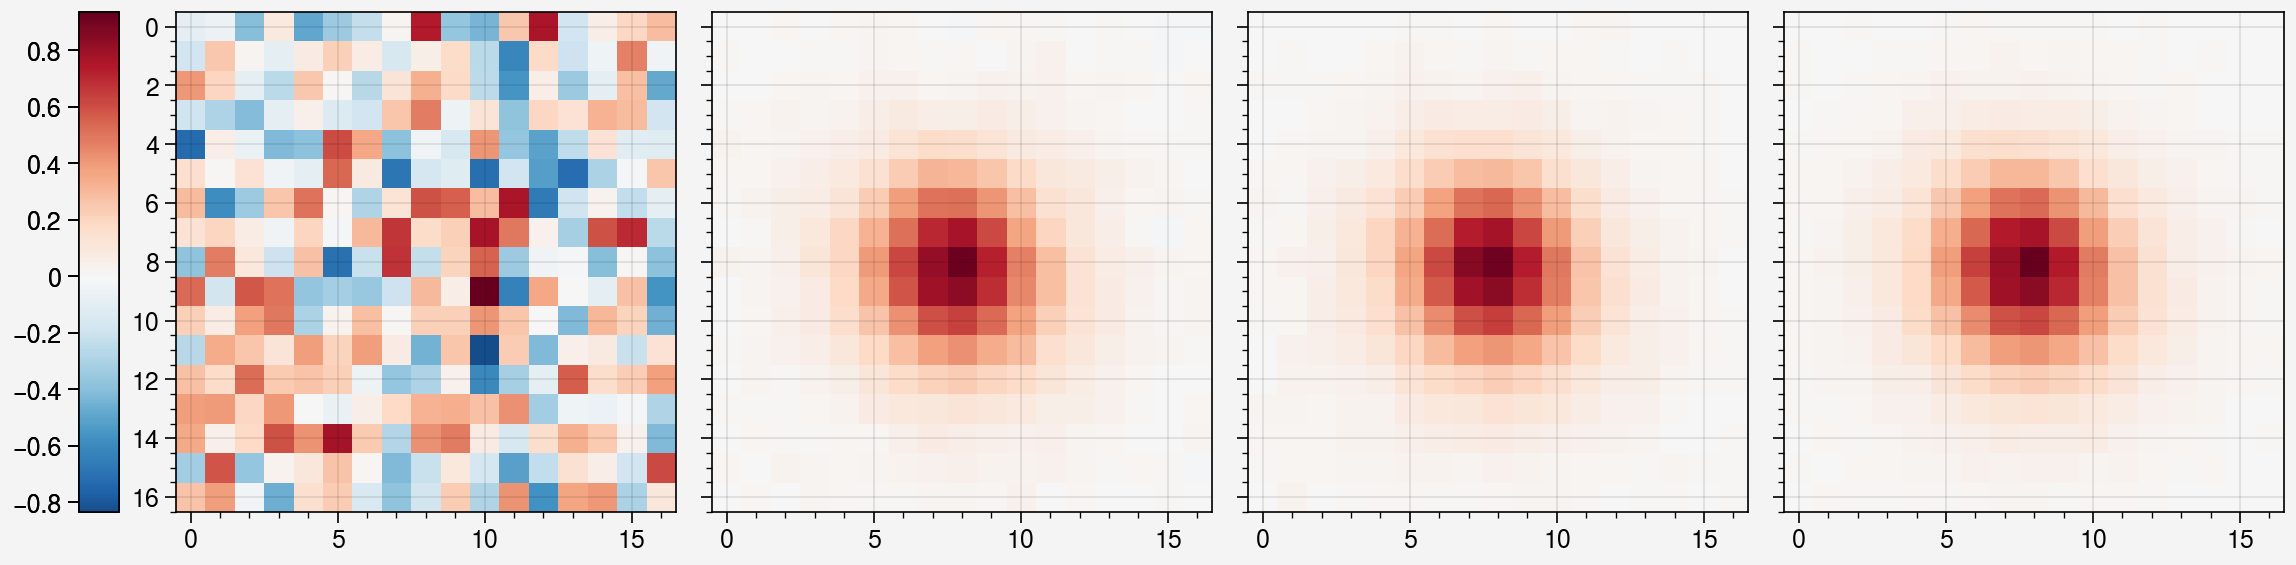

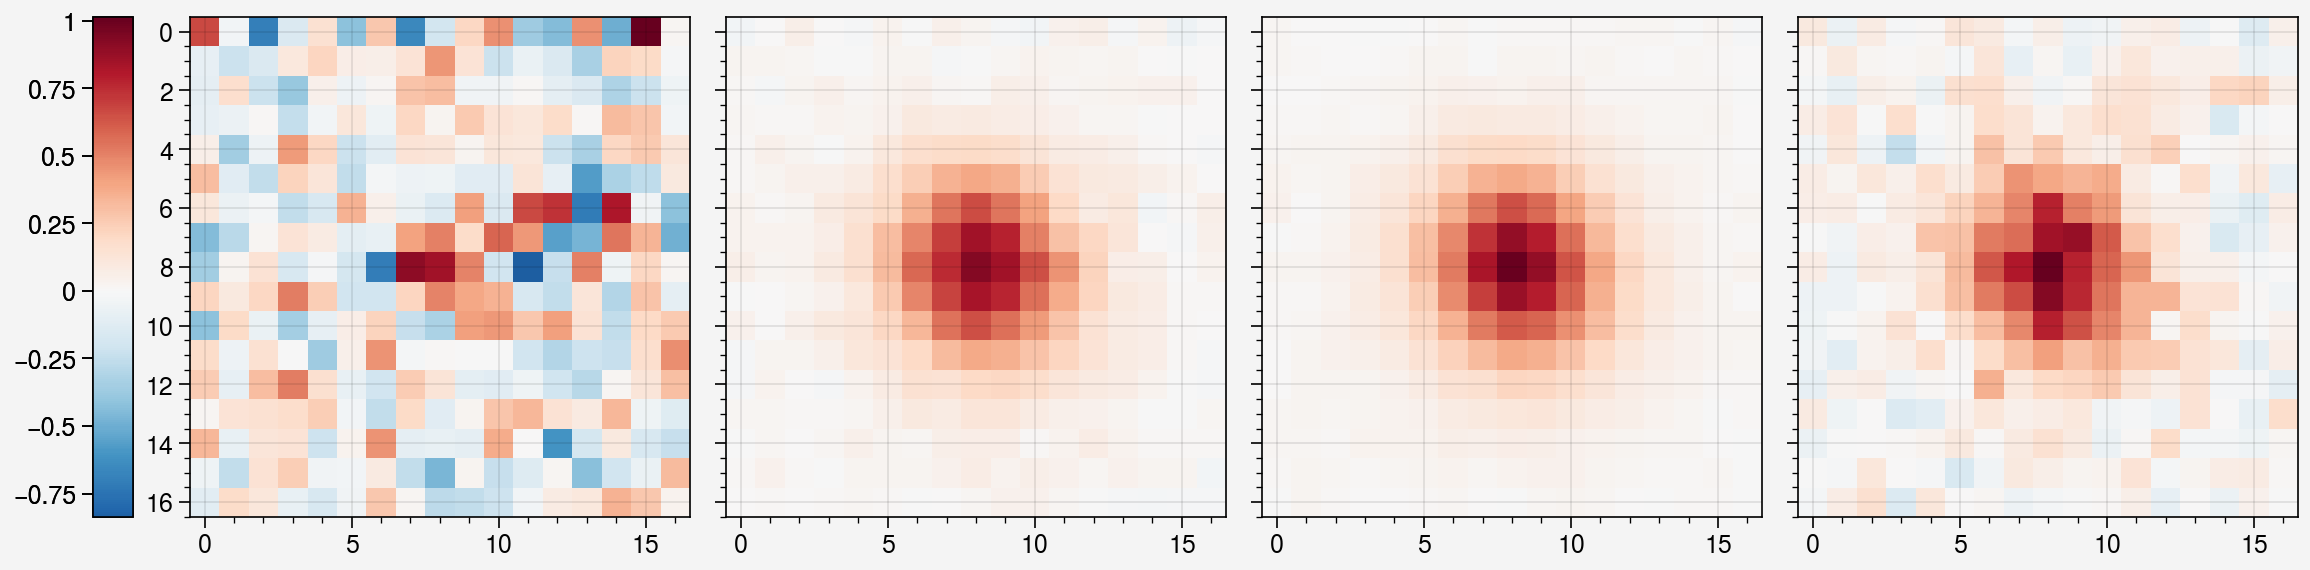

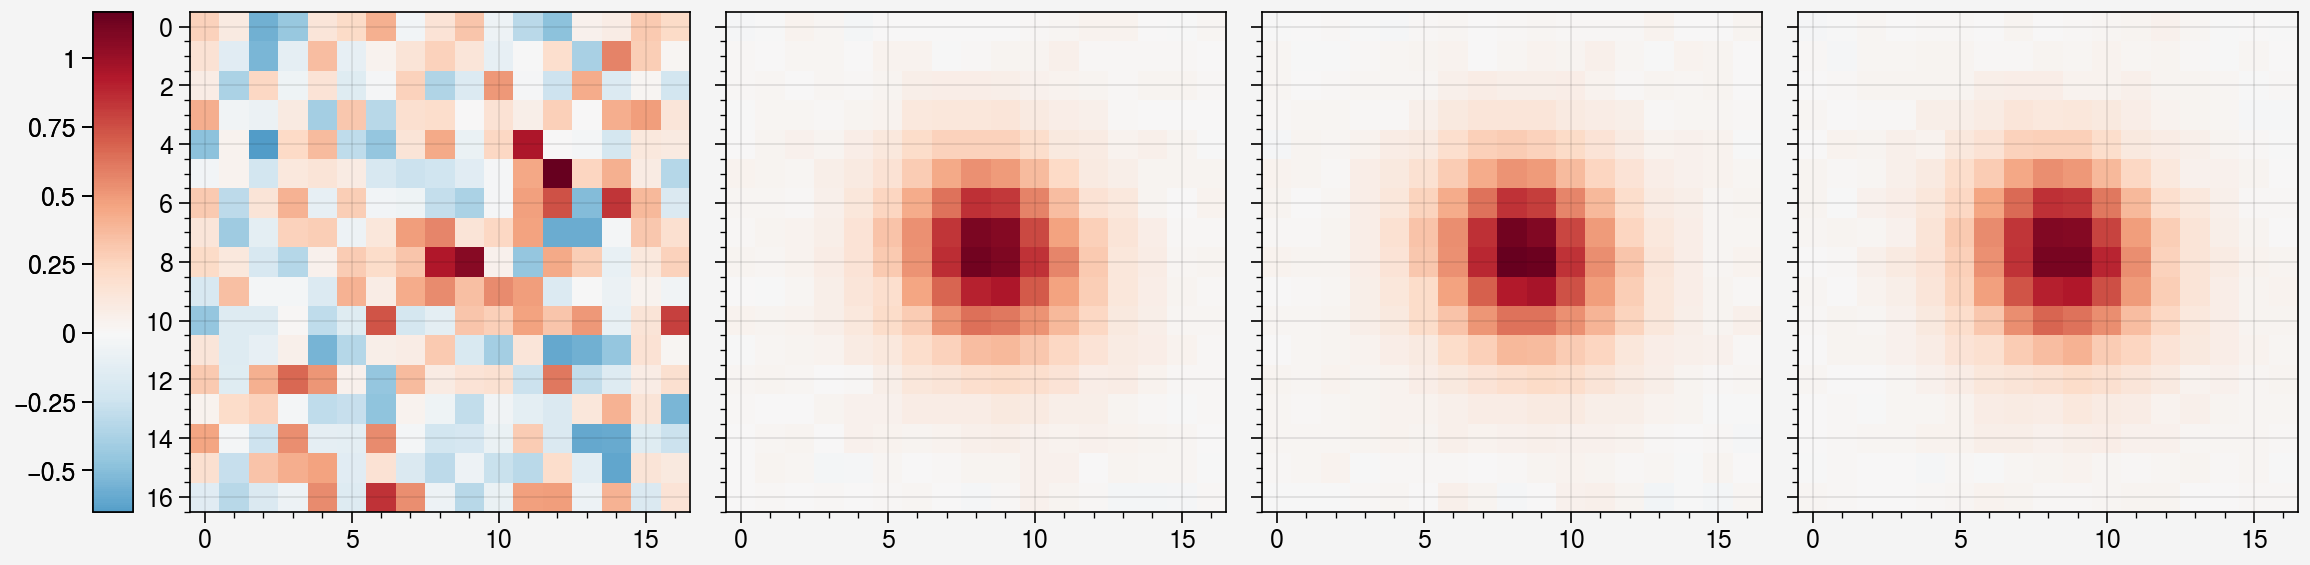

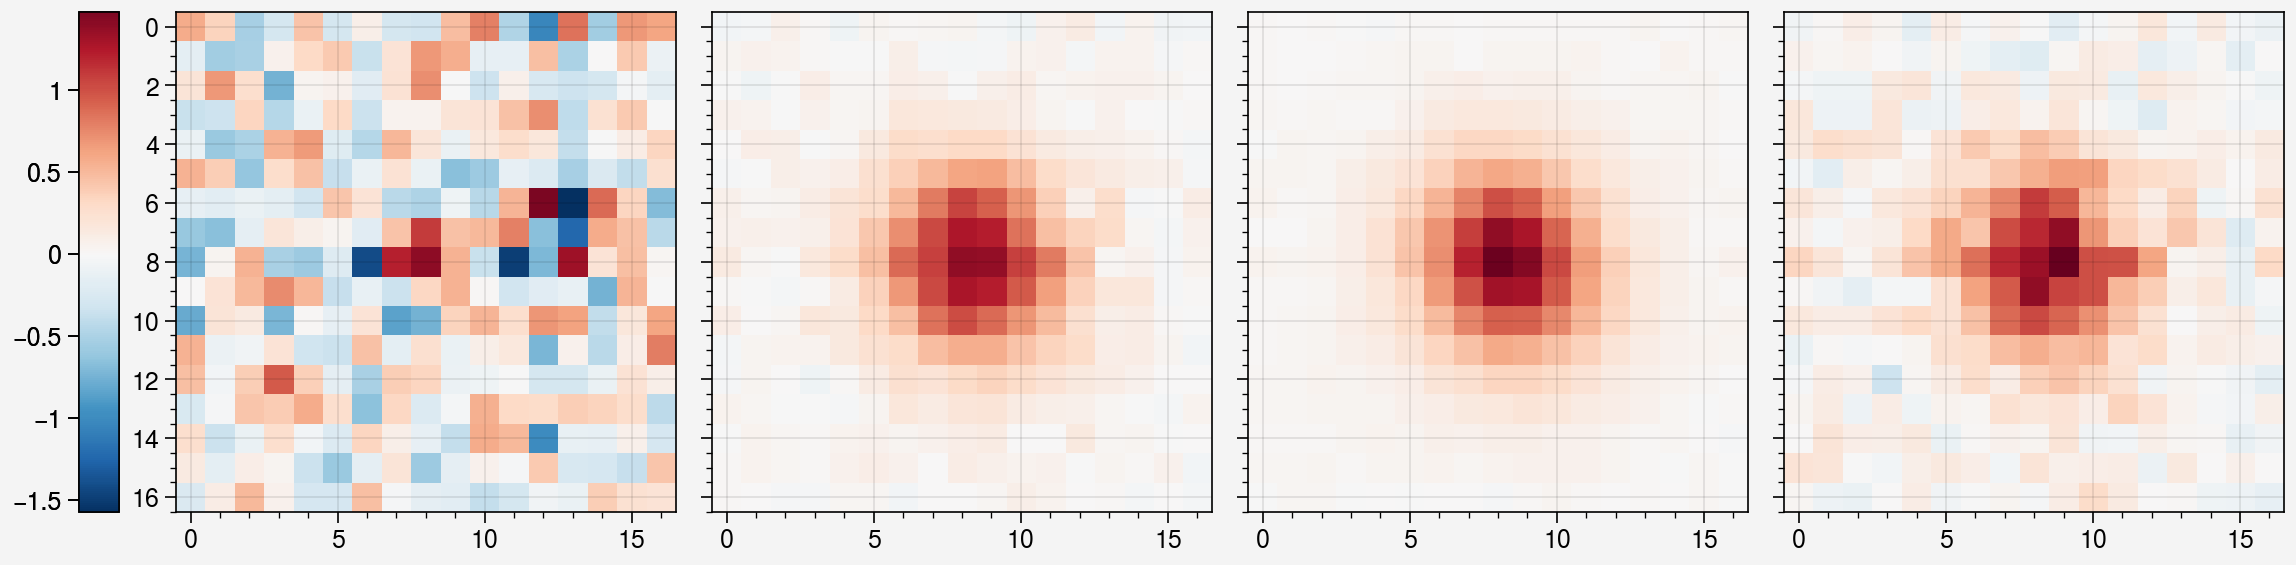

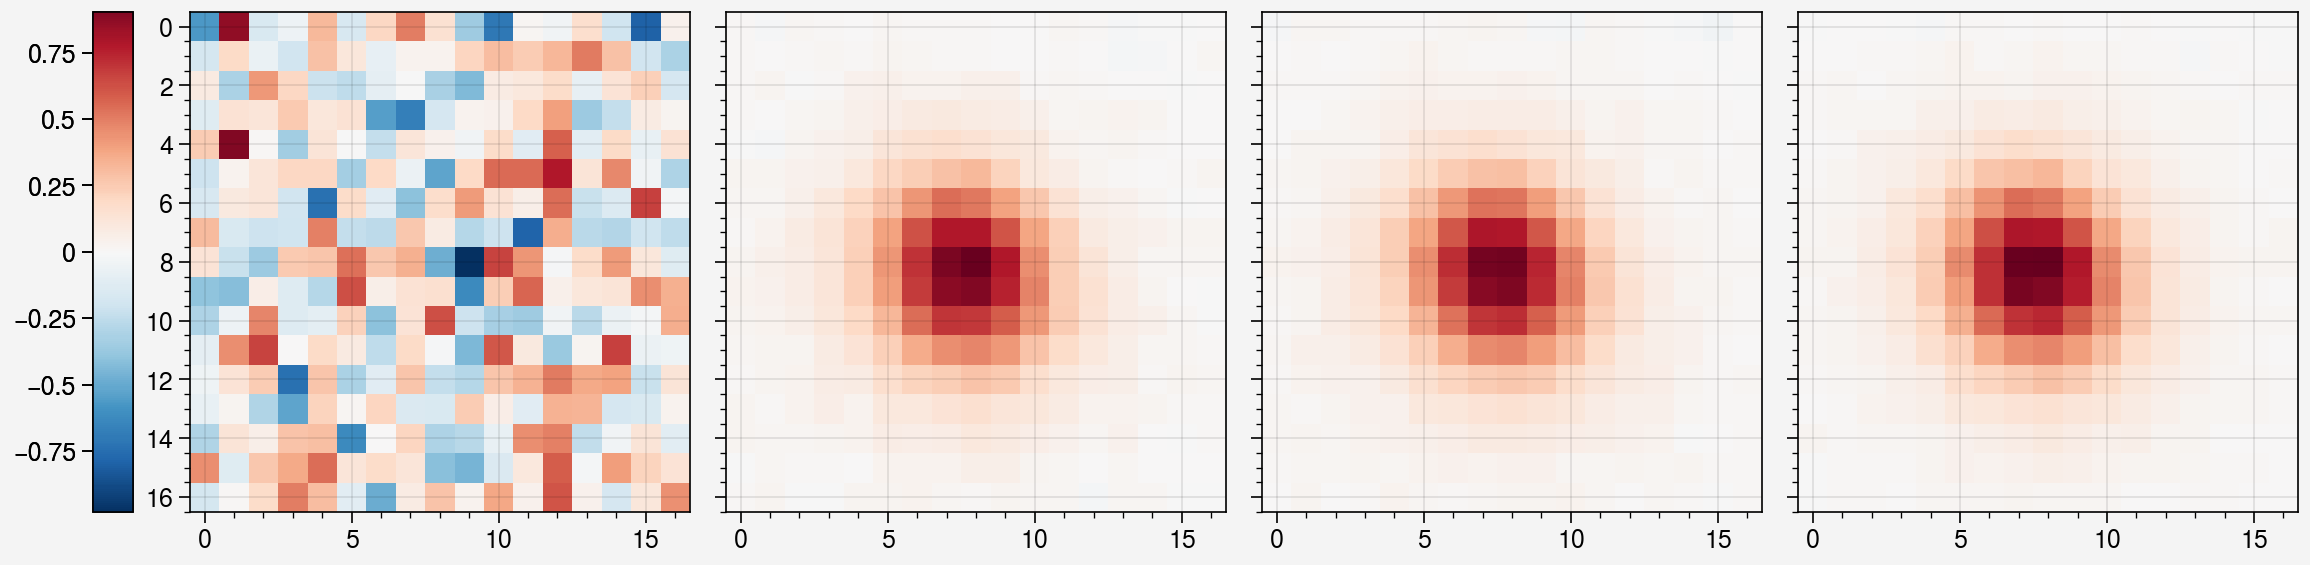

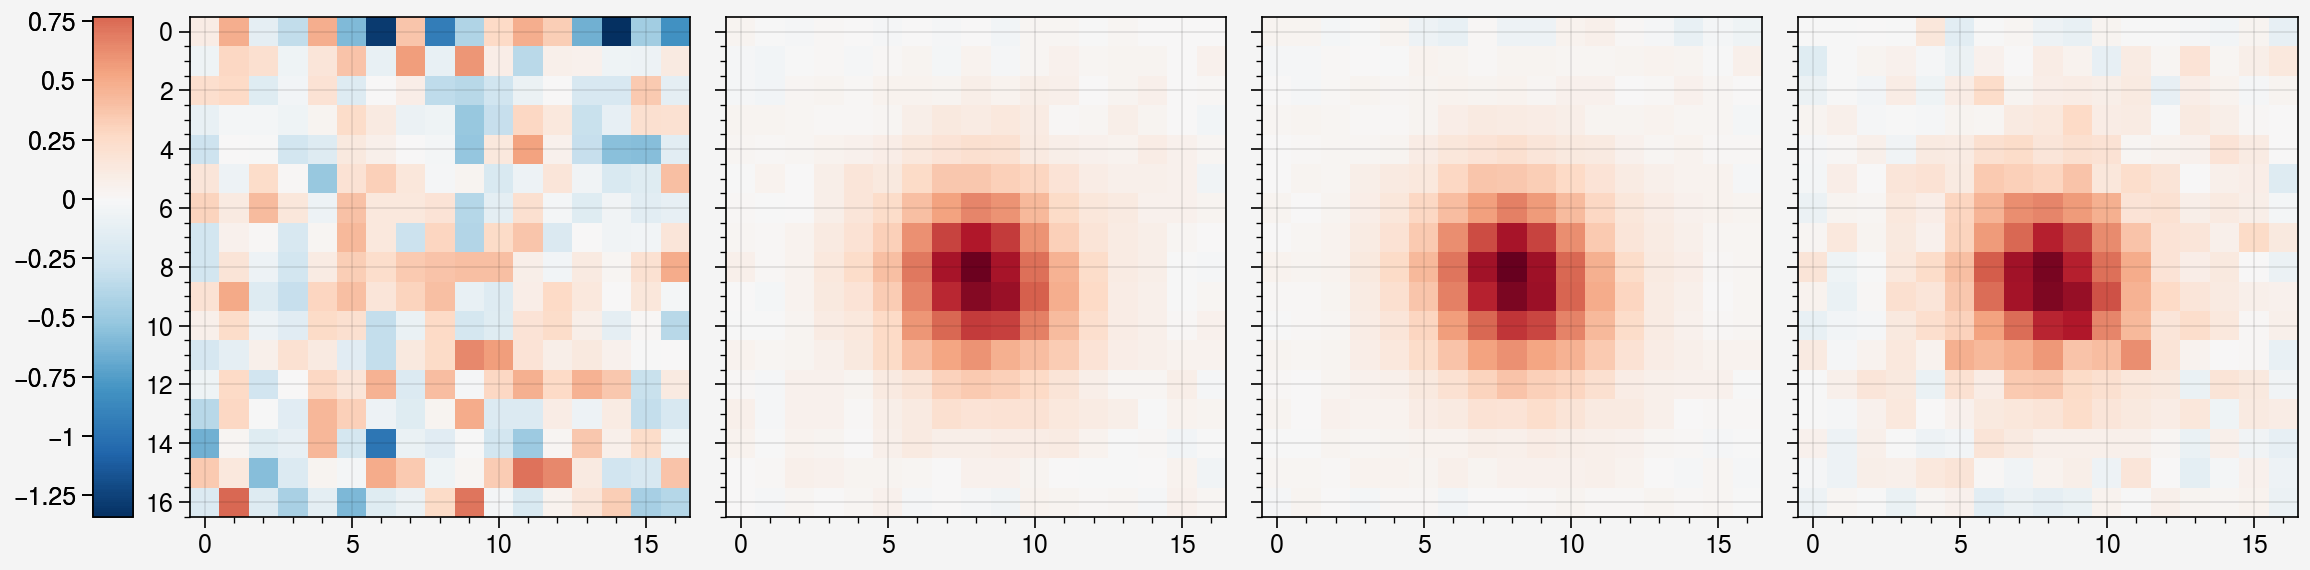

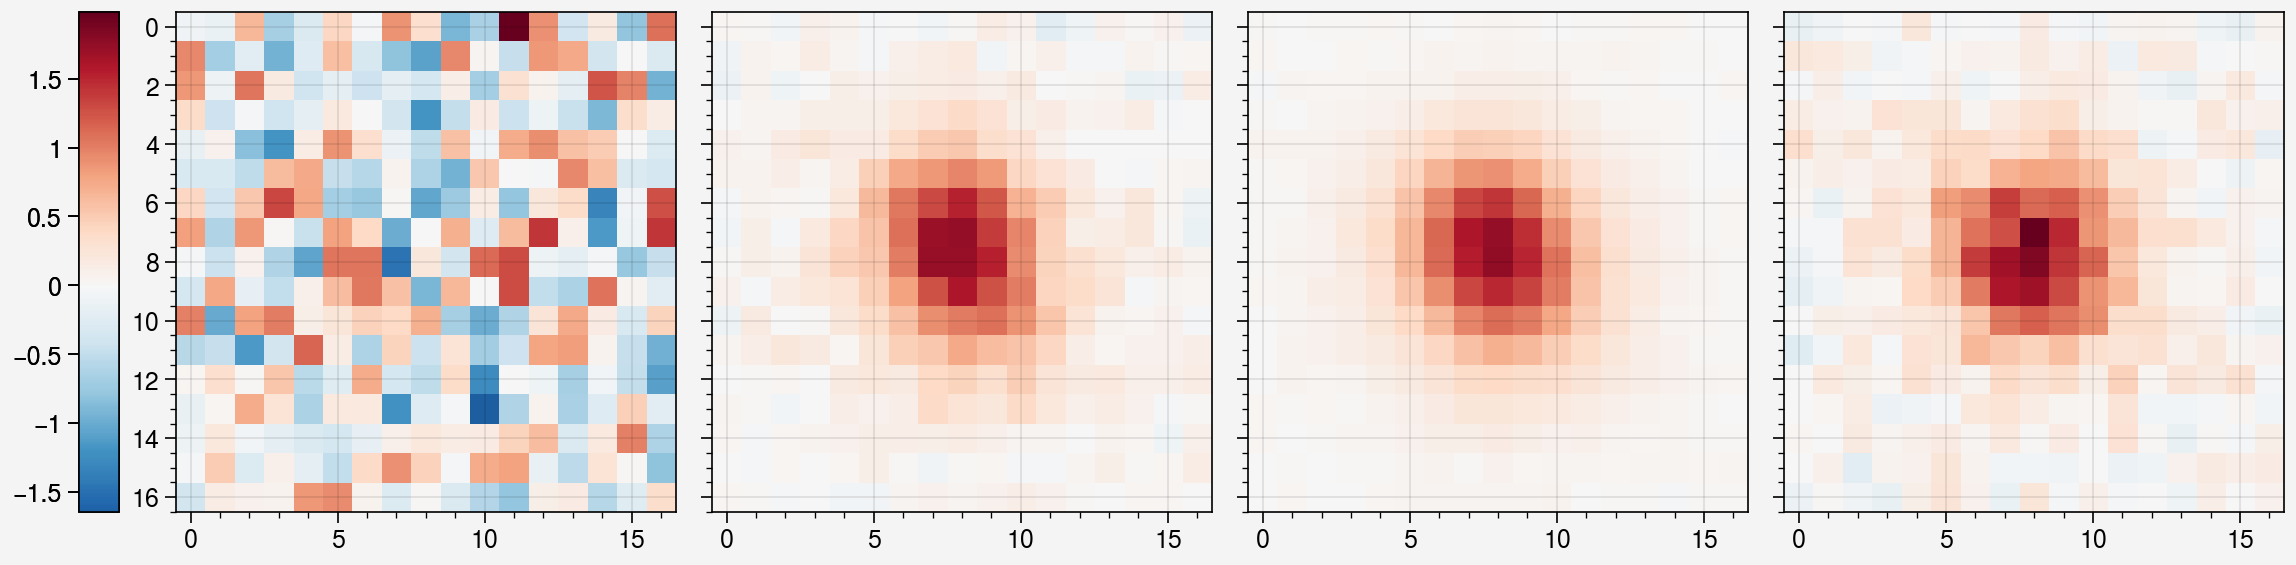

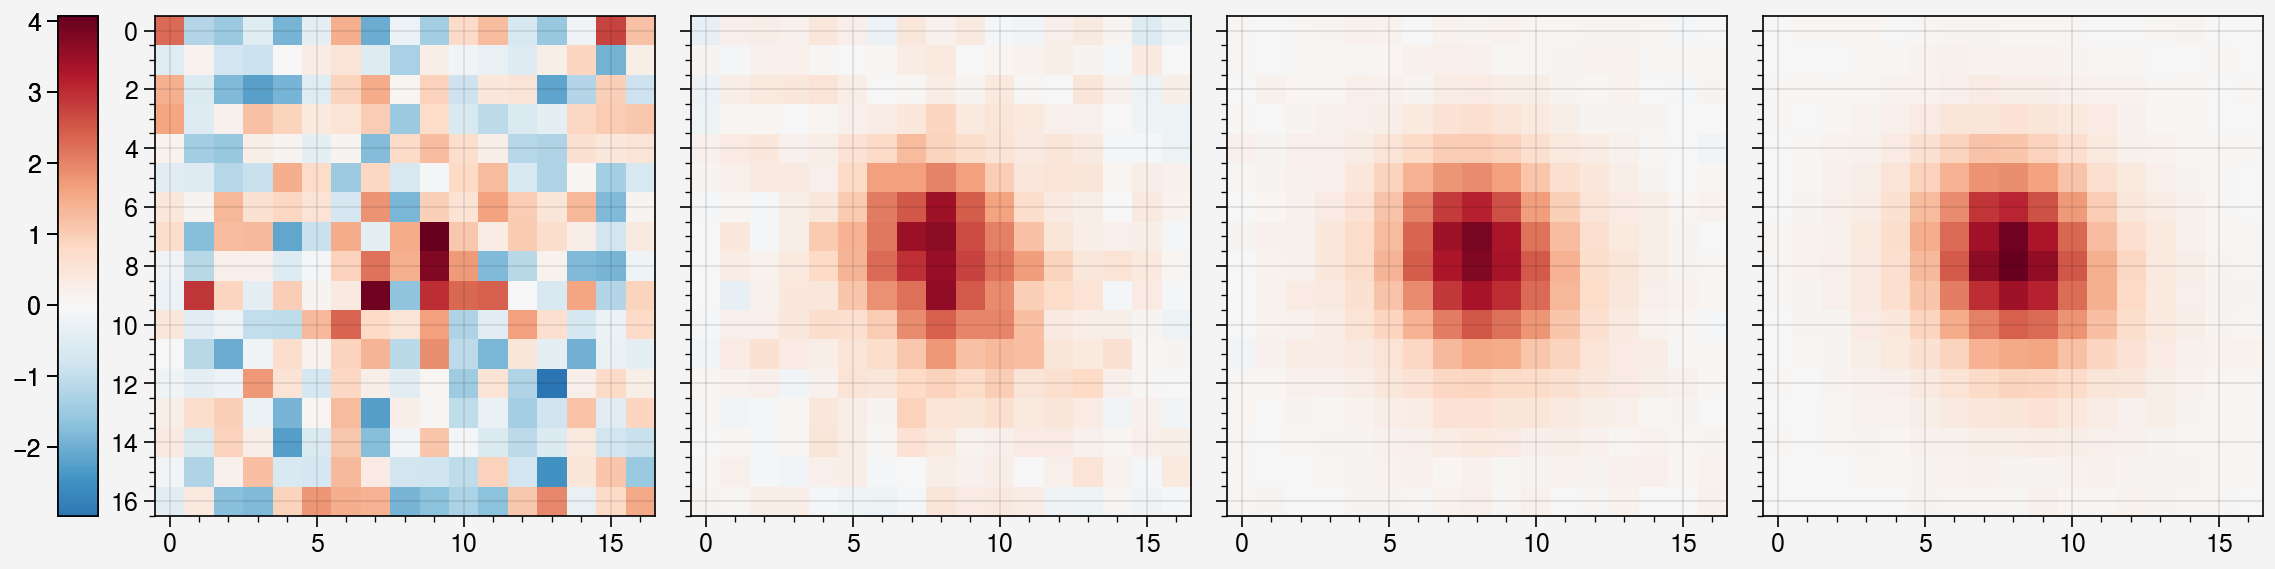

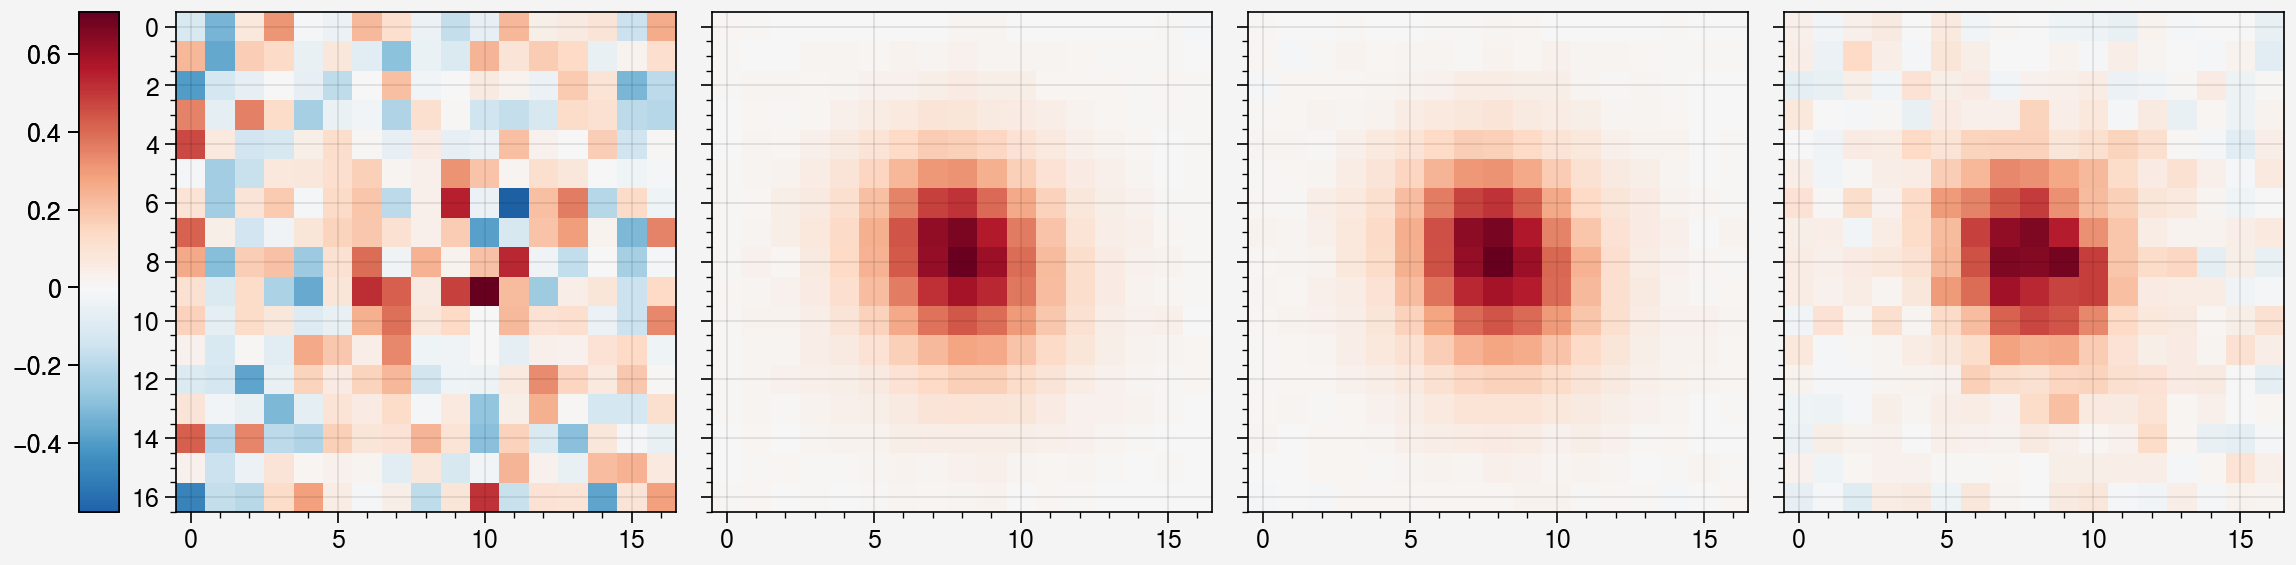

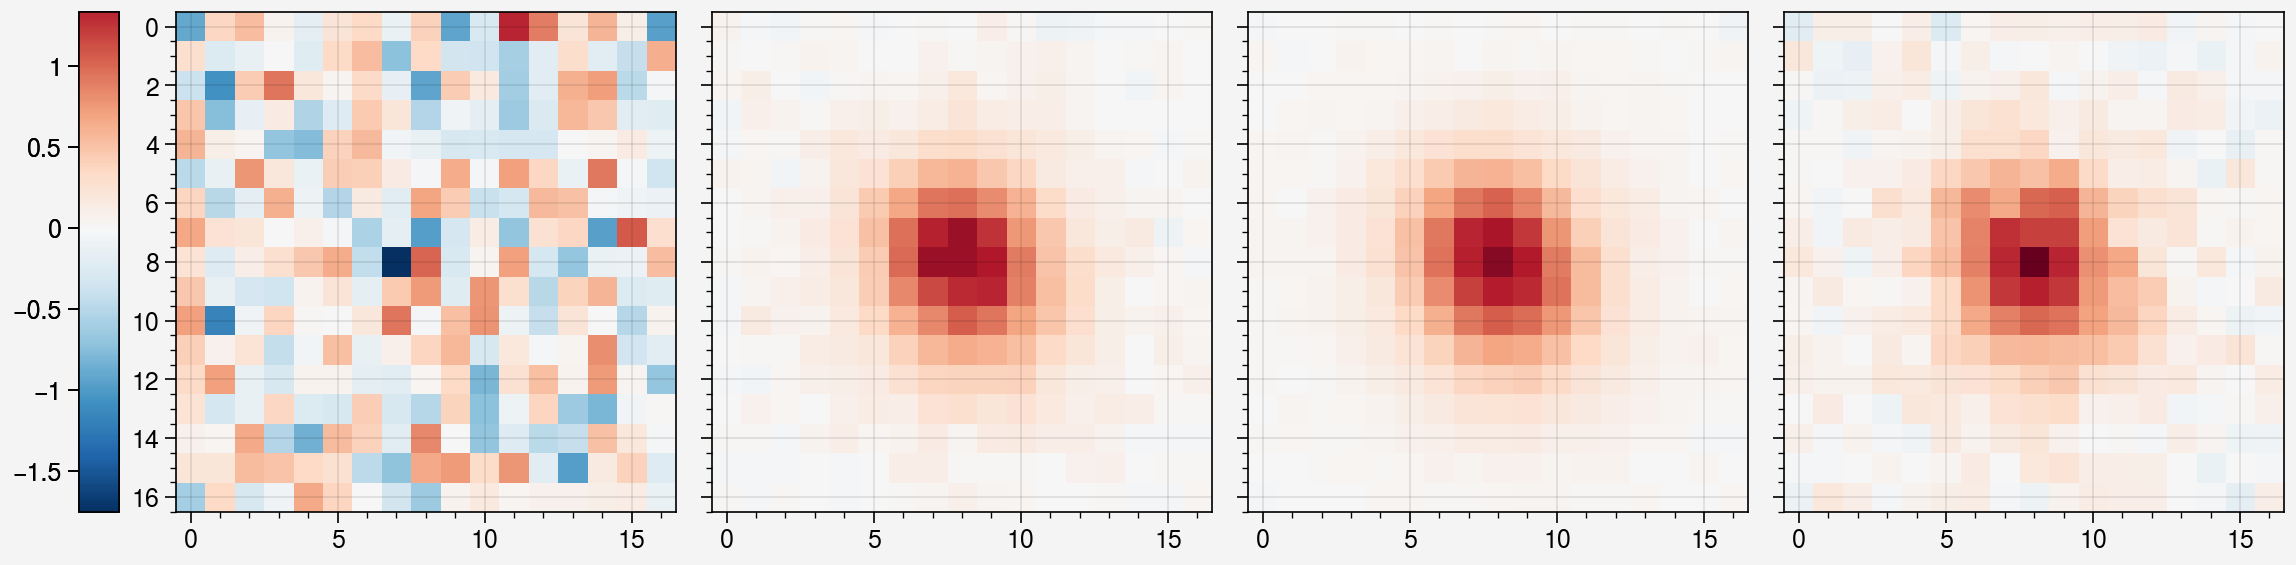

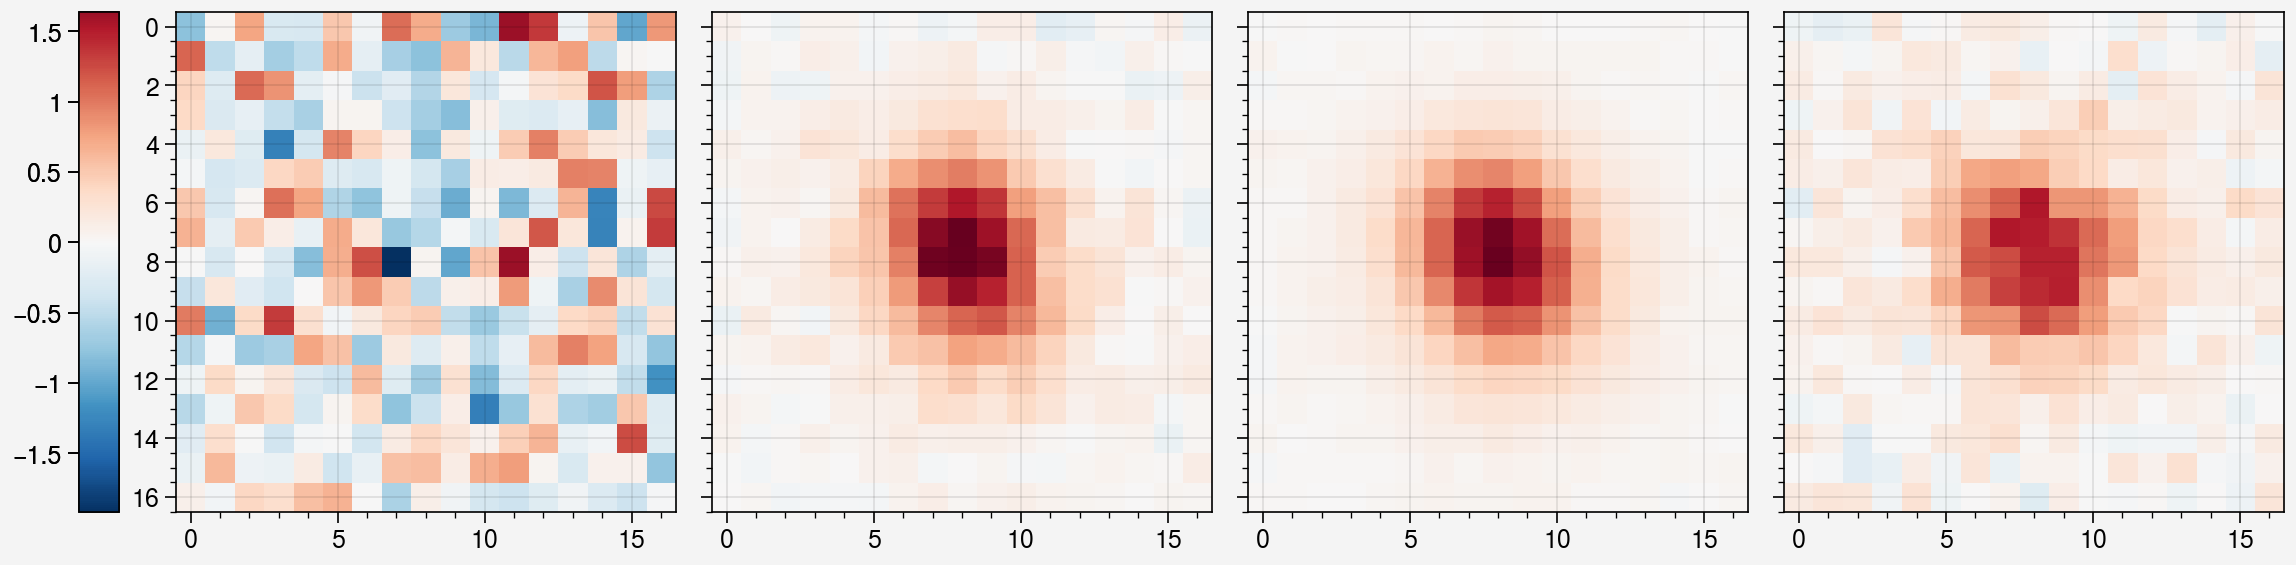

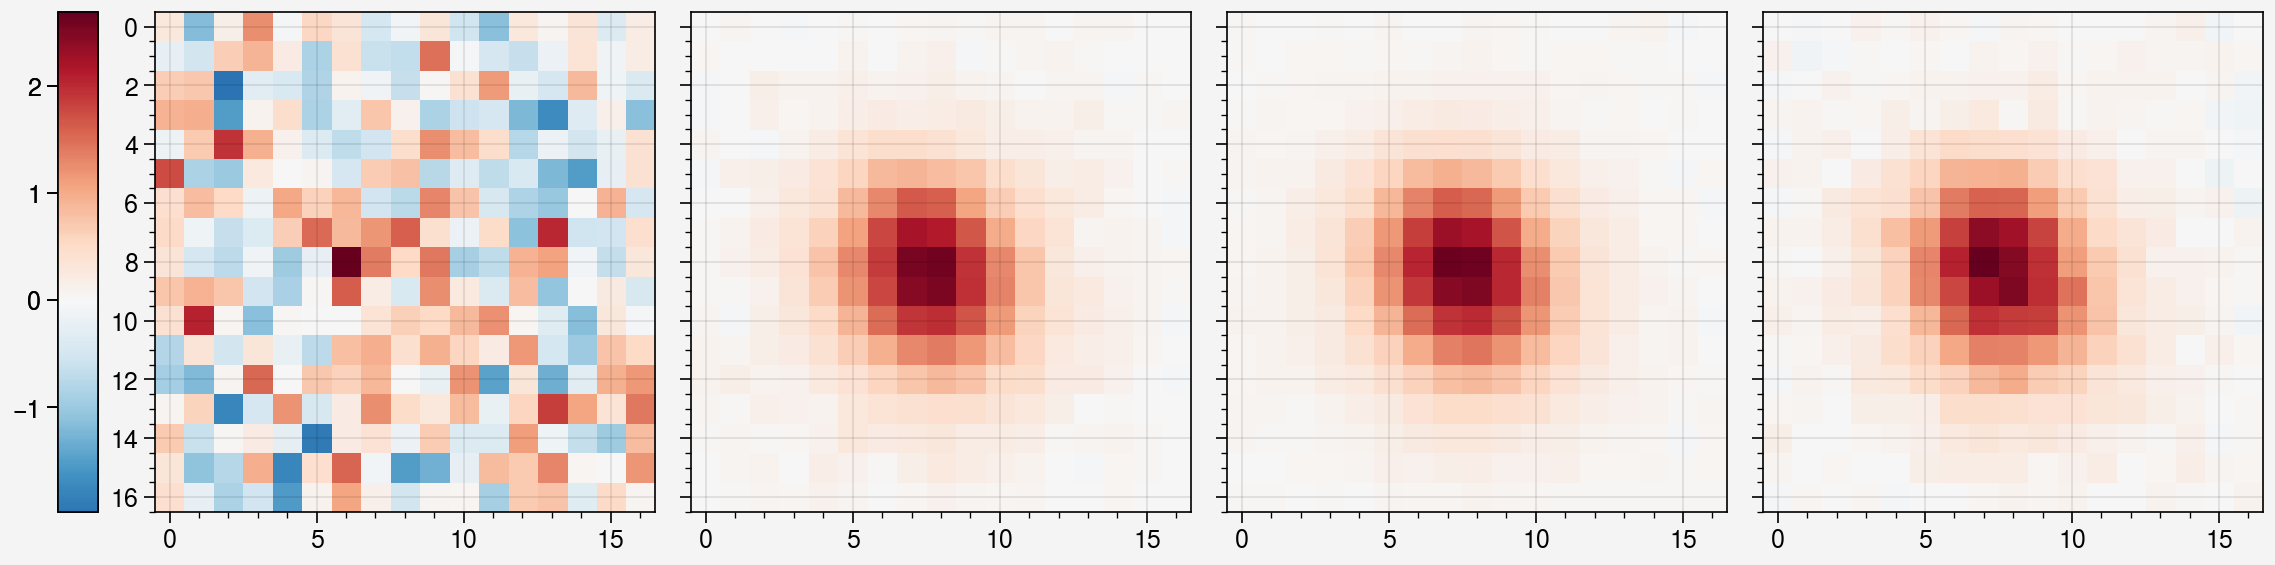

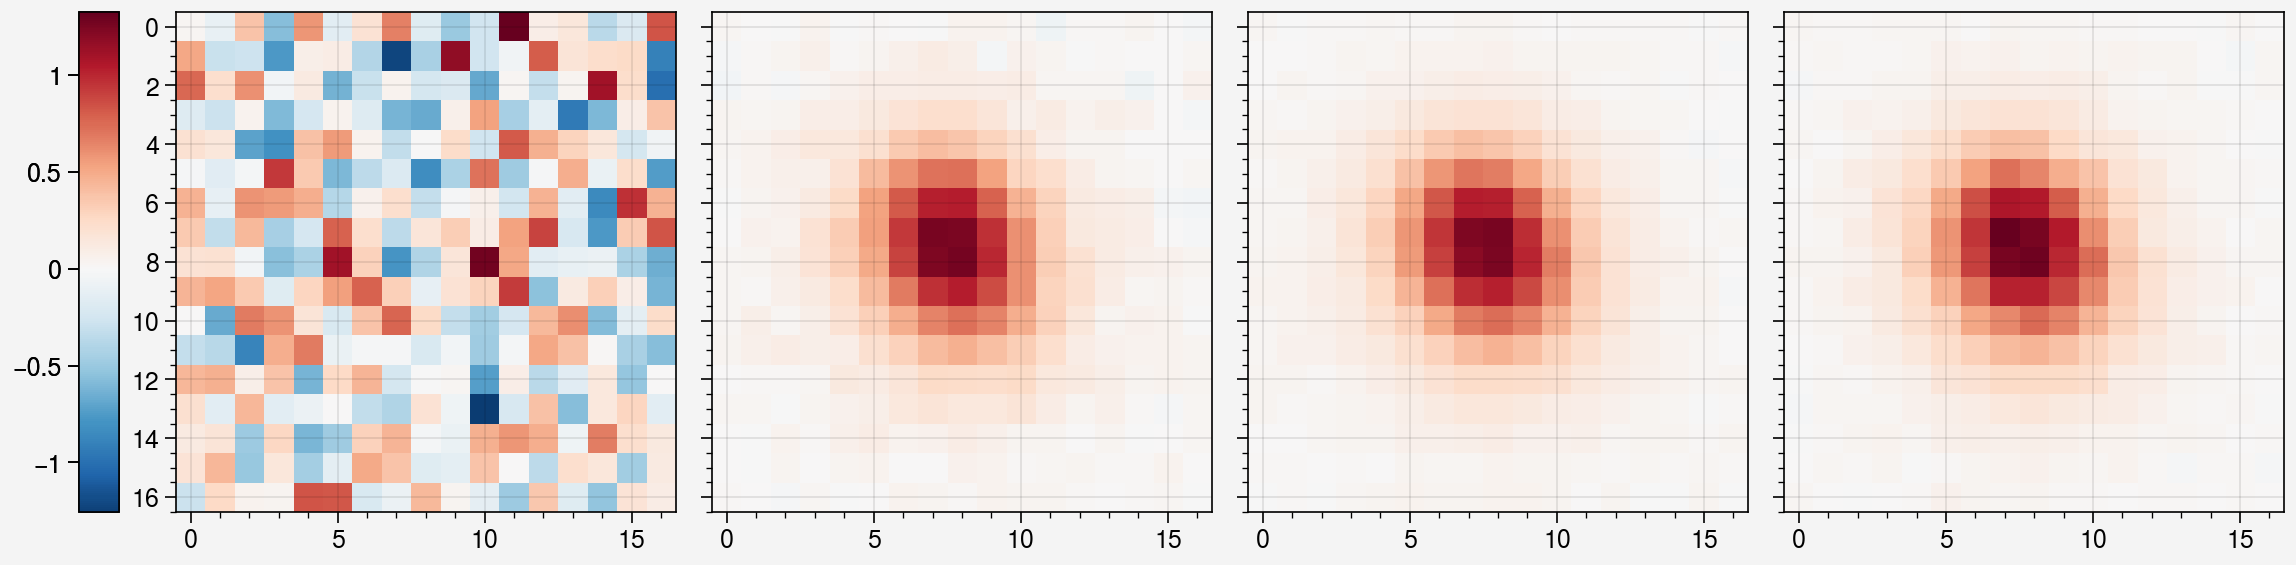

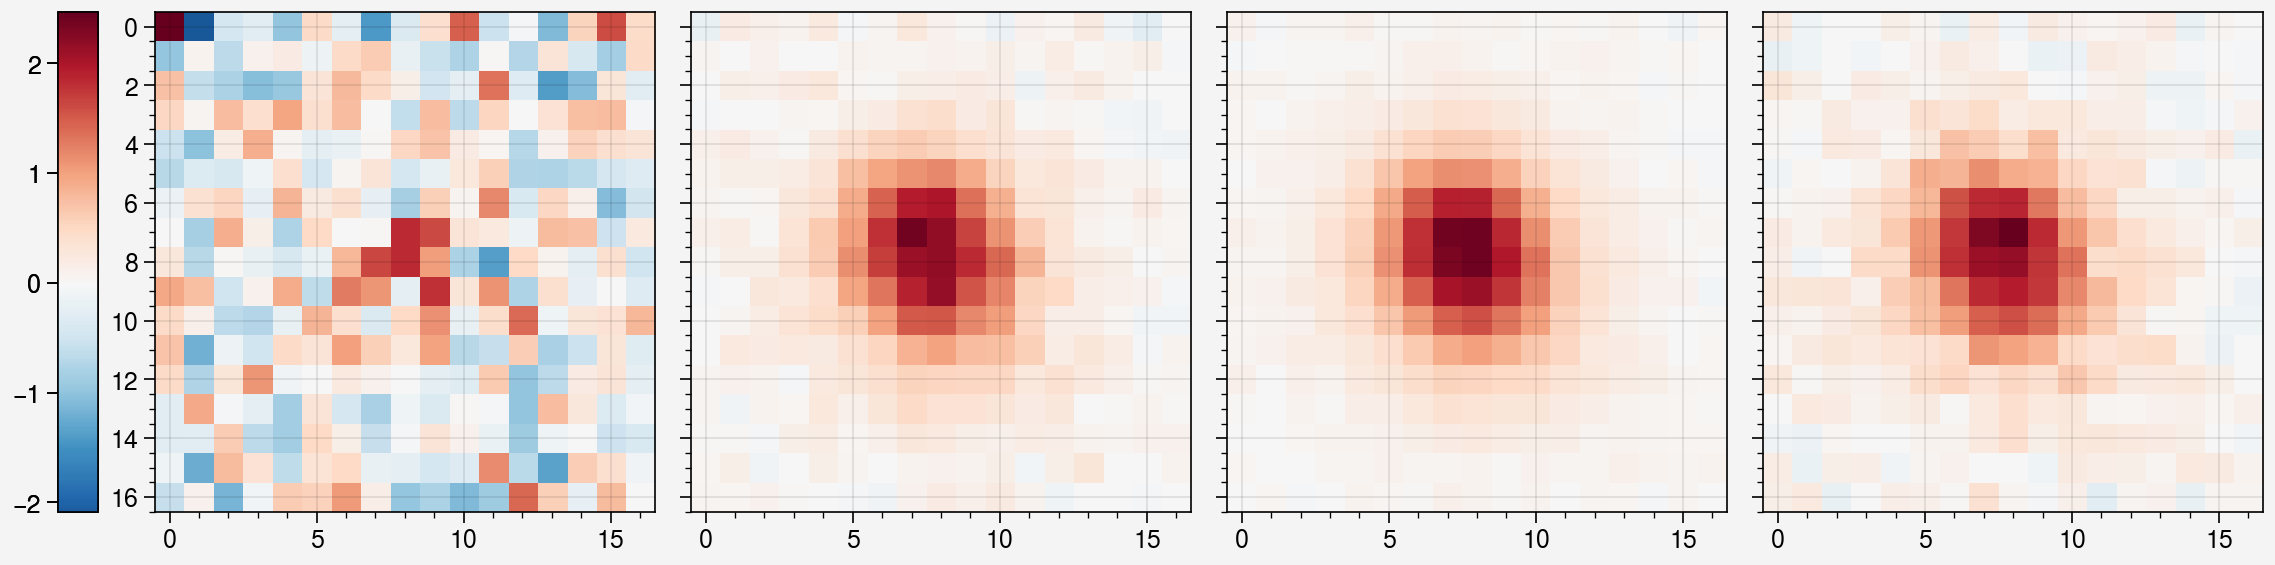

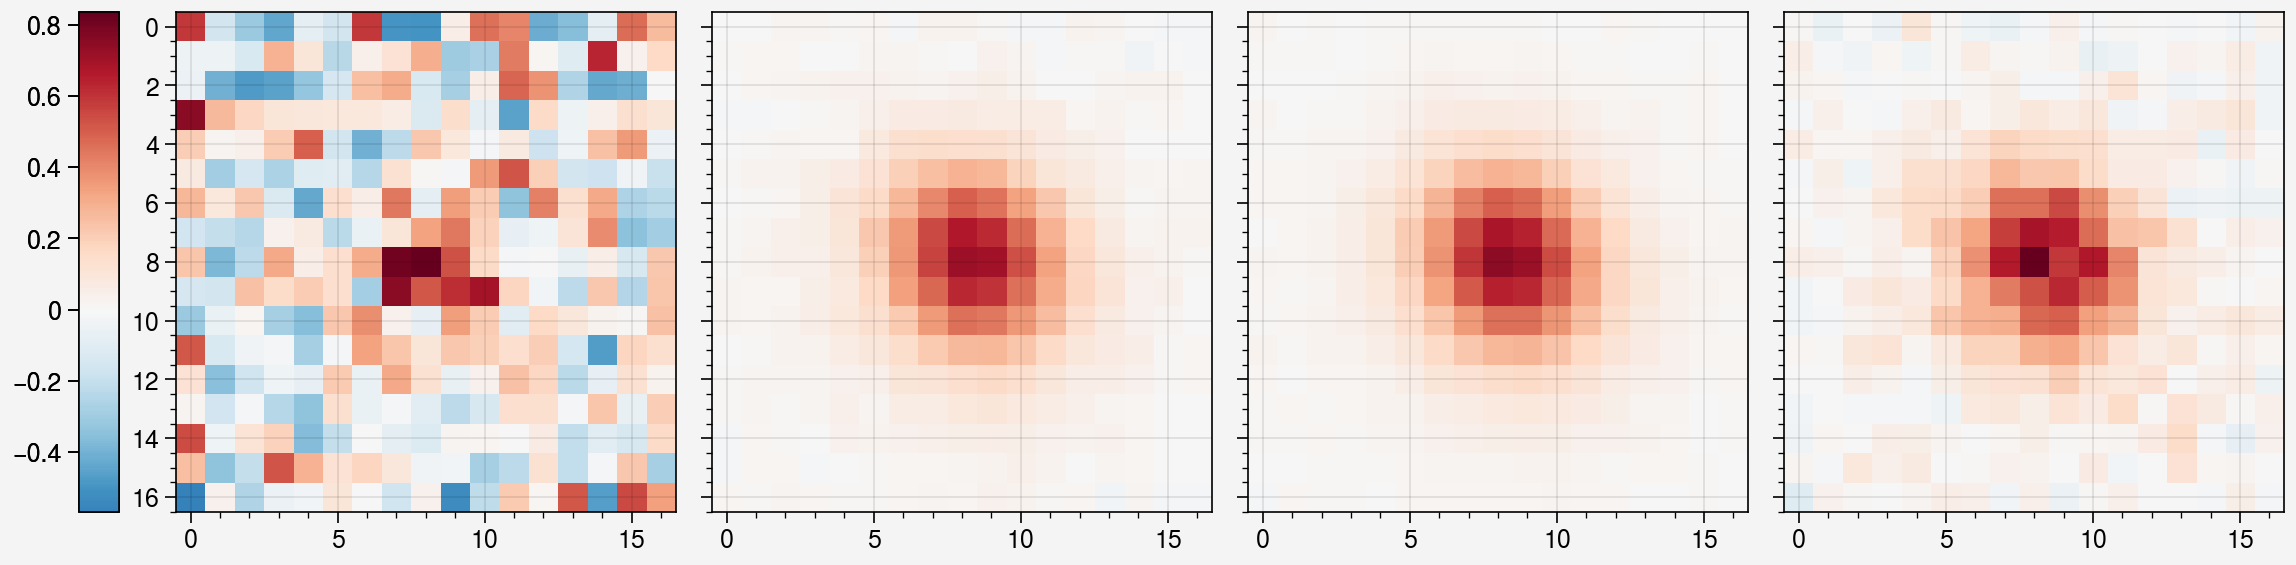

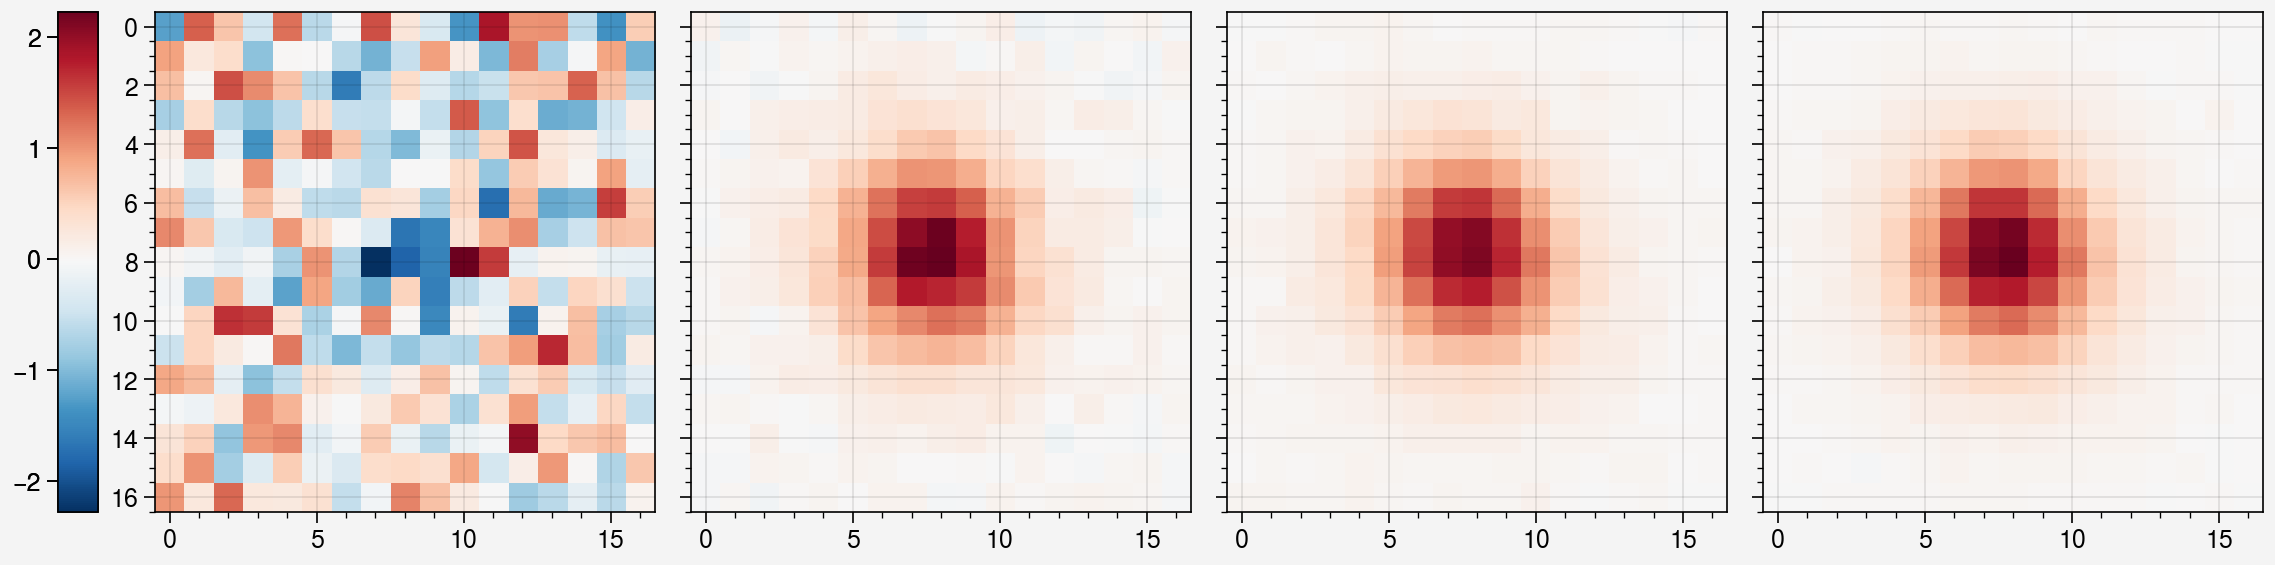

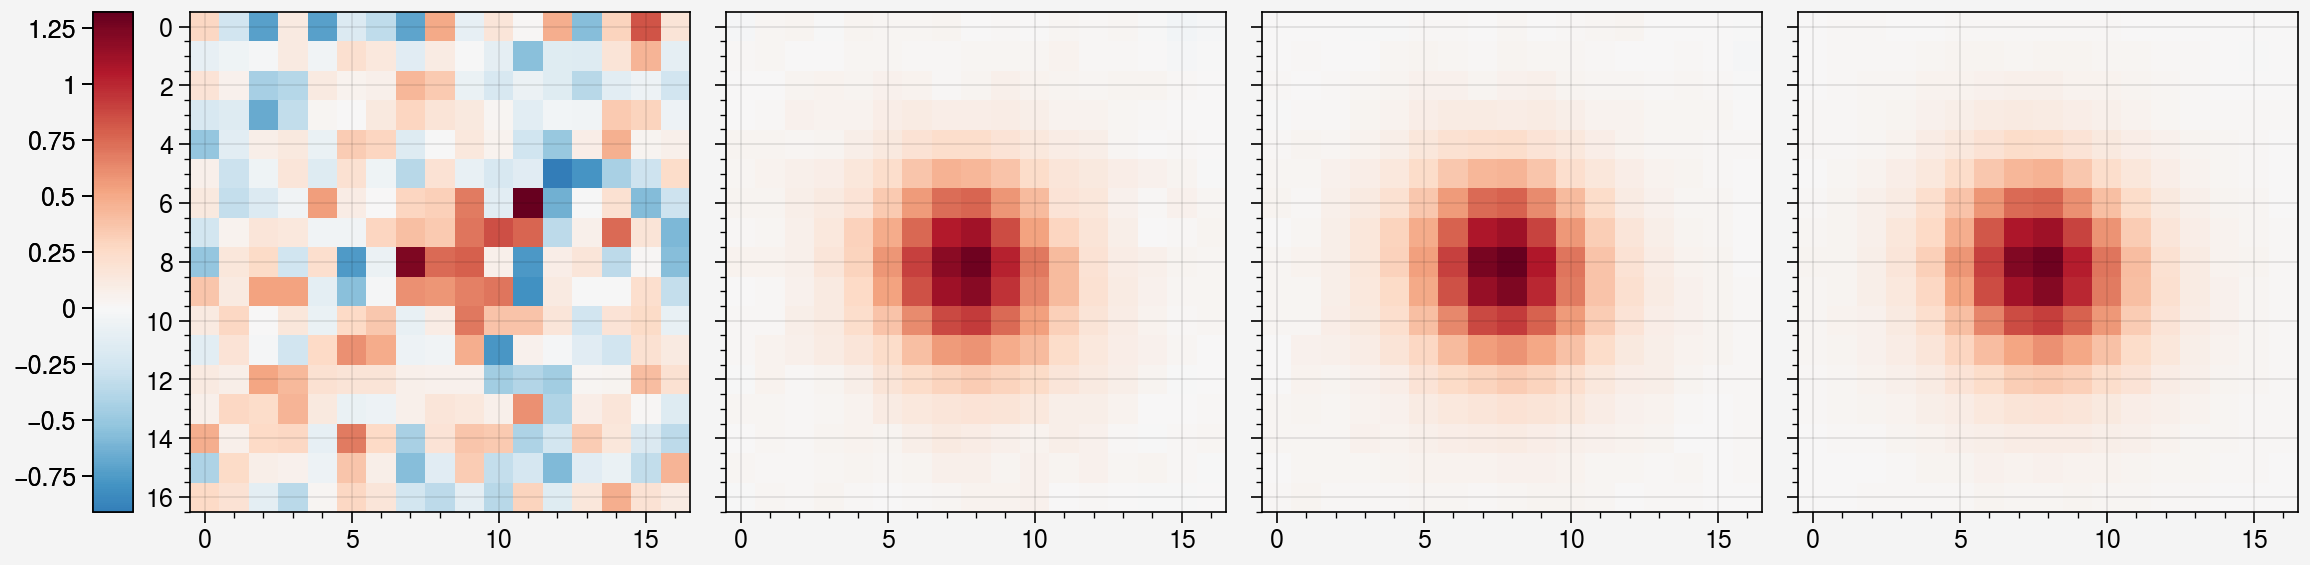

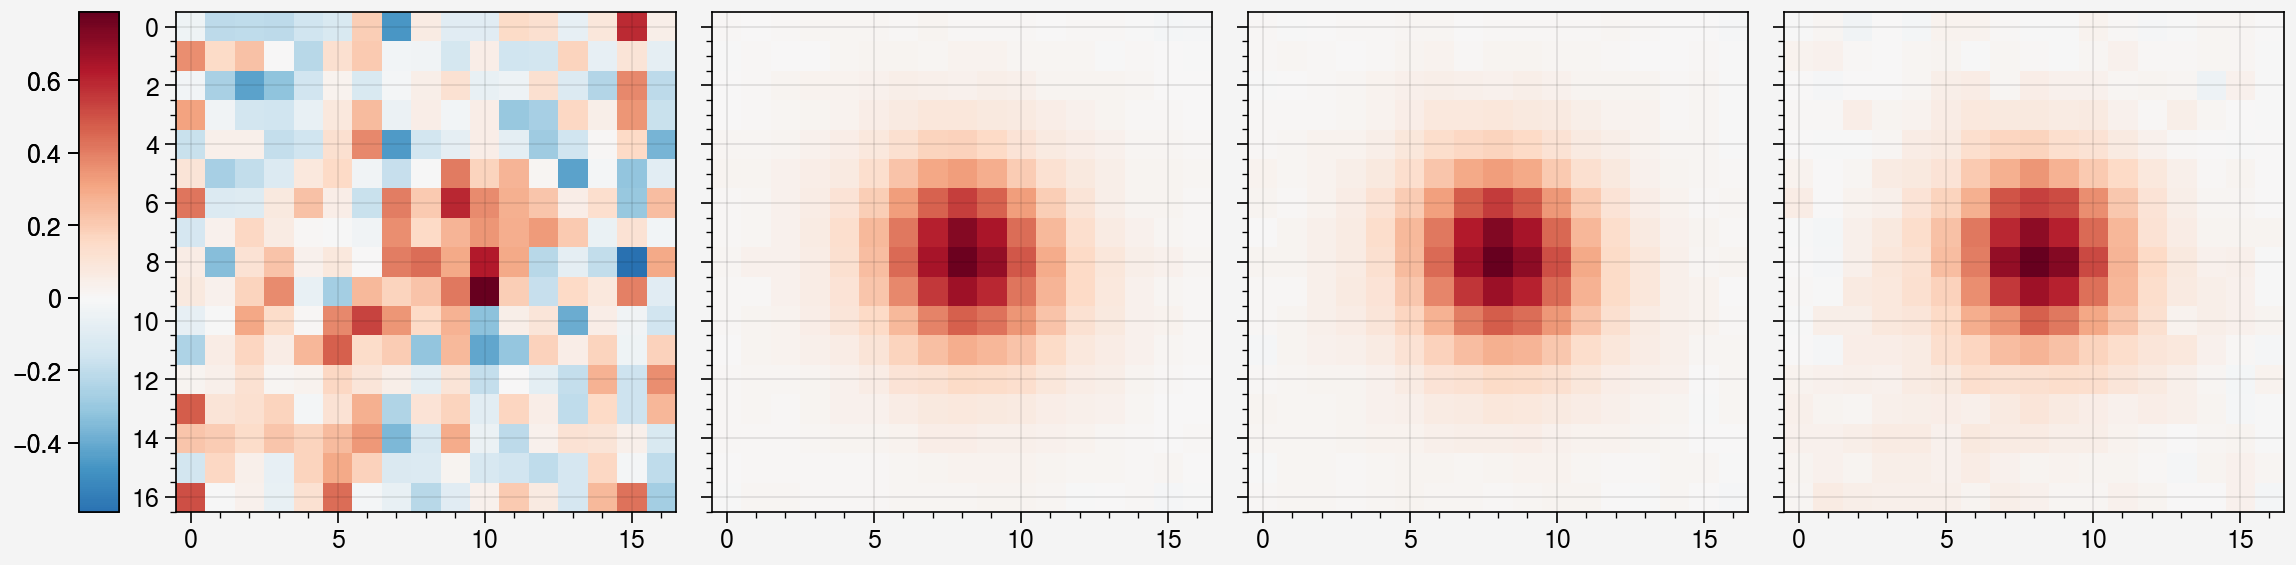

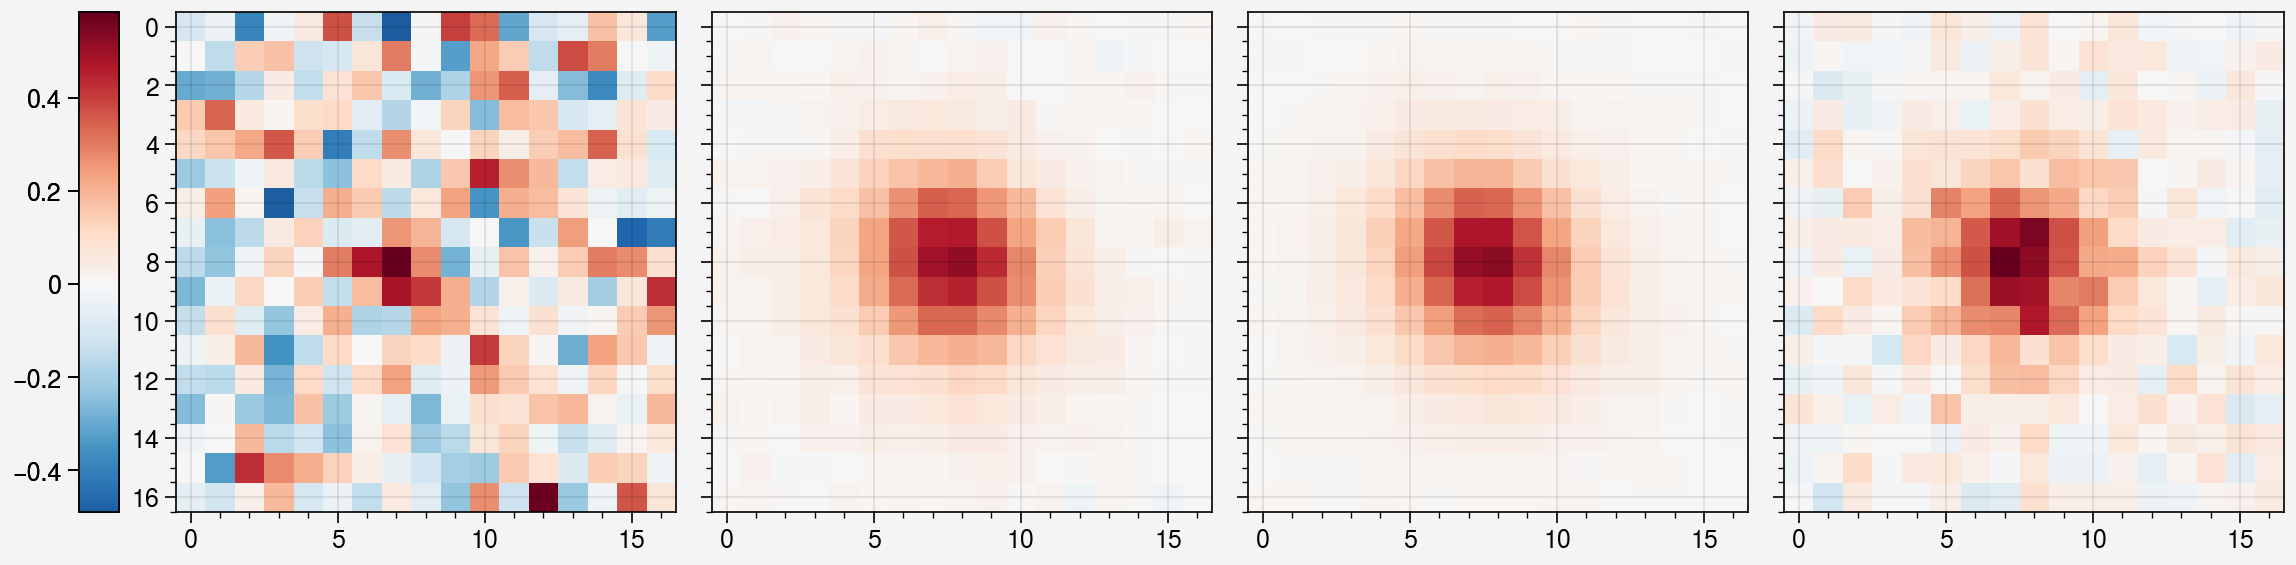

In [74]:
p = None # mmod.get_init_params()

for i in range(len(mmod.stars)):
    print("star:", i)

    _img = mmod.draw(
        x=mmod.stars[i].meta["x"], 
        y=mmod.stars[i].meta["y"], 
        GI_COLOR=mmod.stars[i].meta["col"],
        params=p,
    )

    piff_img = galsim.ImageD(
        mmod.fit_data["star_dim"], 
        mmod.fit_data["star_dim"], 
        wcs=mmod.stars[i].meta["local_wcs"],
    )
    dx = mmod.stars[i].meta["x"] - np.floor(mmod.stars[i].meta["x"] + 0.5) + (mmod.fit_data["star_dim"] -1)/2
    dy = mmod.stars[i].meta["y"] - np.floor(mmod.stars[i].meta["y"] + 0.5) + (mmod.fit_data["star_dim"] -1)/2
    piff_img = piff_mod.draw(
        x=mmod.stars[i].meta["x"]+1, 
        y=mmod.stars[i].meta["y"]+1, 
        GI_COLOR=mmod.stars[i].meta["col"], 
        chipnum=list(piff_mod.wcs.keys())[0],
        center=(dx+1, dy+1),
        image=piff_img,
    )
    print(
        "    sums piff|me|img:", 
        np.sum(piff_img.array), 
        np.sum(_img.array), 
        np.sum(mmod.stars[i].image)
    )
    fig, axs = pplt.subplots(nrows=1, ncols=4)

    swgt = np.sqrt(mmod.stars[i].weight)
    piff_img = piff_img.array
    h0 = axs[0].imshow((_img.array - piff_img) * swgt)
    axs[0].colorbar(h0, loc='l')

    vmin = np.nanmin([piff_img, _img.array, mmod.stars[i].image])
    vmax = np.nanmax([piff_img, _img.array, mmod.stars[i].image])

    axs[1].imshow(piff_img, vmin=vmin, vmax=vmax)
    axs[2].imshow(_img.array, vmin=vmin, vmax=vmax)
    axs[3].imshow(mmod.stars[i].image, vmin=vmin, vmax=vmax)

    dof = mmod.fit_data["star_dim"]**2
    print(
        "    piff chi2/dof:", 
        np.sum(((mmod.stars[i].image - piff_img) * np.sqrt(mmod.stars[i].weight))**2)/dof
    )
    print(
        "    me   chi2/dof:",
        np.sum(((mmod.stars[i].image - _img.array/np.sum(_img.array)) * np.sqrt(mmod.stars[i].weight))**2)/dof
    )

    dilation, g1, g2 = mmod.get_dilation_eta1eta2(
        x=mmod.stars[i].meta["x"], 
        y=mmod.stars[i].meta["y"], 
        GI_COLOR=mmod.stars[i].meta["col"],
        params=p,
    )


    print("    color|dilation|g1|g2:", mmod.stars[i].meta["col"], dilation, g1, g2)

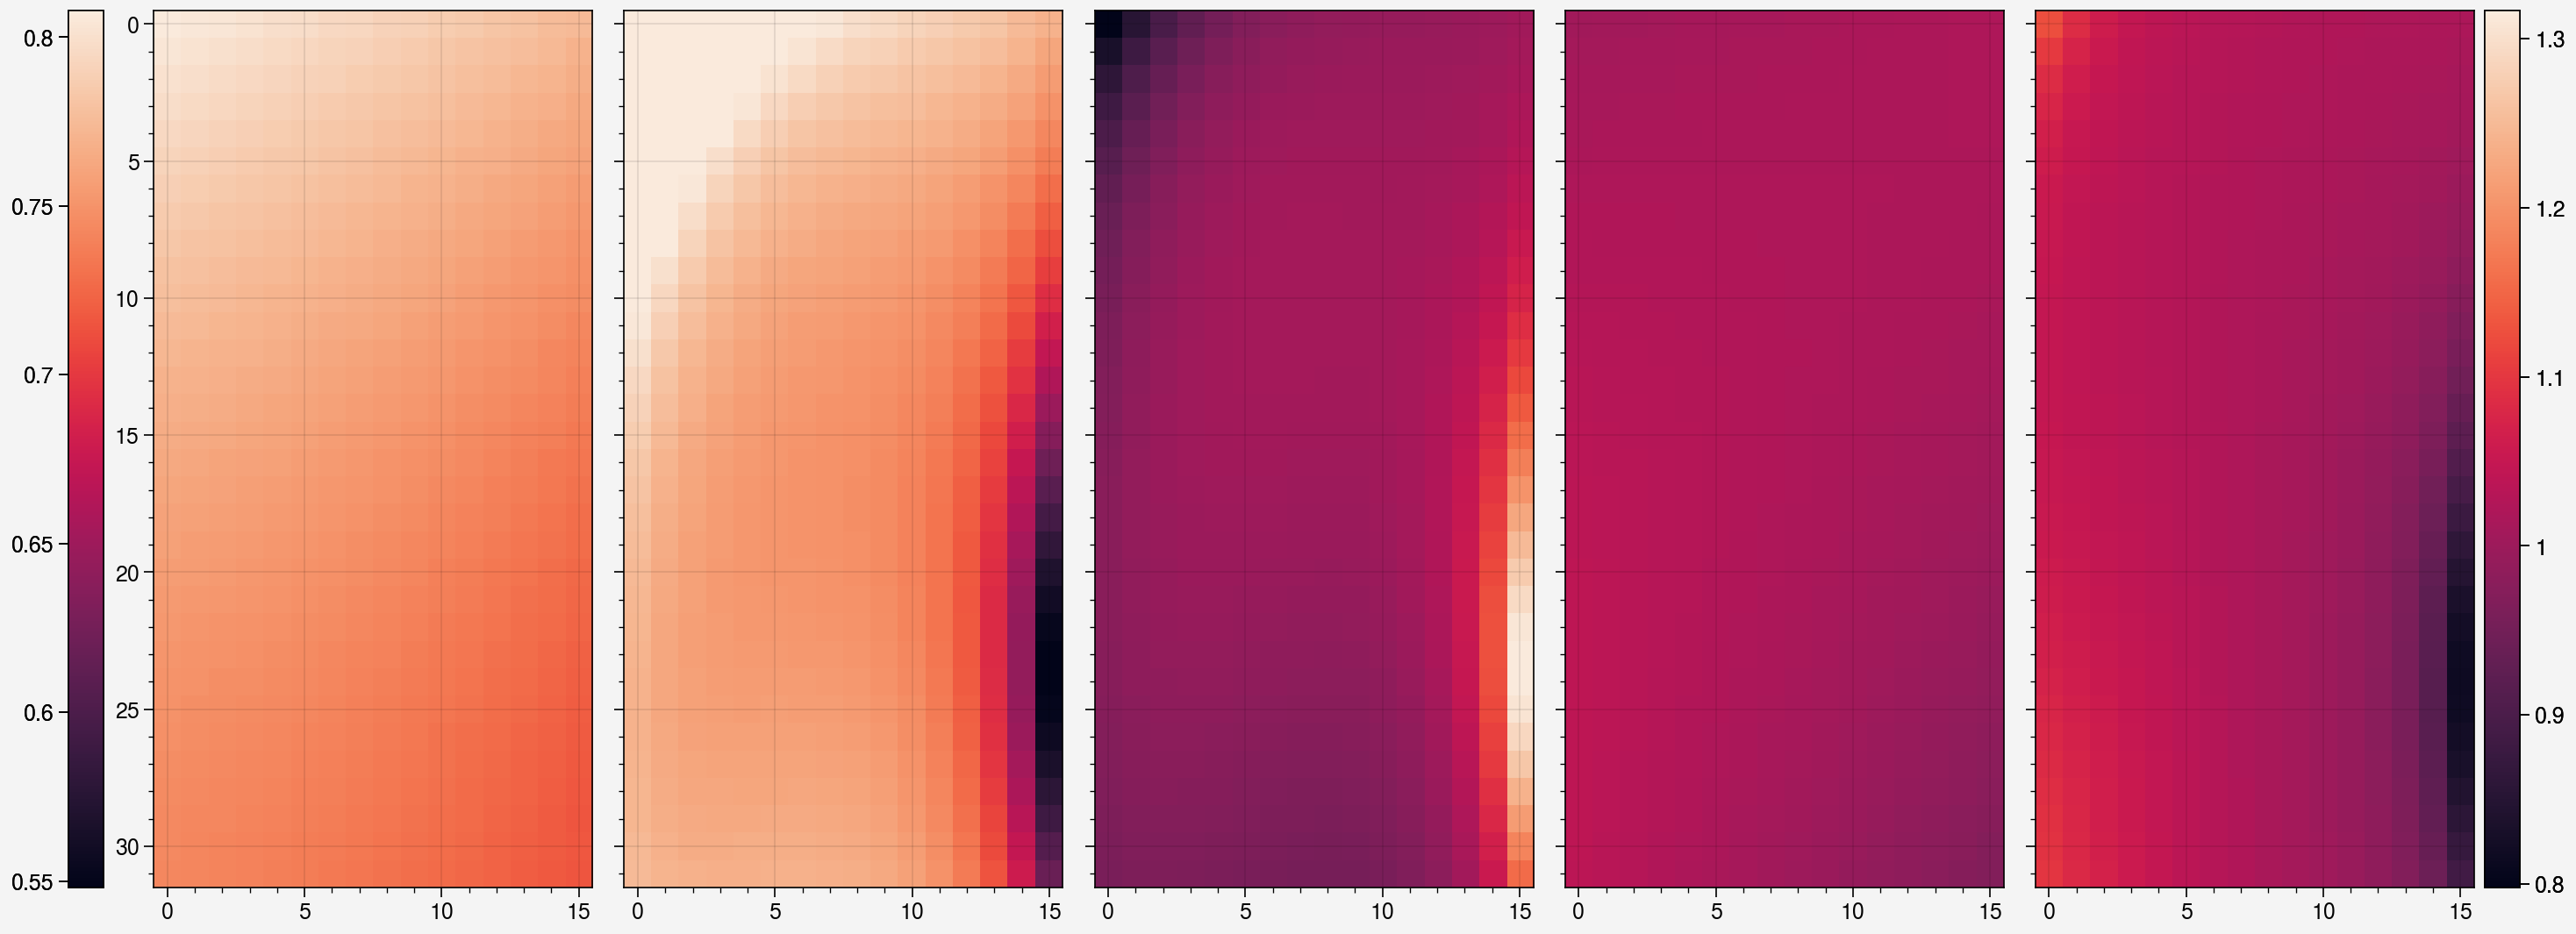

In [75]:
from des_y6utils.piff import measure_t_grid_for_piff_model

res_me = measure_t_grid_for_piff_model(mmod, {"GI_COLOR": 0.61})
res_piff = measure_t_grid_for_piff_model(piff_mod, {"GI_COLOR": 0.61})


res_me_s = measure_t_grid_for_piff_model(mmod, {"GI_COLOR": 1.61})
res_piff_s = measure_t_grid_for_piff_model(piff_mod, {"GI_COLOR": 1.61})

vmin = min(np.nanmin(res_me), np.nanmin(res_piff))
vmax = min(np.nanmax(res_me), np.nanmax(res_piff))

fig, axs = pplt.subplots(ncols=5)
h = axs[0].imshow(res_me, cmap="rocket", vmin=vmin, vmax=vmax)
axs[0].colorbar(h, loc='l')
axs[1].imshow(res_piff, cmap="rocket", vmin=vmin, vmax=vmax)

vmin = np.nanmin([res_me/res_piff, res_me/res_me_s, res_piff/res_piff_s])
vmax = np.nanmax([res_me/res_piff, res_me/res_me_s, res_piff/res_piff_s])

axs[2].imshow(res_me/res_piff, cmap="rocket", vmin=vmin, vmax=vmax)
axs[3].imshow(res_me/res_me_s, cmap="rocket", vmin=vmin, vmax=vmax)
h = axs[4].imshow(res_piff/res_piff_s, cmap="rocket", vmin=vmin, vmax=vmax)
axs[4].colorbar(h, loc="r")

In [ ]:
p = mmod.get_init_params()

In [ ]:
p[:17*17*4].reshape(17*17,4)[8*17+8, :]

In [ ]:
assert not np.array_equal(mmod.draw(x=10, y=100, GI_COLOR=0.61), mmod.draw(x=10, y=100, GI_COLOR=0.61))

In [ ]:
i = 24
_img = mmod.draw(x=mmod.stars[i].meta["x"], y=mmod.stars[i].meta["y"], GI_COLOR=mmod.stars[i].meta["col"])

piff_img = piff_mod.draw(
    x=mmod.stars[i].meta["x"], 
    y=mmod.stars[i].meta["y"], 
    GI_COLOR=mmod.stars[i].meta["col"], 
    chipnum=list(piff_mod.wcs.keys())[0],
)
print(np.sum(piff_img.array), np.sum(_img.array), np.sum(mmod.stars[i].image))
fig, axs = pplt.subplots(nrows=1, ncols=3)
xcen = piff_img.center.x - piff_img.bounds.xmin
ycen = piff_img.center.y - piff_img.bounds.ymin
axs[0].imshow(piff_img.array[ycen-8:ycen+8+1, xcen-8:xcen+8+1])
axs[1].imshow(_img.array)
axs[2].imshow(mmod.stars[i].image)

itr: 0
    chi2/dof: 1.1433685998211116
    params: -0.010392240713000343 0.0856480255804967
    resids: -7.872648768216117 4.994682665975453
itr: 100
    chi2/dof: 1.143355099014355
    params: -0.010392240713000343 0.0856480255804967
    resids: -7.872648768216117 4.994682665975453
    diff params: 0.001
itr: 200
    chi2/dof: 1.1434501213943054
    params: -0.010392240713000343 0.0856480255804967
    resids: -7.872648768216117 4.994682665975453
    diff params: 0.001
itr: 300
    chi2/dof: 1.143067494963735
    params: -0.010392240713000343 0.0856480255804967
    resids: -7.872648768216117 4.994682665975453
    diff params: 0.001
itr: 400
    chi2/dof: 1.1432076600817431
    params: -0.010392240713000343 0.0856480255804967
    resids: -7.872648768216117 4.994682665975453
    diff params: 0.001
itr: 500
    chi2/dof: 1.1437552909118098
    params: -0.010392240713000343 0.0856480255804967
    resids: -7.872648768216117 4.994682665975453
    diff params: 0.001
itr: 600
    chi2/dof: 1.

itr: 4700
    chi2/dof: 0.6232928698419108
    params: -0.144056981727613 0.31098047145381635
    resids: -6.1238546472719095 4.406155340474459
    diff params: 0.001
itr: 4800
    chi2/dof: 0.6231286086946043
    params: -0.144056981727613 0.31098047145381635
    resids: -6.1238546472719095 4.406341217839245
    diff params: 0.001
itr: 4900
    chi2/dof: 0.6232127933270313
    params: -0.144056981727613 0.31098047145381635
    resids: -6.1238546472719095 4.406341217839245
    diff params: 0.001
itr: 5000
    chi2/dof: 0.6232871897499178
    params: -0.144056981727613 0.31098047145381635
    resids: -6.1238546472719095 4.406341217839245
    diff params: 0.001
itr: 5100
    chi2/dof: 0.6231294732149129
    params: -0.144056981727613 0.31098047145381635
    resids: -6.1238546472719095 4.406341217839245
    diff params: 0.001
itr: 5200
    chi2/dof: 0.6231069103737849
    params: -0.144056981727613 0.31098047145381635
    resids: -6.1238546472719095 4.406341217839245
    diff params: 0.00

itr: 9400
    chi2/dof: 0.6218945945969602
    params: -0.2450366543766746 0.2557047546912598
    resids: -6.1684397402930164 4.229261424167082
    diff params: 0.0010000000000000009
itr: 9500
    chi2/dof: 0.6221765942638432
    params: -0.2450366543766746 0.2557047546912598
    resids: -6.1684397402930164 4.229261424167082
    diff params: 0.001
itr: 9600
    chi2/dof: 0.6230904372211565
    params: -0.2450366543766746 0.2557047546912598
    resids: -6.1684397402930164 4.229261424167082
    diff params: 0.001
itr: 9700
    chi2/dof: 0.6218911750744804
    params: -0.2450366543766746 0.2557047546912598
    resids: -6.1684397402930164 4.229261424167082
    diff params: 0.001
itr: 9800
    chi2/dof: 0.6221974589099949
    params: -0.2450366543766746 0.2557047546912598
    resids: -6.1684397402930164 4.229261424167082
    diff params: 0.001
itr: 9900
    chi2/dof: 0.6231729686919107
    params: -0.2450366543766746 0.2557047546912598
    resids: -6.1684397402930164 4.229261424167082
    d

In [ ]:
%debug

In [ ]:
piff_mod.get_profile?

In [ ]:
thresh = 10
t_arr = measure_t_grid_for_piff_model(piff_mod, {"GI_COLOR": 0.61})
data = measure_star_t_for_piff_model(piff_mod, img, wgt, piff_prop="GI_COLOR")
ts_arr = map_star_t_to_grid(data)

res_g = make_good_regions_for_piff_model_gal_grid(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=11, verbose=False)
res_sg = make_good_regions_for_piff_model_star_and_gal_grid(
    piff_mod, img, wgt, piff_kwargs={"GI_COLOR": 0.61}, seed=11, verbose=False,
    flag_bad_thresh=thresh, any_bad_thresh=thresh,
)

In [ ]:
vmin = min(np.nanmin(ts_arr), np.nanmin(t_arr))
vmax = max(np.nanmax(ts_arr), np.nanmax(t_arr))

fig, axs = pplt.subplots(ncols=3, share=0)
h0 = axs[0].imshow(ts_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[0].grid(False)
axs[0].set_title("stars on grid w/ 2d poly")
axs[0].colorbar(h0, loc='l')

axs[1].imshow(t_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[1].grid(False)
axs[1].set_title("grid of shapes at gal color")

b = res_g["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="red")

b = res_sg["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="blue")

harr = (t_arr-ts_arr).ravel()
std5 = nanmad(harr) * thresh
h = axs[2].hist(harr, bins=50)
axs[2].vlines([-std5, np.nanmedian(harr)+std5], 0, np.max(h[0]), color="k")
axs[2].set_xlabel("gal T - star T")
ax = axs[0]

In [ ]:
import ngmix

def get_star_stamp_pos(s, img, wgt):
    xint = int(np.floor(s.x - 1 + 0.5))
    yint = int(np.floor(s.y - 1 + 0.5))
    bbox = 17
    bbox_2 = (bbox - 1)//2
    
    return dict(
        img=img[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        wgt=wgt[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        xstart=xint-bbox_2, 
        ystart=yint-bbox_2,
        dim=bbox,
        x=s.x - 1,
        y=s.y - 1,
    )

def get_star_piff_obs(piff_mod, s, img, wgt):
    
    sres = get_star_stamp_pos(s, img, wgt)
    
    xv = sres["x"]+1
    yv = sres["y"]+1
    wcs = list(piff_mod.wcs.values())[0].local(
        image_pos=galsim.PositionD(x=xv, y=yv)
    ).jacobian()
    img = galsim.ImageD(sres["dim"], sres["dim"], wcs=wcs)
    cen = (
        sres["x"] - sres["xstart"] + 1,
        sres["y"] - sres["ystart"] + 1,
    )
    img = piff_mod.draw(
        x=xv, y=yv, chipnum=list(piff_mod.wcs.keys())[0],
        GI_COLOR=s.data.properties["GI_COLOR"],
        image=img, center=cen,
    )
    model_obs = ngmix.Observation(
        image=img.array,
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    star_obs = ngmix.Observation(
        image=sres["img"],
        weight=sres["wgt"],
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    return model_obs, star_obs, sres

In [ ]:

x = []
y = []
t = []

for s in piff_mod.stars:

    mobs, sobs, sres = get_star_piff_obs(piff_mod, s, img, wgt)
    
    res = ngmix.admom.AdmomFitter(
        rng=np.random.RandomState(seed=10)
    ).go(mobs, ngmix.moments.fwhm_to_T(1))
    t.append(res["T"])
    x.append(sres["x"])
    y.append(sres["y"])
    

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(np.array([x, y]).T, np.array(t))

In [ ]:
y, x = np.mgrid[0:4096:128, 0:2048:128] + 64
tg = polyreg.predict(np.array([x.ravel(), y.ravel()]).T)

In [ ]:
tg = tg.reshape(x.shape)

In [ ]:
fig, axs = pplt.subplots(ncols=2)
axs[0].imshow(tg)
axs[1].imshow(res["t_arr"])

In [ ]:
def _nanmad(x, axis=None):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis : {int, sequence of int, None}, optional
        `axis` keyword for

    Returns
    -------
    mad: float
        MAD of array x
    """
    return 1.4826*np.nanmedian(np.abs(x - np.nanmedian(x, axis=axis)), axis=axis)


In [ ]:
print(_nanmad(t), _nanmad(tg))

In [ ]:
from des_y6utils.piff import make_good_regions_for_piff_model

In [ ]:
res = make_good_regions_for_piff_model(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=10, verbose=False)

In [ ]:
res["t_std"]

In [ ]:
fig, axs = pplt.subplots()

axs.hist((res["t_arr"] - tg).ravel(), bins=50)

In [ ]:
np.std((res["t_arr"] - tg).ravel()) * 5

In [ ]:
np.max(np.abs(np.max(t) - np.median(t)))

In [ ]:
_nanmad(t)

In [ ]:
img = np.ones((17, 17))* 5
print(img.sum())
gs = galsim.InterpolatedImage(galsim.ImageD(img), scale=0.3, x_interpolant="lanczos3", normalization="flux")

print(gs.drawImage(nx=27, ny=27, scale=0.263, method="no_pixel").array.sum())